# A Third-party Analysis of the *AASL Standards*

Yujia Gao

This section contains the analysis of **school librarians**.
#### Important Libraries

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
from matplotlib.patches import Patch
import seaborn as sns
import spacy
from nltk.corpus import opinion_lexicon
from nltk import download
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from wordcloud import WordCloud
from bertopic import BERTopic

d:\aaa硬盘备份\Katrina\研究生\研二冬季\SI 699\capstone_project\src\bert_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Load Data

In [ ]:
df = pd.read_csv("data/AASL Standards Survey - School Librarians - Sheet.csv")
df.shape

(791, 226)

#### Data Cleaning and Preprocessing

Data cleaning was more complex than anticipated, primarily due to the survey's structure. Many questions allowed multiple selections or required respondents to rank choices, making the dataset format unconventional. Instead of a standard table with one row for field names and one column for record indexes, the dataset required reorganization. We expanded multi-choice responses into separate fields to facilitate analysis.

Another challenge was the extensive demographic and work experience data collected. While the survey provided a comprehensive view of respondents, not all categories were necessary for our analysis. To maintain clarity, we categorized school librarians by **"Job Roles"** rather than alternative classifiers like school levels (elementary, middle, high school) or school settings (public, private, charter). This decision aligned with our client’s priorities, as they were particularly interested in insights from librarians with specific job titles.

More specifically, we performed the following tasks:
- **Dropped irrelevant fields.**
    The dataset contained 52 questions, some of which overlapped in content or were not directly relevant to our analysis. To streamline the dataset, we removed redundant or unrelated fields, ensuring a clearer structure.
- **Renamed columns.**
    Since the dataset was directly exported from a survey platform, field names were lengthy question texts, making them difficult to reference in code. We assigned concise, descriptive names to improve readability and usability.
- **Reformatted the dataset to handle multi-answer questions**
    A major challenge was handling "select all that apply" questions, where respondents could choose multiple answers. The original data structure made analysis difficult, so we reorganized these responses into a more structured format. After renaming the columns, we also removed the first row, which contained subtitles rather than actual data, to ensure consistency.

In [3]:
df.head()

,Respondent ID,Collector ID,Start Date,End Date,IP Address,Email Address,First Name,Last Name,Custom Data 1,"Which of the following positions most closely reflects your job role? If you are retired, please select the option that is closest to the job role you had at retirement.",...,Unnamed: 216,What is the primary language spoken in your work environment?,Unnamed: 218,"Are you of Hispanic or Latino background – such as Mexican, Puerto Rican, Cuban, or another Latin American background?",Which of the following categories best describes your race or ethnicity?,Unnamed: 221,Which of the following categories best describes your employment status?,Unnamed: 223,"Which of the following categories best describes your total household income last year, before taxes, including everyone in your household?",Is there anything else you would like to add?
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Response,...,Another language (please specify),Response,Other (please specify),Response,Response,Other (please specify),Response,Other (please specify),Response,Open-Ended Response
1,1.144618e+11,428602709.0,2023-11-12 18:45:57,2023-11-29 08:28:25,NaN,NaN,NaN,NaN,NaN,Certified / licensed school librarian,...,NaN,English,NaN,No,White,NaN,Employed full-time,NaN,"$150,000 to less than $200,000",NaN
2,1.144688e+11,428602709.0,2023-11-20 22:41:50,2023-11-20 22:44:30,NaN,NaN,NaN,NaN,NaN,Certified / licensed school librarian,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.144688e+11,428602709.0,2023-11-20 21:11:58,2023-11-20 21:20:02,NaN,NaN,NaN,NaN,NaN,Certified / licensed school librarian,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.144682e+11,428602709.0,2023-11-20 09:17:12,2023-11-20 19:20:08,NaN,NaN,NaN,NaN,NaN,Certified / licensed school librarian,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.columns

Index(['Respondent ID', 'Collector ID', 'Start Date', 'End Date', 'IP Address',
       'Email Address', 'First Name', 'Last Name', 'Custom Data 1',
       'Which of the following positions most closely reflects your job role? If you are retired, please select the option that is closest to the job role you had at retirement.',
       ...
       'Unnamed: 216',
       'What is the primary language spoken in your work environment?',
       'Unnamed: 218',
       'Are you of Hispanic or Latino background – such as Mexican, Puerto Rican, Cuban, or another Latin American background?',
       'Which of the following categories best describes your race or ethnicity?',
       'Unnamed: 221',
       'Which of the following categories best describes your employment status?',
       'Unnamed: 223',
       'Which of the following categories best describes your total household income last year, before taxes, including everyone in your household?',
       'Is there anything else you would like to add

In [5]:
# drop irrelavent ID and date fields
df = df.drop(columns=['Respondent ID', 'Collector ID', 
                                      'Start Date', 'End Date'])

# drop fields that contain only missing values (NaN)
df = df.dropna(axis=1, how='all')

Those "unnamed" columns are parts of the multiselect questions. They are choices under the mother question, so their actual "field names" are in the first row of this dataframe, which makes the dataframe odd-looking.

In [6]:
# drop part of Q2 and all Q3 and all Q4
df = df.drop(df.columns[5:24], axis=1)

# drop Q7
df = df.drop(columns=['How valuable is your membership in AASL?'])

In [7]:
df.shape

(791, 197)

In [8]:
# drop Q37-Q49
df = df.drop(df.columns[170:196], axis=1)

In [9]:
df.shape

(791, 171)

The above code prints all the left column names. After comparing one by one with the survey question, I confirmed manually that the left questions are what we want to analyze on and all the other unnecessary fields are dropped.

The next step is to rename field names to make them shorted, as well as assigning all those "Unnamed" columns with something meaningful. 

In [10]:
df.rename(columns={df.columns[0]: 'jobRole',
                   
                   df.columns[1]: 'Elementary School',
                   df.columns[2]: 'Junior High School',
                   df.columns[3]: 'High School',
                   df.columns[4]: 'Multiple Buildings',

                   df.columns[5]: 'q5_None',
                   df.columns[6]: 'q5_AASL',
                   df.columns[7]: 'q5_ALA',
                   df.columns[8]: 'q5_state_library_assco',
                   df.columns[9]: 'q5_state_school_library_assco',
                   df.columns[10]: 'q5_state_library',
                   df.columns[11]: 'q5_state_Dept_education',
                   df.columns[12]: 'q5_ISTE',
                   df.columns[13]: 'q5_future_ready_schools',
                   df.columns[14]: 'q5_CCSS',
                   df.columns[15]: 'q5_NCTE',
                   df.columns[16]: 'q5_NCTM',
                   df.columns[17]: 'q5_NCSS',
                   df.columns[18]: 'q5_NGSS',
                   df.columns[19]: 'q5_CAEP',
                   df.columns[20]: 'q5_NBPTS',
                   df.columns[21]: 'q5_CoSN',
                   df.columns[22]: 'q5_others',

                   df.columns[23]: 'AASL_member', # Q6
                   df.columns[24]: 'aware_revision', # Q8
                   df.columns[25]: 'purchase', # Q9
                   df.columns[26]: 'q10_currently_use', # Q10
                   df.columns[27]: 'q10_others',

                   # Q11
                   df.columns[28]: 'reason_not_use_school',
                   df.columns[29]: 'reason_not_use_state',
                   df.columns[30]: 'reason_not_use_accessible',
                   df.columns[31]: 'reason_not_use_prior_exp',
                   df.columns[32]: 'reason_not_use_broken_down',
                   df.columns[33]: 'reason_not_use_others'}
                   , inplace=True)

In [11]:
df.rename(columns={df.columns[34]: 'access_own', # Q12
                   df.columns[35]: 'access_borrow',
                   df.columns[36]: 'access_school',
                   df.columns[37]: 'access_plan_purchase',
                   df.columns[38]: 'access_framework_web',
                   df.columns[39]: 'access_framework_poster',
                   df.columns[40]: 'access_others',

                   df.columns[41]: 'familarity', # Q13
                   df.columns[42]: 'overall_rating', # Q14
                   df.columns[43]: 'poor_rating_reasons', # Q15

                   # Q16 - higher score, higher rating
                   df.columns[44]: 'book_valuable',
                   df.columns[45]: 'book_relevant',
                   df.columns[46]: 'book_practical',
                   df.columns[47]: 'book_useful',
                   df.columns[48]: 'book_easy_to_use',
                   df.columns[49]: 'book_easy_to_understand',
                   df.columns[50]: 'book_well_written',
                   df.columns[51]: 'book_nicely_designed',
                   df.columns[52]: 'book_well_organized',
                   df.columns[53]: 'book_ADA_accessible',


                   df.columns[54]: 'What you like about the book', # Q17
                   df.columns[55]: 'What you dislike about the book', # Q18

                   # Q19 - higher score, higher rating
                   df.columns[56]: 'standards_easy_to_explain',
                   df.columns[57]: 'standards_achievable',
                   df.columns[58]: 'standards_good_advocacy_tool',
                   df.columns[59]: 'standards_helps_foster_culture_changes',
                   df.columns[60]: 'standards_useful_for_collaboration',
                   df.columns[61]: 'standards_easy_to_implement',

                   # Q20
                   df.columns[62]: 'The AASL Standards are valuable to the library community.',
                   df.columns[63]: 'The AASL Standards are valuable to the education community.',
                   df.columns[64]: 'A good school librarian uses formal standards to develop and administer a school library.',
                   df.columns[65]: 'My school administration knows about the AASL Standards.',
                   df.columns[66]: 'The educators I collaborate with know about the AASL Standards.',
                   df.columns[67]: 'The AASL Standards reinforces the professionalism of school librarians.',
                   
                   # Q21
                   df.columns[68]: 'The school library is a unique and essential part of a learning community.',
                   df.columns[69]: 'Qualified school librarians lead effective school libraries',
                   df.columns[70]: 'Learners should be prepared for college, career and life.',
                   df.columns[71]: 'Reading is the core of personal and academic competency.',
                   df.columns[72]: "Intellectual freedom is every learner's right",
                   df.columns[73]: 'Information technologies must be appropriately integrated and equitably available.'}
                   , inplace=True)

In [12]:
df.rename(columns={df.columns[74]: 'use_frequency', # Q22
                   
                   # Q23
                   df.columns[75]: 'p1_Common Beliefs central to the profession.',
                   df.columns[76]: 'p1_Separate frameworks for Learners, School librarians, and School Libraries.',
                   df.columns[77]: 'p1_Competencies for Learners.',
                   df.columns[78]: 'p1_Competencies for School Librarians.',
                   df.columns[79]: 'p1_Alignments for School Libraries.',
                   df.columns[80]: 'p2_Integrated Frameworks by Shared Foundation [Inquire, Include, Collaborate, Curate, Explore, Engage]',
                   df.columns[81]: 'p2_Framework Competencies and Alignments in Depth.',
                   df.columns[82]: 'p2_Framework Best Practices.',
                   df.columns[83]: 'p3_Questions for the Reflective Practitioner at the end of each chapter.',
                   df.columns[84]: 'p3_chap12',
                   df.columns[85]: 'p3_chap13_Measuring School Librarian Growth Examples of aligning AAS: Standards with commonly used educator evaluation models.',
                   df.columns[86]: 'p3_chap13_Measuring School Librarian Growth Discussion on developing and measuring school librarian development growth plans.',
                   df.columns[87]: 'p3_chap14_Evaluating School Libraries Discussion of responsibilities at the school, district, and state level.',
                   df.columns[88]: 'p3_chap14_Evaluating School Libraries School Library Evaluation Checklist.',
                   df.columns[89]: 'p4_Scenarios for Professional Learning',
                   df.columns[90]: 'a_Useful Verbs',
                   df.columns[91]: 'a_Works Cited',
                   df.columns[92]: 'a_Suggested Further Reading',
                   df.columns[93]: 'a_Index',
                   df.columns[94]: 'a_Lists of Illustrations',

                   # Q24
                   df.columns[95]: 'The language of competency-based standards (p.19)',
                   df.columns[96]: 'The structure of the AASL Standards Frameworks (p.17)',
                   df.columns[97]: 'The interdependent nature of the learner, school librarian, and school library frameworks',
                   df.columns[98]: 'The Key Commitments of the Shared Foundatiions',
                   df.columns[99]: 'The interrelated aspects of the Shared Foundations',
                   df.columns[100]: 'The continuum of the learning Domains (p.15)',
                   df.columns[101]: 'The context of the Competencies and Alignments, explored in depth following each Shared Foundation framework',

                   # Q25
                   df.columns[102]: 'frequency_AASL Standards Frameworks_for Learners',
                   df.columns[103]: 'frequency_AASL Standards Frameworks_for School librarians',
                   df.columns[104]: 'frequency_AASL Standards Frameworks_for School Libraries',
                   
                   # Q26
                   df.columns[105]: 'frequency_shared foundations_Inquire',
                   df.columns[106]: 'frequency_shared foundations_Include',
                   df.columns[107]: 'frequency_shared foundations_collaborate',
                   df.columns[108]: 'frequency_shared foundations_curate',
                   df.columns[109]: 'frequency_shared foundations_explore',
                   df.columns[110]: 'frequency_shared foundations_engage',

                   # Q27
                   df.columns[111]: 'frequency_standards_Think',
                   df.columns[112]: "frequency_standards_Create",
                   df.columns[113]: 'frequency_Share',
                   df.columns[114]: 'frequency_Grow'}
                   , inplace=True)

In [13]:
df.rename(columns={df.columns[115]: 'lesson preparation and assessment', # Q28
                   df.columns[116]: 'School librarian evaluation',
                   df.columns[117]: 'Engaging with pther educators (school librarians, classroom teachers, administrators)',
                   df.columns[118]: 'Engaging with other libraries (community college, academic, public)',
                   df.columns[119]: 'Demonstrating success to others',
                   df.columns[120]: 'Guiding instructional priorities',
                   df.columns[121]: 'Developing school library curriculum',
                   df.columns[122]: 'Shaping the school library',
                   df.columns[123]: 'Making sure the school library is meeting national standards',
                   df.columns[124]: 'Advocating on behalf of the school library',
                   df.columns[125]: 'Advocating on behalf of the learners',
                   df.columns[126]: 'Increasing the understanding of the role of the school librarian',
                   df.columns[127]: 'Legitimizing the school librarian profession',
                   df.columns[128]: 'helpful_others',

                   df.columns[129]: 'suggestion_anything new', # Q29
                   
                   df.columns[130]: 'how do you use', # Q30

                   # Q31 Biggest challenges
                   df.columns[131]: 'Understanding how to implement the standards',
                   df.columns[132]: 'Understanding how to adapt standards to local curriculum',
                   df.columns[133]: 'Translating standards into lesson plans',
                   df.columns[134]: 'Understanding how to measure success for learners',
                   df.columns[135]: 'Understanding how to measure success for school librarians',
                   df.columns[136]: 'Understanding how to measure success for school libraries',
                   df.columns[137]: 'Accessing the standards',
                   df.columns[138]: 'Demonstrating alignment to content-area standards',
                   df.columns[139]: 'Lack of support from others',
                   df.columns[140]: 'Lack of time to invest to study the standards',
                   df.columns[141]: 'Lack of time for collaboration',
                   df.columns[142]: 'Lack of funding',
                   df.columns[143]: 'biggest_challanges_others',
                   
                   # Q32
                   df.columns[144]: 'Invest time to study and implement the standards',
                   df.columns[145]: 'Teach the standards to other school librarians',
                   df.columns[146]: 'Advocate the importance of school library standards',
                   df.columns[147]: 'Feature the standards in regular school and district reports',
                   df.columns[148]: 'Adapt existing lesson plans to incorporate the standards',
                   df.columns[149]: 'Collaborae with other educators on new lesson plans and instruction',
                   df.columns[150]: 'Develop tools that align with or integrate the standards',
                   df.columns[151]: 'Attend professional learning opportunities',
                   df.columns[152]: 'Collaborate with stakeholders to develop custom curriculum',
                   df.columns[153]: "overcome challenges_others"}
                   , inplace=True)

In [14]:
df.rename(columns={df.columns[154]: 'Knowledge Quest', # Q33
                   df.columns[155]: 'AASL National Conference',
                   df.columns[156]: 'AASL e-Learning',
                   df.columns[157]: 'AASL Publications',
                   df.columns[158]: 'School district training',
                   df.columns[159]: 'State association training',
                   df.columns[160]: 'Self-directed training',
                   df.columns[161]: 'Expand personal learning by leading local, state, or national trainings for others',
                   df.columns[162]: 'Attend workshops at the local, state, or national level',
                   df.columns[163]: 'Attend webinars and online learning events',
                   df.columns[164]: 'Access my personal learning networks',
                   df.columns[165]: 'Access my social media networks',
                   df.columns[166]: 'receive_others',
                   
                   df.columns[167]: 'rating_AASL initiative and efforts', # Q34
                   df.columns[168]: 'rating_reasoning', # Q35
                   
                   df.columns[169]: 'additional_useful_supports', # Q36

                   df.columns[170]: 'anything_to_add'} # Q50
                   , inplace=True)

We have now fixed all the fields' names. Now it's time to drop the first row and reset the index.

In [15]:
df = df.iloc[1:].reset_index(drop=True)

- **Handling null and missing data.** 
    Upon initial examination, we found that respondents skipped different types of questions for various reasons---some left open-ended questions unanswered, others omitted rating questions, and the survey itself was also designed to allow certain respondents to bypass specific sections based on their previous answers. As a result, the dataset contains incomplete entries. To retain as much data as possible, we split the original large dataset `df` into smaller, question-based subsets and handled missing values within each subset individually. We do not consider it a major issue that some respondents' answers are preserved in certain questions but removed in others due to non-reponses. Ultimately, our goal is not to analyze individual responses but to identify overall trends.
- **rescaling the questions that ask "rating something one a scale of what".** 
    To ensure consistency in analysis, we standardized all rating scales so that higher values always indicate more favorable responses. Previously, some questions used reversed or inconsistent scales, making comparisons difficult. For questions using "Strongly Agree", "Somewhat Agree", "Somewhat Disagree", and "Strongly Disagree", responses were mapped to numerical values for easier analysis. SImilarly, for ranking-based questions (e.g. "most influential" to "least influential"), we adjusted the scale so that higher scores consistently reflect more desirable outcomes.

In [16]:
df.iloc[:, 1:5]

,Elementary School,Junior High School,High School,Multiple Buildings
0,NaN,Middle school or junior high school,High school,NaN
1,NaN,NaN,High school,NaN
2,Elementary school,NaN,NaN,NaN
3,Elementary school,NaN,NaN,NaN
4,NaN,Middle school or junior high school,NaN,NaN
...,...,...,...,...
785,NaN,NaN,High school,NaN
786,Elementary school,NaN,NaN,NaN
787,Elementary school,NaN,NaN,NaN
788,Elementary school,NaN,NaN,NaN


Since some original job roles doesn't have enough respondents to make reasonable analysis, after discussion with the client, we decided to make the following re-group of job roles.

In [17]:
# Job roles
job_counts = df.iloc[:, 0].value_counts()
job_counts

jobRole
Certified / licensed school librarian                             697
School library supervisor                                          41
School library staff member (e.g. paraprofessional, aid, etc.)     18
None of the above                                                  13
School library student                                             12
State/DOE employee                                                  5
School library consultant                                           3
Academic librarian                                                  1
Name: count, dtype: int64

To gain more insights from different job roles of school librarians, and given the respondents' distribution, we grouped some of the similar job roles together so as to have more records to analyze on, which gives more accurate and helpful results. The groups are:
- Certified/licensed school librarian
- School library supervisor
- Educational library professionals: School library staff member, School library consultant, Academic librarian
- State/DOE employee
- School library student

In [18]:
# replace with new grouped names
df.iloc[:, 0] = df.iloc[:, 0].replace({
    "School library staff member (e.g. paraprofessional, aid, etc.)": "Educational library professionals",
    "School library consultant": "Educational library professionals",
    "Academic librarian": "Educational library professionals"
})

In [19]:
# New Job roles
job_counts = df.iloc[:, 0].value_counts()
job_counts

jobRole
Certified / licensed school librarian    697
School library supervisor                 41
Educational library professionals         22
None of the above                         13
School library student                    12
State/DOE employee                         5
Name: count, dtype: int64

We also need to drop the "None of the above" job role, because their survey were terminated if they selected this option, so this category has no value for our analysis.

In [20]:
# New Job roles
df = df.loc[df.iloc[:, 0] != "None of the above"]
job_counts = df.iloc[:, 0].value_counts()
job_counts

jobRole
Certified / licensed school librarian    697
School library supervisor                 41
Educational library professionals         22
School library student                    12
State/DOE employee                         5
Name: count, dtype: int64

In [21]:
# Q16 - replace extreme values with corresponding integers
df_q16 = df.iloc[:, [0] + list(range(44, 54))].dropna(
    subset=df.columns[44:54], how='all')

df_q16.iloc[:, 1:11] = df_q16.iloc[:, 1:11].replace({
        'Describes completely': 6,
        'Does not describe at all': 0
    }).astype(int)

# Q19 - replace extreme values with corresponding integers
df_q19 = df.iloc[:, [0] + list(range(56, 62))].dropna(
    subset=df.columns[56:62], how='all')

df_q19.iloc[:, 1:7] = df_q19.iloc[:, 1:7].replace({
        'Describes completely': 6,
        'Does not describe at all': 0
    }).astype(int)

# Q20 Two-extremes rescale
df_q20 = df.iloc[:, [0] + list(range(62, 68))].dropna(
    subset=df.columns[62:68], how='all')

df_q20.iloc[:, 1:7] = df_q20.iloc[:, 1:7].replace({
    "Strongly agree": 2,
    "Somewhat agree": 1,
    "Somewhat disagree": -1,
    "Strongly disagree": -2
}).astype(int)

# Q21 Two-extremes rescale
df_q21 = df.iloc[:, [0] + list(range(68, 74))].dropna(
    subset=df.columns[68:74], how='all')

df_q21.iloc[:, 1:7] = df_q21.iloc[:, 1:7].replace({
    "Strongly agree": 2,
    "Somewhat agree": 1,
    "Somewhat disagree": -1,
    "Strongly disagree": -2
}).astype(int)

In [22]:
# Q23 - Five levels
df_q23 = df.iloc[:, [0] + list(range(75, 95))].dropna(
    subset=df.columns[75:95], how='all')

df_q23.iloc[:, 1:21] = df_q23.iloc[:, 1:21].replace({
    "Very useful": 2,
    "Somewhat useful": 1,
    "Not familiar with this": -0.5,
    "Not very useful": -1,
    "Not useful at all": -2
}).astype(float)

# Q24 - Five levels
df_q24 = df.iloc[:, [0] + list(range(95, 102))].dropna(
    subset=df.columns[95:102], how='all')

df_q24.iloc[:, 1:8] = df_q24.iloc[:, 1:8].replace({
    "Very well": 2,
    "Somewhat": 1,
    "Not sure": 0,
    "Not very well": -1,
    "Not at all": -2
}).astype(int)

# Q25
df_q25 = df.iloc[:, [0] + list(range(102, 105))].dropna(
    subset=df.columns[102:105], how='all')

df_q25.iloc[:, 1:4] = df_q25.iloc[:, 1:4].replace({
    "All the time": 3,
    "Sometimes": 2,
    "Rarely": 1,
    "Never": 0,
}).astype(int)

# Q26
df_q26 = df.iloc[:, [0] + list(range(105, 111))].dropna(
    subset=df.columns[105:111], how='all')

df_q26.iloc[:, 1:7] = df_q26.iloc[:, 1:7].replace({
    "All the time": 3,
    "Sometimes": 2,
    "Rarely": 1,
    "Never": 0,
}).astype(int)

In [23]:
# Q27
df_q27 = df.iloc[:, [0] + list(range(111, 115))].dropna(
    subset=df.columns[111:115], how='all')

df_q27.iloc[:, 1:5] = df_q27.iloc[:, 1:5].replace({
    "All the time": 3,
    "Sometimes": 2,
    "Rarely": 1,
    "Never": 0,
}).astype(int)

# Q28
df_q28 = df.iloc[:, [0] + list(range(115, 128))].dropna(
    subset=df.columns[115:128], how='all')

df_q28.iloc[:, 1:15] = df_q28.iloc[:, 1:15].replace({
    "Very helpful": 2,
    "Somewhat helpful": 1,
    "Not sure": 0,
    "Not very helpful": -1,
    "Not helpful at all": -2
}).astype(int)

In [24]:
# OneHot encode
df.iloc[:, 1:5] = df.iloc[:, 1:5].notna().astype(int) # Q2
df.iloc[:, 5:22] = df.iloc[:, 5:22].notna().astype(int) # Q5
df.iloc[:, 28:33] = df.iloc[:, 28:33].notna().astype(int) # Q11
df.iloc[:, 34:40] = df.iloc[:, 34:40].notna().astype(int) # Q12
df.iloc[:, 131:143] = df.iloc[:, 131:143].notna().astype(int) # Q31
df.iloc[:, 144:153] = df.iloc[:, 144:153].notna().astype(int) # Q32
df.iloc[:, 154:166] = df.iloc[:, 154:166].notna().astype(int) # Q33

Create a seperate dataframe to for Licensed school librarians working in four grades: **elementary school**, **junior high school**, **high school** and **multiple buildings**.

In [25]:
df_grade = df[df.iloc[:, 0] == 'Certified / licensed school librarian']

In [26]:
grade_counts = df.iloc[:, 1:5].sum()
grade_counts

Elementary School     362
Junior High School    231
High School           296
Multiple Buildings     61
dtype: object

#### Utilization
Below are survey questions that are relavent to stakeholders' utilization of *the Standards*.

- `q5`:Please select the ones which are helpful to you in your work as a school librarian.

**Most respondents believe that AASL, their state school library association, and ALA are the most influential in helping them do their job. When broken down by job roles, AASL appears in the top 2 for all five job role groups.**

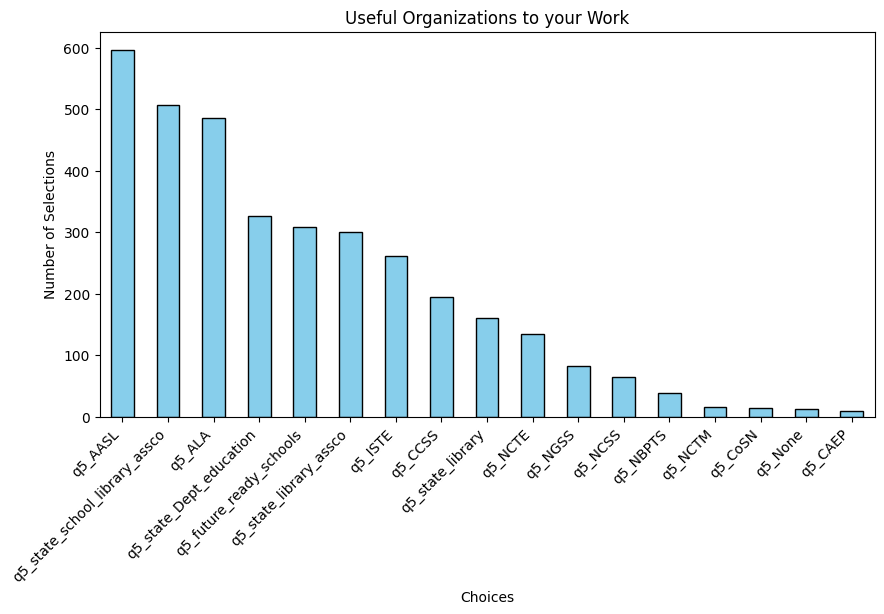

In [27]:
choice_counts = df.iloc[:, 5:22].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
choice_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.xlabel("Choices")
plt.ylabel("Number of Selections")
plt.title("Useful Organizations to your Work")
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.show()

In [28]:
grouped = df.groupby(df.iloc[:, 0])[df.iloc[:, 5:22].columns].sum()
for job_role, row in grouped.iterrows():
    top_3 = row.sort_values(ascending=False).head(3)
    print(f"Job Role: {job_role}")
    print(top_3)
    print("-" * 40)

Job Role: Certified / licensed school librarian
q5_AASL                          540
q5_state_school_library_assco    461
q5_ALA                           432
Name: Certified / licensed school librarian, dtype: object
----------------------------------------
Job Role: Educational library professionals
q5_ALA                           13
q5_AASL                          11
q5_state_school_library_assco    10
Name: Educational library professionals, dtype: object
----------------------------------------
Job Role: School library student
q5_ALA                           10
q5_AASL                           9
q5_state_school_library_assco     7
Name: School library student, dtype: object
----------------------------------------
Job Role: School library supervisor
q5_AASL                          31
q5_ALA                           27
q5_state_school_library_assco    25
Name: School library supervisor, dtype: object
----------------------------------------
Job Role: State/DOE employee
q5_AAS

In [29]:
group_columns = df_grade.iloc[:, 1:5]
sum_columns = df_grade.iloc[:, 5:22]

grouped_results = {}
for col in group_columns.columns:
    grouped_sum = df_grade.groupby(col)[sum_columns.columns].sum()

    # Sort and get top 3 columns for each group row manually
    top_3 = grouped_sum.apply(lambda row: row.sort_values(ascending=False).head(3), axis=1)

    # Only include results where col == 1 (respondents who selected that school level)
    if 1 in top_3.index:
        grouped_results[col] = top_3.loc[1]

# Print results
for col, result in grouped_results.items():
    print(f"Top 3 responses for: {col}")
    print(result)
    print("\n")


Top 3 responses for: Elementary School
q5_AASL                          252
q5_state_school_library_assco    209
q5_ALA                           196
Name: 1, dtype: int64


Top 3 responses for: Junior High School
q5_AASL                          172
q5_state_school_library_assco    148
q5_ALA                           138
Name: 1, dtype: int64


Top 3 responses for: High School
q5_AASL                          224
q5_state_school_library_assco    196
q5_ALA                           184
Name: 1, dtype: int64


Top 3 responses for: Multiple Buildings
q5_AASL                          43
q5_state_school_library_assco    42
q5_ALA                           37
Name: 1, dtype: int64




No distinction between school grades.

- `q8`: Were you aware that AASL revised and published *the Standards*

**90.3% of librarians are aware that the Standards has beeen reivsed.**

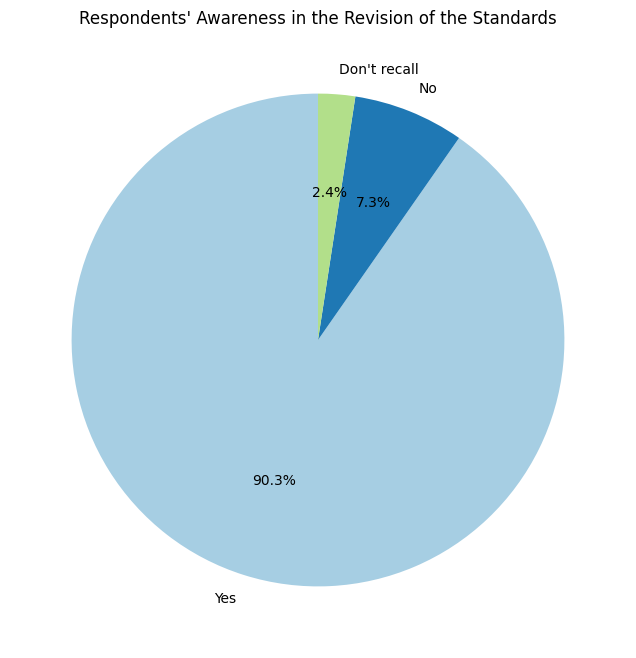

In [30]:
data = df.iloc[:, 24].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(data, labels=data.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title("Respondents' Awareness in the Revision of the Standards")
plt.show()

- `q9`: Have you purchased *the Standards*?

**Among all these five job role groups, larger percentage of respondents didn't purchase the book.**

In [31]:
purchase_counts = df.groupby([df.iloc[:, 0], df.iloc[:, 25]]).size().unstack(fill_value=0)

purchase_percentage = purchase_counts.div(purchase_counts.sum(axis=1), axis=0) * 100
purchase_percentage = purchase_percentage.map(lambda x: f"{x:.2f}%")
purchase_percentage

purchase,No,"Yes, I purchased the book.","Yes, it was purchased for me by my district or other organization."
jobRole,,,
Certified / licensed school librarian,41.43%,33.02%,25.56%
Educational library professionals,89.47%,5.26%,5.26%
School library student,50.00%,50.00%,0.00%
School library supervisor,35.14%,35.14%,29.73%
State/DOE employee,40.00%,20.00%,40.00%


- `q10`: Do you currently use *the Standards* in your practice?

**75.94% of respondents use the Standards in conjunction with other standards. When broken down by job role, all roles, except for educational library professionals, use the stadards. Educational library professionals, on the other hand, do not use standards to shape their practice.**

In [32]:
value_counts = df.iloc[:, 26].value_counts()
value_counts

q10_currently_use
Yes, I use them in conjunction with other standards.                       527
No, I do not use standards to shape my practice.                            76
No, I use other standards in my professional practice (please specify).     61
Yes, I use them exclusively.                                                30
Name: count, dtype: int64

In [33]:
use_counts = df.groupby([df.iloc[:, 0], df.iloc[:, 26]]).size().unstack(fill_value=0)

use_percentage = use_counts.div(use_counts.sum(axis=1), axis=0) * 100
use_percentage = use_percentage.map(lambda x: f"{x:.2f}%")
use_percentage

q10_currently_use,"No, I do not use standards to shape my practice.","No, I use other standards in my professional practice (please specify).","Yes, I use them exclusively.","Yes, I use them in conjunction with other standards."
jobRole,,,,
Certified / licensed school librarian,8.99%,8.99%,4.65%,77.37%
Educational library professionals,57.89%,10.53%,0.00%,31.58%
School library student,30.00%,0.00%,10.00%,60.00%
School library supervisor,13.51%,8.11%,0.00%,78.38%
State/DOE employee,20.00%,0.00%,0.00%,80.00%


**When broken down by school grades, the majority of licensed school librarians in these four grades use the Standards in conjunction with other Standards. Multiple buildings librarians have the highest percentage of not using standards to shape their practice, and elementary school librarians have the least percentage.**

In [34]:
# Elementary School
filtered_df = df_grade[df_grade['Elementary School'] == 1]

percentage = filtered_df.iloc[:, 26].value_counts(normalize=True) * 100
percentage = percentage.round(2).astype(str) + '%'
percentage

q10_currently_use
Yes, I use them in conjunction with other standards.                       76.24%
No, I use other standards in my professional practice (please specify).    11.22%
No, I do not use standards to shape my practice.                            6.93%
Yes, I use them exclusively.                                                5.61%
Name: proportion, dtype: object

In [35]:
# Junior High School
filtered_df = df_grade[df_grade['Junior High School'] == 1]

percentage = filtered_df.iloc[:, 26].value_counts(normalize=True) * 100
percentage = percentage.round(2).astype(str) + '%'
percentage

q10_currently_use
Yes, I use them in conjunction with other standards.                       79.37%
No, I do not use standards to shape my practice.                           10.05%
No, I use other standards in my professional practice (please specify).     6.35%
Yes, I use them exclusively.                                                4.23%
Name: proportion, dtype: object

In [36]:
# High School
filtered_df = df_grade[df_grade['High School'] == 1]

percentage = filtered_df.iloc[:, 26].value_counts(normalize=True) * 100
percentage = percentage.round(2).astype(str) + '%'
percentage

q10_currently_use
Yes, I use them in conjunction with other standards.                       78.35%
No, I do not use standards to shape my practice.                           11.02%
No, I use other standards in my professional practice (please specify).     7.09%
Yes, I use them exclusively.                                                3.54%
Name: proportion, dtype: object

In [37]:
# Multiple Buildings
filtered_df = df_grade[df_grade['Multiple Buildings'] == 1]

percentage = filtered_df.iloc[:, 26].value_counts(normalize=True) * 100
percentage = percentage.round(2).astype(str) + '%'
percentage

q10_currently_use
Yes, I use them in conjunction with other standards.                       73.08%
No, I do not use standards to shape my practice.                           13.46%
No, I use other standards in my professional practice (please specify).    11.54%
Yes, I use them exclusively.                                                1.92%
Name: proportion, dtype: object

- `q11`: What made you choose to use standards other than the AASL Standards?

**For those who use other standards in their professional practice, the top two reasons for them to not use AASL standards is "they are expected to use these standards by their school district", and "these standards feel more accessible to them".**

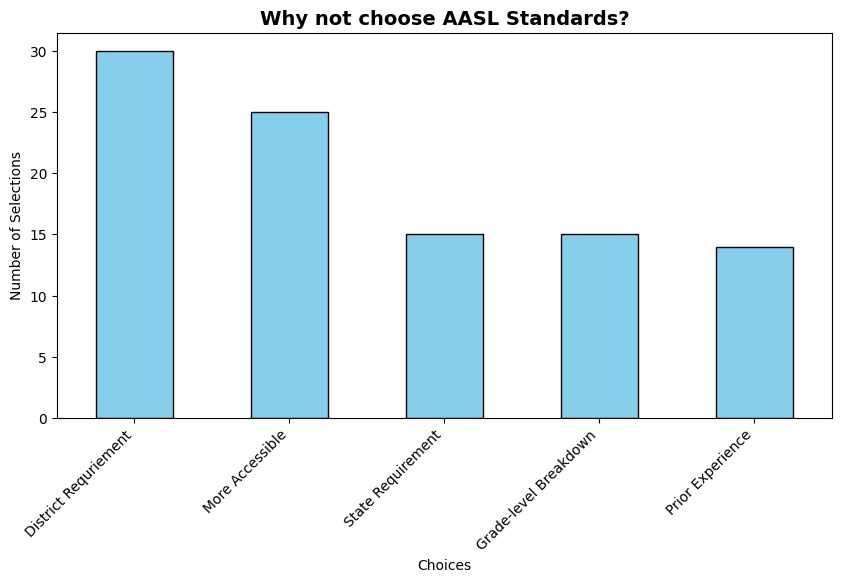

In [38]:
choice_counts = df.iloc[:, 28:33].sum().sort_values(ascending=False)
custom_labels = {
    "reason_not_use_school": "District Requriement",
    "reason_not_use_accessible": "More Accessible",
    "reason_not_use_state": "State Requirement",
    "reason_not_use_broken_down": "Grade-level Breakdown",
    "reason_not_use_prior_exp": "Prior Experience"
}
x_labels = [custom_labels[col] for col in choice_counts.index]
plt.figure(figsize=(10, 5))
choice_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.xlabel("Choices")
plt.ylabel("Number of Selections")
plt.title("Why not choose AASL Standards?", fontsize=14, fontweight='bold')
plt.xticks(ticks=range(len(x_labels)), labels=x_labels, rotation=45, ha='right')  # Rotate labels for better readability
plt.show()

**Broken down by job roles, we found that for certified/licensed school librarian, the top 2 reasons for them to use another standards because the schools tell them so and those standards feel more accessible to them. For school library supervisor it's also because of they are required to use those standards by their state department of Education.**

In [39]:
grouped = df.groupby(df.iloc[:, 0])[df.iloc[:, 28:33].columns].sum()
for job_role, row in grouped.iterrows():
    top_2 = row.sort_values(ascending=False).head(2)
    print(f"Job Role: {job_role}")
    print(top_2)
    print("-" * 40)

Job Role: Certified / licensed school librarian
reason_not_use_school        28
reason_not_use_accessible    24
Name: Certified / licensed school librarian, dtype: object
----------------------------------------
Job Role: Educational library professionals
reason_not_use_school    0
reason_not_use_state     0
Name: Educational library professionals, dtype: object
----------------------------------------
Job Role: School library student
reason_not_use_school    0
reason_not_use_state     0
Name: School library student, dtype: object
----------------------------------------
Job Role: School library supervisor
reason_not_use_school    2
reason_not_use_state     2
Name: School library supervisor, dtype: object
----------------------------------------
Job Role: State/DOE employee
reason_not_use_school    0
reason_not_use_state     0
Name: State/DOE employee, dtype: object
----------------------------------------


To analyze open-ended questions, we tried several methods that can capture the best semantic similarities for us, for example, two respondents saying "I can't apply it to my practical work" and "This standards is too theoretical" should be clustered in one group because they are all saying the same meaning. We tried the following methods:
- Hugging Face model `sentence-transformers`: dragged us to dependency hell and we basically had to create another new virtual environment just because trying to install this model in our environment did so much damage.
- TF-IDF + cosine similarity: only considers word overlap and doesn't capture meaning or paraphrasing.
- SpaCy + pretrained medium model: using `en_core_web_md` that contains pretrained word vectors---dense, numerical representations of words trained on large text corpora. Words like "practical", "applicable", and "real-world" will have very similar vectors, and words like "standads", "guidelines", and "framewords" will also be close. This allows the model to detect semantic similarity even if the exact words differ. On the other hand, SpaCy creates a vector for a full sentence by averaging the word vectors of non-stopwords, ignoring punctuation, stopwords, and rarely meaningful tokens, giving a sentence-level vector that roughly captures the overall meaning. Once each sentence is a vector, SpaCy uses cosine similarity to measure how similar they are. Issue appeared here is that it can only give a similarity rating for us, but we still need to manually read those sentences and summarize a shared theme or opinion for them, which is not effective when the number of responses are large. Additionally, some questions asked in a way that are praising the other standards but are implying the AASL standards are not satisfying, which will be wrongly interpreted buy this algorithm.
- OpenAI. We shared the sentences directly on OpenAI's interface and used the model GPT-4.5 to help us mark themes. We are not using the OpenAI API is because they are charged separately so we don't think it would be efficient for us to spend another amount of money on that.

In [40]:
filtered_df = df[df['jobRole'] == 'Certified / licensed school librarian']
reasons = filtered_df.iloc[:, 33].dropna().to_list()
reasons

['The AASL ones are overly comprehensive - I focus on research skills',
 '2 reasons: collaboration and new AASL standards are hideously complicated and hard to connect with real world practice',
 'They are easier to implement. Current AASL standards are really, really, overwhelming. Also, current AASL standards seem more theoretical than practical. I want specific benchmarks that my students should meet, not ideals. ',
 'More specific targets for learning',
 'I wanted to standards specific to my state.',
 "AASL were paywalled, therefore couldn't easily be shared with other educators or with families. The framework was also too complicated to easily explain to students or colleagues. ",
 'These were the only standards I was aware of.',
 'I was under the impression that these are the standards that we have to use.',
 "I don't know",
 'I vehemently dislike these new standards. The ones prior to the revision were much better, IMO.',
 'AASL standards are difficult to navigate',
 'These stan

The prompt we used when interacting with OpenAI was:

prompt = f"""
You are analyzing survey responses to this question: 
"What made you choose to use standards other than the AASL standards?"

Here are 20 real user responses:
{formatted}

Please:
1. Identify and summarize the main **shared ideas or concerns** these responses express.
2. Mention any **unique ideas** that were raised by only one person but still offer value.
3. Present your summary in bullet points, clearly separating common themes and unique insights.
"""

**Overall, the common themes and shared concerns are**
- Complexity and overwhelming Nature
    "overly comprehensive", "complicated", "difficult to navigate", "overwhelming".
- Lack of practicality
    "Too theoretical", respondents preferred standards are "specific", "tangible", or "easier to implement"
- Usibility issue
    "not user friendly", "redundant"
- Paywall


In [41]:
download('opinion_lexicon')

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\Katrina_gao\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


True

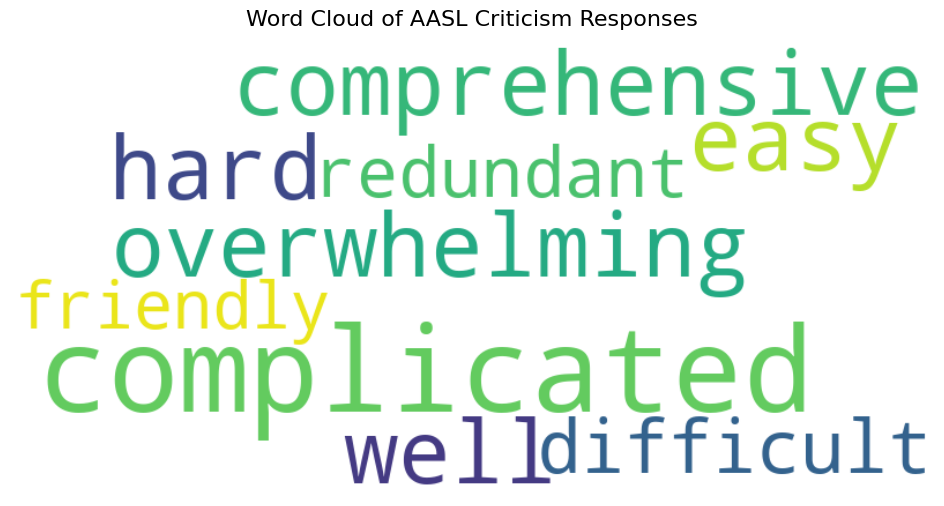

In [42]:
nlp = spacy.load("en_core_web_md")

filtered_df = df[df['jobRole'] == 'Certified / licensed school librarian']
responses = filtered_df.iloc[:, 33].dropna().to_list()

all_text = " ".join(responses)
doc = nlp(all_text)


positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

# Then filter adjectives like this:
emotional_adjs = [token.lemma_ for token in doc if (
    token.pos_ == "ADJ" and
    token.lemma_.lower() in positive_words.union(negative_words)
)]

# Rejoin for word cloud input
filtered_text = " ".join(emotional_adjs)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(filtered_text)

# Display it
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of AASL Criticism Responses", fontsize=16)
plt.show()


It has some good words on it because the question asked respondents "why they use other standards but not AASL", so those good words could be used to describe the merits of other standards and implying which parts AASL's standards could be improved on.

In [43]:
filtered_df = df[df['jobRole'] == 'School library supervisor']
reasons = filtered_df.iloc[:, 33].dropna().to_list()
reasons

["Free; don't have to buy an expensive book to get all the details"]

In [44]:
filtered_df = df[df['jobRole'] == 'Educational library professionals']
reasons = filtered_df.iloc[:, 33].dropna().to_list()
reasons

['Teacher recommendation',
 'Past practice, every just doing what they have always done']

In [45]:
filtered_df = df[df['jobRole'] == 'School library student']
reasons = filtered_df.iloc[:, 33].dropna().to_list()
reasons

[]

In [46]:
filtered_df = df[df['jobRole'] == 'State/DOE employee']
reasons = filtered_df.iloc[:, 33].dropna().to_list()
reasons

[]

- `q12`: How are you accessing the *National School Library Standards*?

**People access the AASL Standards mostly by the downloadable framework for learners and materials from the AASL Standards web portal, their own copies of the book, and AASL standards frameworks poster.**

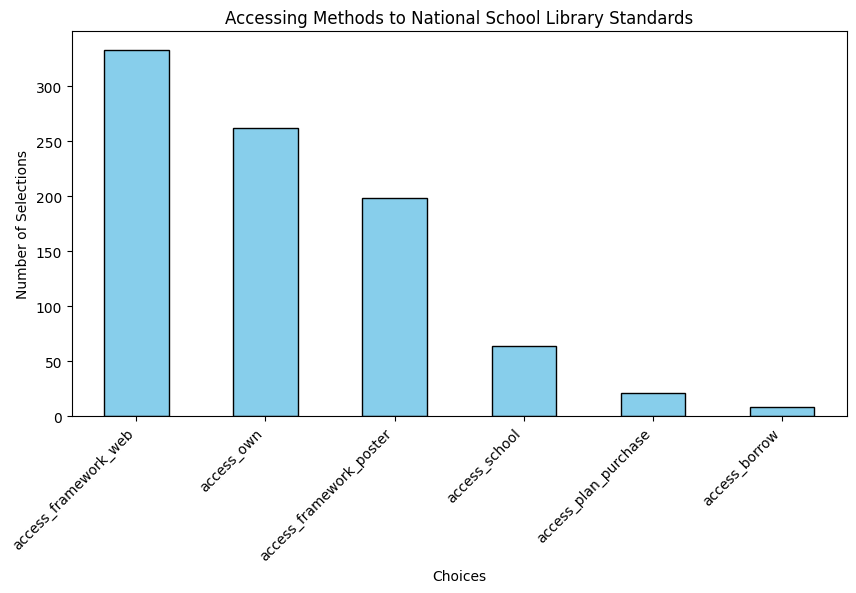

In [47]:
choice_counts = df.iloc[:, 34:40].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
choice_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.xlabel("Choices")
plt.ylabel("Number of Selections")
plt.title("Accessing Methods to National School Library Standards")
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.show()

In [48]:
grouped = df.groupby(df.iloc[:, 0])[df.iloc[:, 34:40].columns].sum()
for job_role, row in grouped.iterrows():
    top_2 = row.sort_values(ascending=False).head(2)
    print(f"Job Role: {job_role}")
    print(top_2)
    print("-" * 40)

Job Role: Certified / licensed school librarian
access_framework_web    308
access_own              238
Name: Certified / licensed school librarian, dtype: object
----------------------------------------
Job Role: Educational library professionals
access_framework_web       5
access_framework_poster    2
Name: Educational library professionals, dtype: object
----------------------------------------
Job Role: School library student
access_own       4
access_borrow    1
Name: School library student, dtype: object
----------------------------------------
Job Role: School library supervisor
access_own              18
access_framework_web    17
Name: School library supervisor, dtype: object
----------------------------------------
Job Role: State/DOE employee
access_own              2
access_framework_web    2
Name: State/DOE employee, dtype: object
----------------------------------------


In [49]:
q12_others = df.iloc[:, 40].dropna().tolist()
q12_others

['Online access ',
 'The App on my phone',
 'I have the app as well',
 'Through collaborating with fellow library colleagues at PD',
 "My performance is assessed through my state's standards for media specialists.",
 'It is cost prohibitive for me. ',
 'I find them cited or referenced in other forums (online)',
 'I use the frameworks booklet',
 'App',
 'State Education Website',
 'I mostly use the MSLA standards',
 'I also use the AASL standards app on my iPhone',
 "I'm retired, but would purchase if still teaching in the library",
 'Through NCEES',
 "I primarily use the state of KY's Media Library Standards which consulted the National Library Standards when they were adopted. ",
 'My district purchased the App.',
 'State library standard',
 'The Nevada Academic Content Standards (NVACS) K-12 Library Standards for Information Literacy are based on the National School Library Standards for Learners.',
 'other districts share with me at my district association meetings.',
 'I would love

In [50]:
# Load model
nlp = spacy.load("en_core_web_md")

# Get your open-ended reasons
filtered_df = df[df['jobRole'] == 'Certified / licensed school librarian']
reasons = filtered_df.iloc[:, 33].dropna().to_list()

# Store all adjectives and important nouns
descriptors = []

for reason in q12_others:
    doc = nlp(reason.lower())
    for token in doc:
        # Filter for adjectives or useful nouns (skip stop words & punctuation)
        if token.pos_ in ["NOUN", "ADJ"] and not token.is_stop and token.is_alpha:
            descriptors.append(token.lemma_)

# Count frequency of descriptors
desc_counts = Counter(descriptors)
top_terms = [word for word, count in desc_counts.items() if count >= 2]

# Convert terms to vectors
vectors = np.array([nlp(word).vector for word in top_terms if nlp(word).has_vector])

# Cluster them using cosine similarity
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0.4, metric='cosine', linkage='average')
labels = clustering.fit_predict(vectors)

# Group terms by cluster
clusters = {}
for i, label in enumerate(labels):
    clusters.setdefault(label, []).append(top_terms[i])

# Display clusters
print("Key Thematic Clusters (adjectives & nouns):")
for label, terms in clusters.items():
    print(f"Cluster {label+1}: {', '.join(terms)}")


Key Thematic Clusters (adjectives & nouns):
Cluster 6: online
Cluster 1: app, library
Cluster 5: state
Cluster 7: standard
Cluster 4: medium
Cluster 2: district
Cluster 3: school


Analyzing the open-ended questions and the survey results, it seems that most people would use the condense free online version of the AASL Standards---the web framework, as well as the app. Even so, half of the licensed school librarians and library supervisor own their own copies of the book.

- `q13`: How familiar are you with the content of the *National School Library Standards for Learners, School Librarians, and School Libraries*?

**Most people are somewhat familiar or very familiar with the Standards. However, educational library professionals have a noticeable number of respondents who are not at all familiar with the Standards.**


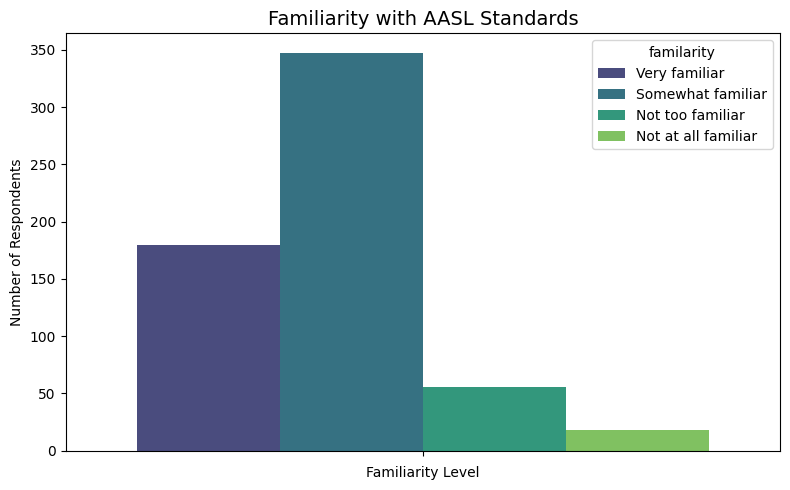

In [51]:
familiarity_series = df.iloc[:, 41].dropna()

# Count responses and order them meaningfully
order = ["Very familiar", "Somewhat familiar", "Not too familiar", "Not at all familiar"]
counts = familiarity_series.value_counts().reindex(order)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(hue=counts.index, y=counts.values, palette="viridis")

# Add labels
plt.title("Familiarity with AASL Standards", fontsize=14)
plt.ylabel("Number of Respondents")
plt.xlabel("Familiarity Level")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


In [52]:
value_counts = df.iloc[:, 41].value_counts()
value_counts

familarity
Somewhat familiar      347
Very familiar          180
Not too familiar        56
Not at all familiar     18
Name: count, dtype: int64

In [53]:
familiar_counts = df.groupby([df.iloc[:, 0], df.iloc[:, 41]]).size().unstack(fill_value=0)

familiar_percentage = familiar_counts.div(familiar_counts.sum(axis=1), axis=0) * 100
familiar_percentage = familiar_percentage.map(lambda x: f"{x:.2f}%")
familiar_percentage

familarity,Not at all familiar,Not too familiar,Somewhat familiar,Very familiar
jobRole,,,,
Certified / licensed school librarian,2.90%,9.06%,58.51%,29.53%
Educational library professionals,28.57%,0.00%,71.43%,0.00%
School library student,0.00%,14.29%,42.86%,42.86%
School library supervisor,0.00%,12.90%,51.61%,35.48%
State/DOE employee,0.00%,25.00%,0.00%,75.00%


Broken down by school grade

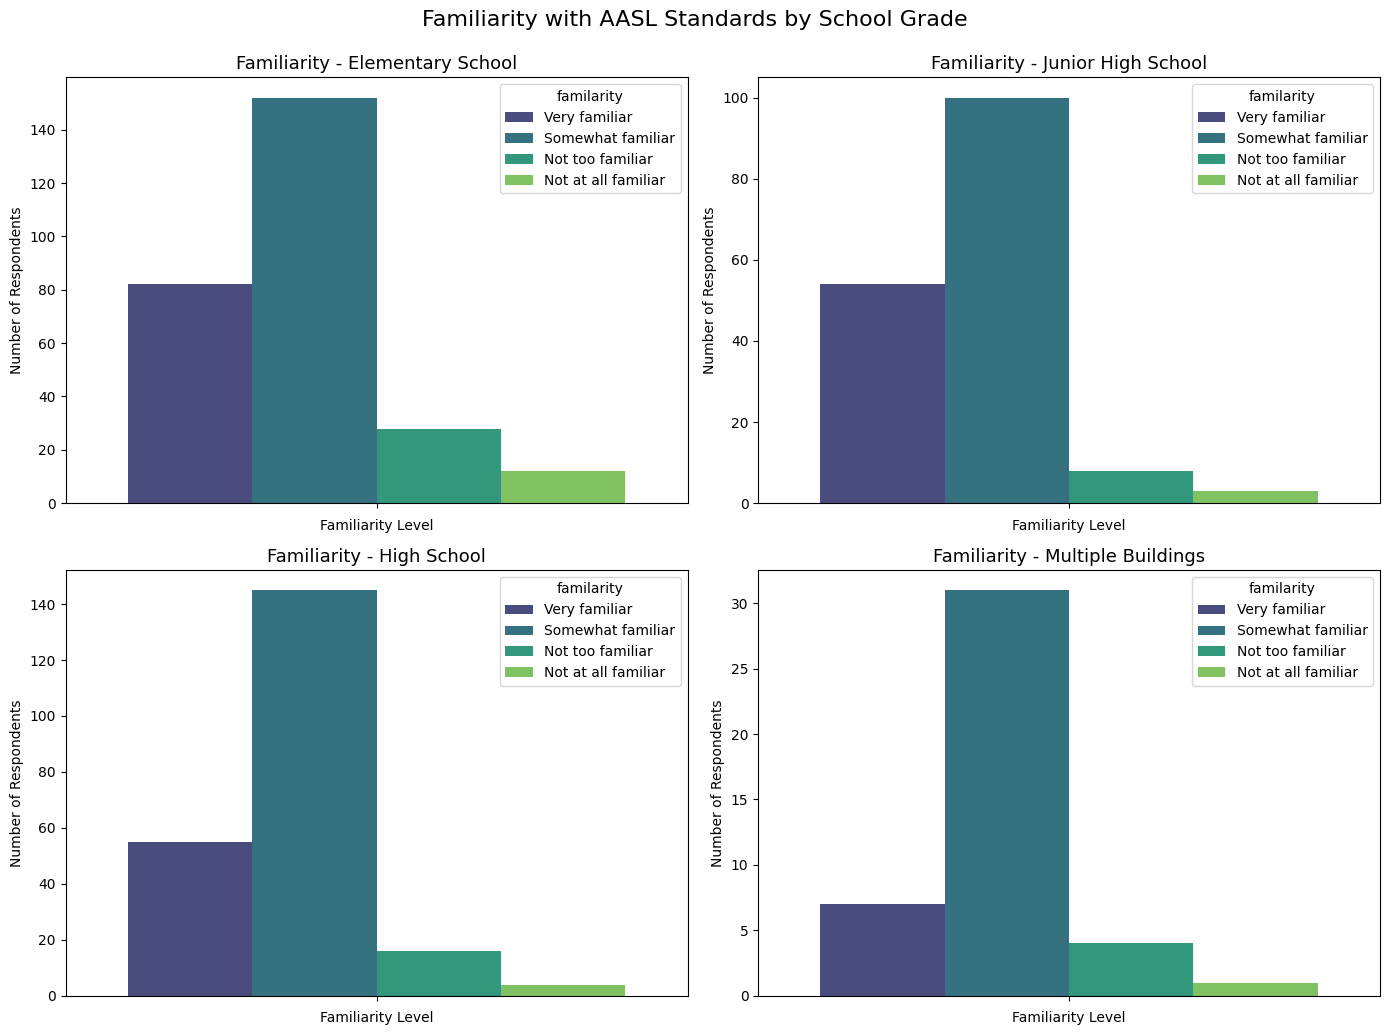

In [54]:
grade_columns = df_grade.iloc[:, 1:5]
grade_names = grade_columns.columns.tolist()

# Get the familiarity column
familiarity_col = df_grade.iloc[:, 41]

# Define the order of categories
familiarity_order = ["Very familiar", "Somewhat familiar", "Not too familiar", "Not at all familiar"]

# Create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Loop through each grade
for i, col in enumerate(grade_names):
    # Filter rows where this grade is selected (value == 1)
    filtered = df_grade[df_grade[col] == 1]
    fam_values = filtered.iloc[:, 41].dropna()
    
    # Count and reindex to enforce order
    counts = fam_values.value_counts().reindex(familiarity_order, fill_value=0)

    # Plot in the corresponding subplot
    sns.barplot(ax=axes[i], hue=counts.index, y=counts.values, palette="viridis")
    axes[i].set_title(f"Familiarity - {col}", fontsize=13)
    axes[i].set_ylabel("Number of Respondents")
    axes[i].set_xlabel("Familiarity Level")
    axes[i].tick_params(axis='x', rotation=20)

# Adjust layout
plt.tight_layout()
plt.suptitle("Familiarity with AASL Standards by School Grade", fontsize=16, y=1.03)
plt.show()

- `q14`: Overall, how would you rate the National School Library Standards?

**Most people have good opinions on the Standards.**

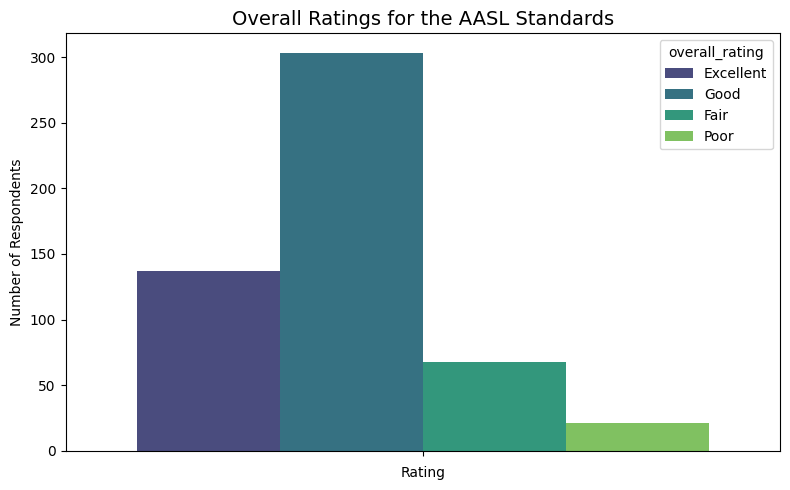

In [55]:
rate_series = df.iloc[:, 42].dropna()

# Count responses and order them meaningfully
order = ["Excellent", "Good", "Fair", "Poor"]
counts = rate_series.value_counts().reindex(order)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(hue=counts.index, y=counts.values, palette="viridis")

# Add labels
plt.title("Overall Ratings for the AASL Standards", fontsize=14)
plt.ylabel("Number of Respondents")
plt.xlabel("Rating")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


In [56]:
value_counts = df.iloc[:, 42].value_counts()
value_counts

overall_rating
Good         303
Excellent    137
Fair          68
Poor          21
Name: count, dtype: int64

In [57]:
rating_counts = df.groupby([df.iloc[:, 0], df.iloc[:, 42]]).size().unstack(fill_value=0)

rating_percentage = rating_counts.div(rating_counts.sum(axis=1), axis=0) * 100
rating_percentage = rating_percentage.map(lambda x: f"{x:.2f}%")
rating_percentage

overall_rating,Excellent,Fair,Good,Poor
jobRole,,,,
Certified / licensed school librarian,26.02%,12.70%,57.17%,4.10%
Educational library professionals,0.00%,0.00%,100.00%,0.00%
School library student,33.33%,16.67%,50.00%,0.00%
School library supervisor,25.93%,14.81%,55.56%,3.70%
State/DOE employee,33.33%,33.33%,33.33%,0.00%


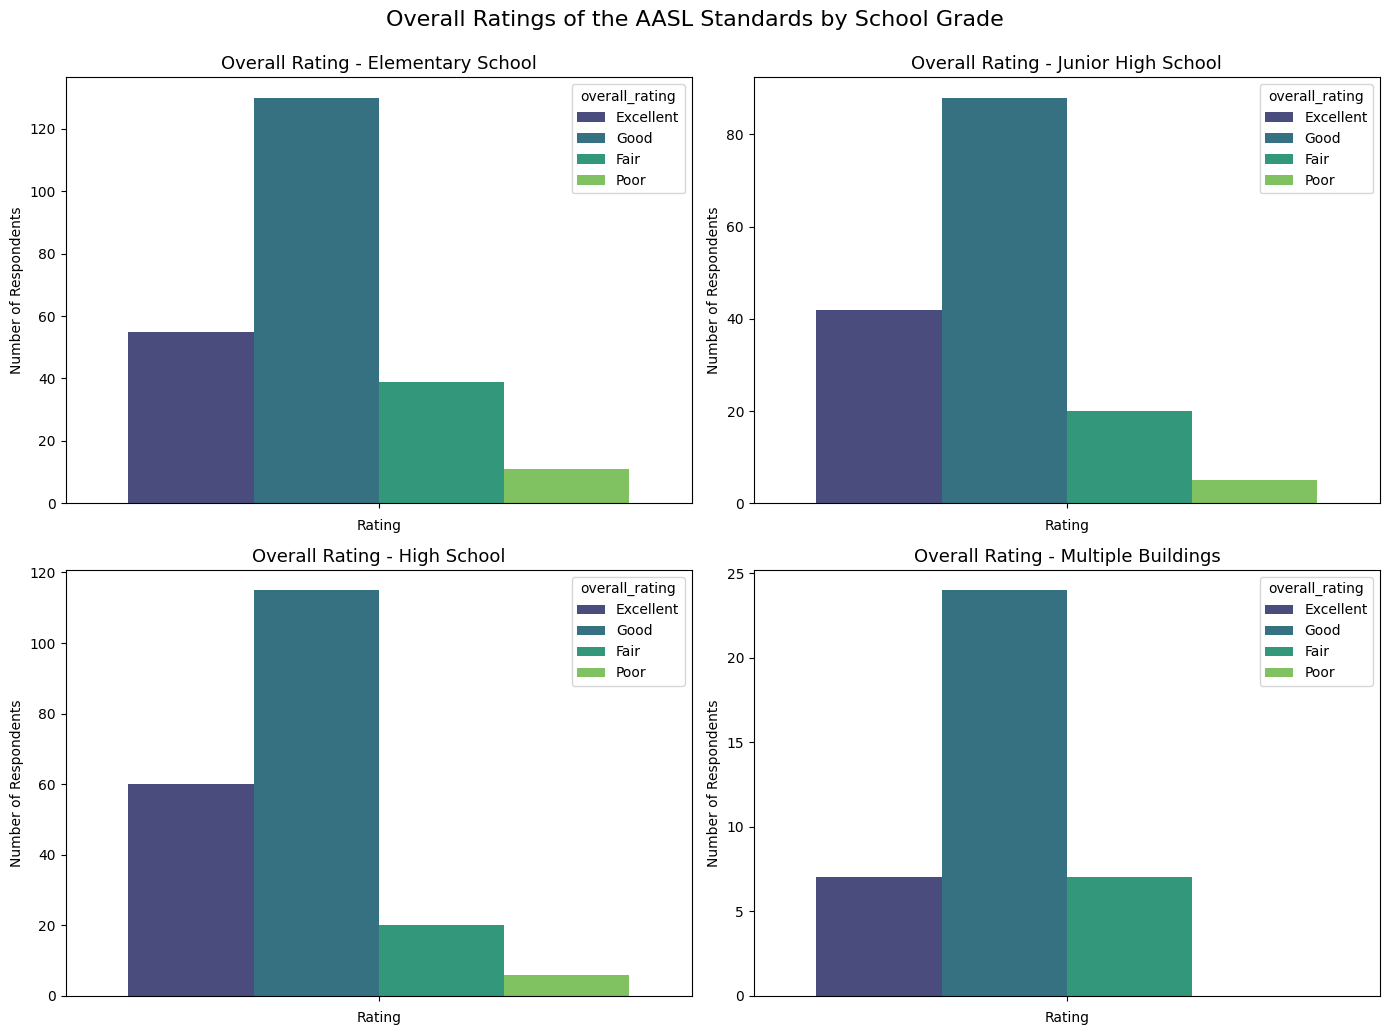

In [58]:
grade_columns = df_grade.iloc[:, 1:5]
grade_names = grade_columns.columns.tolist()

# Get the familiarity column
rating_col = df_grade.iloc[:, 42]

# Define the order of categories
rating_order = ["Excellent", "Good", "Fair", "Poor"]

# Create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Loop through each grade
for i, col in enumerate(grade_names):
    # Filter rows where this grade is selected (value == 1)
    filtered = df_grade[df_grade[col] == 1]
    fam_values = filtered.iloc[:, 42].dropna()
    
    # Count and reindex to enforce order
    counts = fam_values.value_counts().reindex(rating_order, fill_value=0)

    # Plot in the corresponding subplot
    sns.barplot(ax=axes[i], hue=counts.index, y=counts.values, palette="viridis")
    axes[i].set_title(f"Overall Rating - {col}", fontsize=13)
    axes[i].set_ylabel("Number of Respondents")
    axes[i].set_xlabel("Rating")
    axes[i].tick_params(axis='x', rotation=20)

# Adjust layout
plt.tight_layout()
plt.suptitle("Overall Ratings of the AASL Standards by School Grade", fontsize=16, y=1.03)
plt.show()

- `q22`: How frequently do you use or refer to the content in the book?

**All job roles don't consult the book very often, as there are quite a big percentage of people who rarely or never refer to the Standards.**

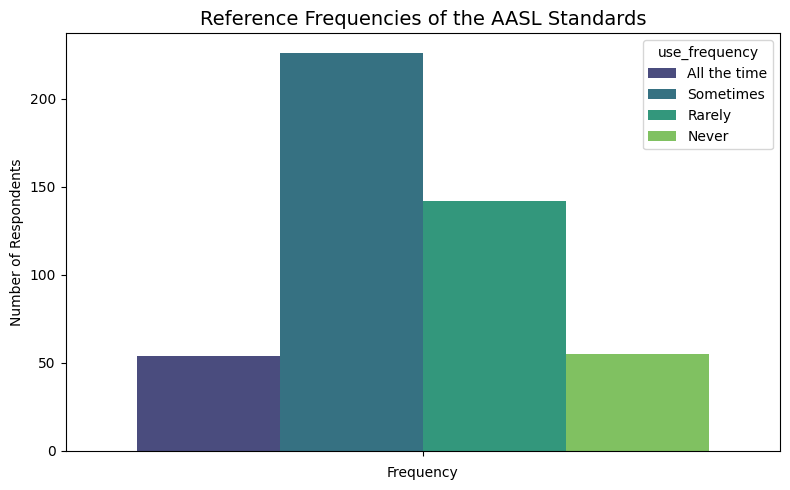

In [59]:
rate_series = df.iloc[:, 74].dropna()

# Count responses and order them meaningfully
order = ["All the time", "Sometimes", "Rarely", "Never"]
counts = rate_series.value_counts().reindex(order)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(hue=counts.index, y=counts.values, palette="viridis")

# Add labels
plt.title("Reference Frequencies of the AASL Standards", fontsize=14)
plt.ylabel("Number of Respondents")
plt.xlabel("Frequency")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


In [60]:
value_counts = df.iloc[:, 74].value_counts()
value_counts

use_frequency
Sometimes       226
Rarely          142
Never            55
All the time     54
Name: count, dtype: int64

In [61]:
frequency_counts = df.groupby([df.iloc[:, 0], df.iloc[:, 74]]).size().unstack(fill_value=0)

frequency_percentage = frequency_counts.div(frequency_counts.sum(axis=1), axis=0) * 100
frequency_percentage = frequency_percentage.map(lambda x: f"{x:.2f}%")
frequency_percentage

use_frequency,All the time,Never,Rarely,Sometimes
jobRole,,,,
Certified / licensed school librarian,10.98%,11.44%,30.43%,47.14%
Educational library professionals,0.00%,0.00%,50.00%,50.00%
School library student,14.29%,14.29%,28.57%,42.86%
School library supervisor,15.38%,15.38%,15.38%,53.85%
State/DOE employee,33.33%,0.00%,33.33%,33.33%


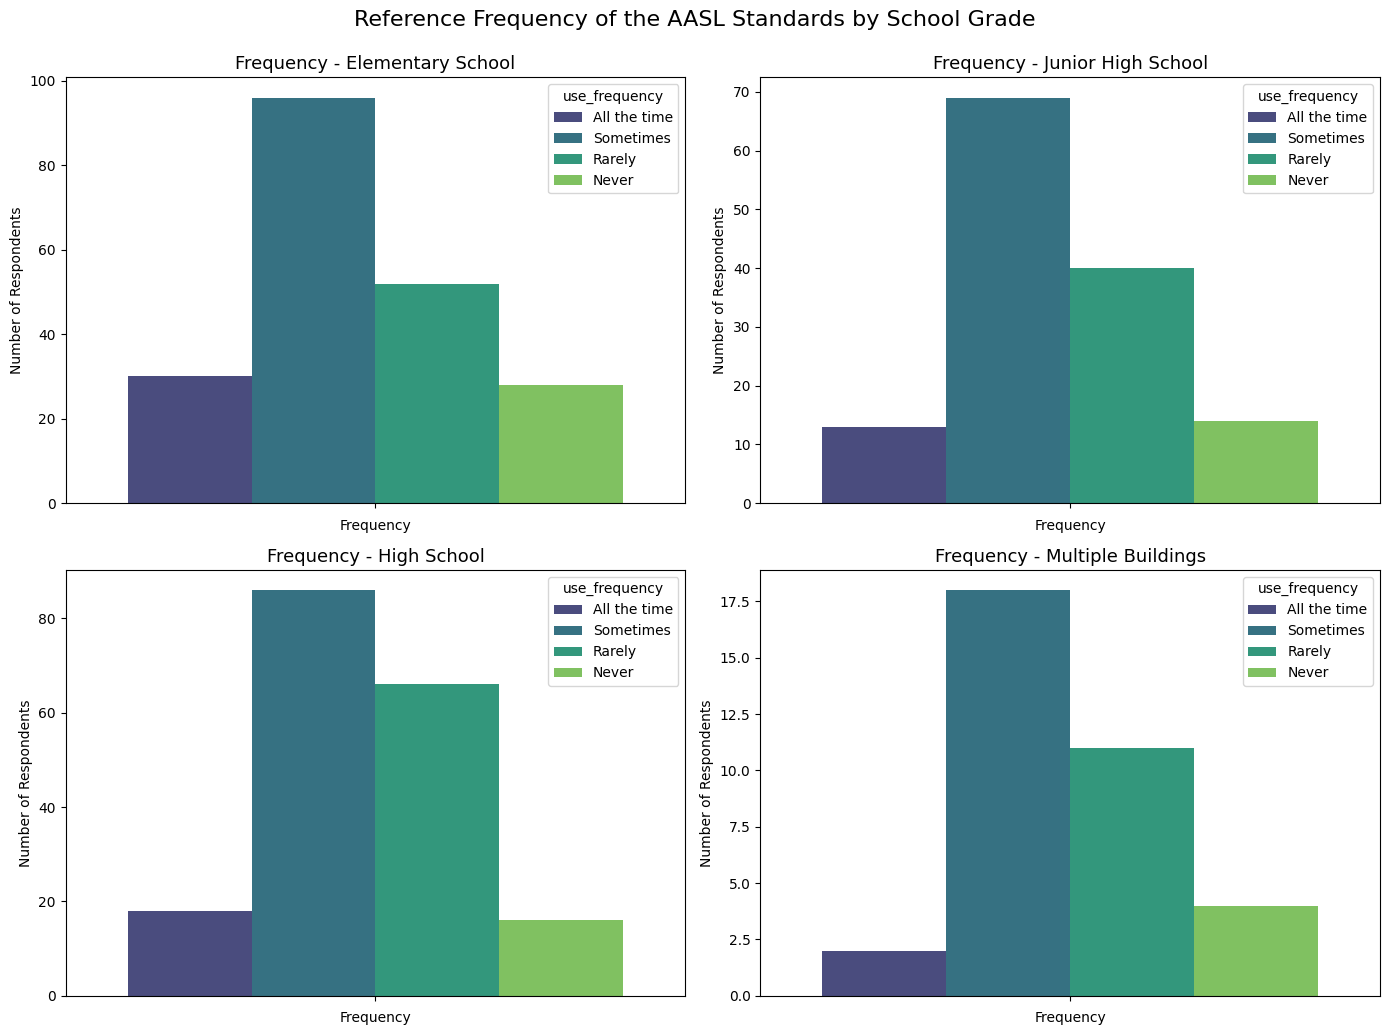

In [62]:
grade_columns = df_grade.iloc[:, 1:5]
grade_names = grade_columns.columns.tolist()

# Get the familiarity column
frequency_col = df_grade.iloc[:, 74]

# Define the order of categories
order = ["All the time", "Sometimes", "Rarely", "Never"]

# Create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Loop through each grade
for i, col in enumerate(grade_names):
    # Filter rows where this grade is selected (value == 1)
    filtered = df_grade[df_grade[col] == 1]
    fre_values = filtered.iloc[:, 74].dropna()
    
    # Count and reindex to enforce order
    counts = fre_values.value_counts().reindex(order, fill_value=0)

    # Plot in the corresponding subplot
    sns.barplot(ax=axes[i], hue=counts.index, y=counts.values, palette="viridis")
    axes[i].set_title(f"Frequency - {col}", fontsize=13)
    axes[i].set_ylabel("Number of Respondents")
    axes[i].set_xlabel("Frequency")
    axes[i].tick_params(axis='x', rotation=20)

# Adjust layout
plt.tight_layout()
plt.suptitle("Reference Frequency of the AASL Standards by School Grade", fontsize=16, y=1.03)
plt.show()

- `q23`: How useful to you are each of the following book elements in your work? (Potentially group by chapters)

**Sections that respondents found most useful are (top 5)**
- `Part 1: Alignments for School Libraries`
- `Part 2 Integrated Frameworks by Shared Foundation [Inquire, Include, Collaborate, Curate, Explore, Engage]`
- `Part 1: Competencies for Learners`
- `Part 2: Framework Best Practices`
- `Part 3: Chapter 14: Evaluating School Libraries Discussion of responsibilities at the school, district, and state level`

**Sections that respondents found least useful are (bottom 5)**
- `Appendices - Lists of Illustrations`
- `Appendices - Work Cited`
- `Appendices - Suggested Further Reading`
- `Appendices - Useful Verbs`
- `Appendices - Index`

In [63]:
ratings = df_q23.iloc[:, 1:21]

# Sum each column
average = ratings.mean()

# Get top 5 highest
top_5 = average.sort_values(ascending=False).head(5)

# Get the lowest 5
bottom_5 = average.sort_values().head(5)

# Print results
print("Top 5 Most Valued Parts of the Standards:")
print(top_5)

print("5 Least Valued Part of the Standards:")
print(bottom_5)


Top 5 Most Valued Parts of the Standards:
p1_Alignments for School Libraries.                                                                        1.29375
p2_Integrated Frameworks by Shared Foundation [Inquire, Include, Collaborate, Curate, Explore, Engage]       1.275
p1_Competencies for Learners.                                                                              1.15625
p2_Framework Best Practices.                                                                                  1.15
p3_chap14_Evaluating School Libraries School Library Evaluation Checklist.                                1.129167
dtype: object
5 Least Valued Part of the Standards:
a_Lists of Illustrations       0.227083
a_Works Cited                   0.33125
a_Suggested Further Reading    0.452083
a_Useful Verbs                  0.55625
a_Index                        0.595833
dtype: object


**When group by parts, we found that Part 2 is the most useful part and Appendices is the least useful part. Another good news is they are scored on a scale of -2 to 2, so all possitive numbers mean overall respondengts are findings most of them useful.** 

In [64]:
ratings = df_q23.iloc[:, 1:21]

# Create a mapping from column to part using regex
part_groups = {
    'p1': [],
    'p2': [],
    'p3': [],
    'p4': [],
    'a': []
}

for col in ratings.columns:
    match = re.match(r'^(p1|p2|p3|p4|a)', col)
    if match:
        part = match.group(1)
        part_groups[part].append(col)

# Calculate average score for each part
part_averages = {}

for part, cols in part_groups.items():
    if cols:
        part_averages[part] = ratings[cols].mean(axis=1).mean()

# Convert to DataFrame for display
part_avg_df = pd.DataFrame.from_dict(part_averages, orient='index', columns=["Average Score"])
part_avg_df = part_avg_df.sort_values("Average Score", ascending=False)

print("Average Scores by Standard Part:")
print(part_avg_df)


Average Scores by Standard Part:
    Average Score
p2       1.160417
p1       1.156667
p3       1.003472
p4       0.722917
a        0.432500


- `q25`: How regularly do you use each of the AASL Standards?

**The score scale for this question is 0-3 and 1.5 means between rarely and sometimes, and also the results show that respondents use AASL Standard Frameworks around sometimes frequency.**

In [65]:
ratings = df_q25.iloc[:, 1:4]

# Sum each column
average = ratings.mean()
results = average.sort_values(ascending=False)

# Print results
print("How regularly do you use each of the Framework?")
print(results)

How regularly do you use each of the Framework?
frequency_AASL Standards Frameworks_for Learners             1.934343
frequency_AASL Standards Frameworks_for School librarians    1.719697
frequency_AASL Standards Frameworks_for School Libraries     1.608586
dtype: object


In [66]:
grouped_avg = df_q25.groupby(df_q25.iloc[:, 0])[df_q25.columns[1:4]].mean()
grouped_avg


,frequency_AASL Standards Frameworks_for Learners,frequency_AASL Standards Frameworks_for School librarians,frequency_AASL Standards Frameworks_for School Libraries
jobRole,,,
Certified / licensed school librarian,1.944904,1.702479,1.592287
Educational library professionals,1.666667,1.333333,1.666667
School library student,2.166667,2.333333,1.833333
School library supervisor,1.772727,1.863636,1.772727
State/DOE employee,1.5,2.0,2.0


- `q26`: How often do you consider each of the AASL Standards

**This question is also evaluated on a scale of 0-3. With all Foundations getting an average greater than 2, it means people think of these concepts between sometimes and "All the tine". When breaking down to job roles, Educational Library professionals think of these concepts overall the least especially the concept of Curate, Explore, and Engage.**

In [67]:
ratings = df_q26.iloc[:, 1:7]

# Sum each column
average = ratings.mean()
results = average.sort_values(ascending=False)

# Print results
print("How regularly do you consider each of the Foundations?")
print(results)

How regularly do you consider each of the Foundations?
frequency_shared foundations_Inquire        2.280303
frequency_shared foundations_explore        2.262626
frequency_shared foundations_engage         2.252525
frequency_shared foundations_collaborate    2.237374
frequency_shared foundations_Include         2.20202
frequency_shared foundations_curate         2.189394
dtype: object


In [68]:
grouped_avg = df_q26.groupby(df_q26.iloc[:, 0])[df_q26.columns[1:7]].mean()
grouped_avg

,frequency_shared foundations_Inquire,frequency_shared foundations_Include,frequency_shared foundations_collaborate,frequency_shared foundations_curate,frequency_shared foundations_explore,frequency_shared foundations_engage
jobRole,,,,,,
Certified / licensed school librarian,2.275482,2.192837,2.236915,2.190083,2.256198,2.239669
Educational library professionals,2.0,1.666667,2.0,1.333333,1.666667,1.666667
School library student,2.333333,2.333333,2.0,2.166667,2.666667,2.666667
School library supervisor,2.363636,2.363636,2.318182,2.272727,2.318182,2.409091
State/DOE employee,2.5,2.5,2.5,2.5,2.5,2.5


- `q27`:How often do you consider each of the AASL Standards

**Pretty well received by all job roles.**

In [69]:
ratings = df_q27.iloc[:, 1:5]

# Sum each column
average = ratings.mean()
results = average.sort_values(ascending=False)

# Print results
print("How regularly do you consider each of the Domains?")
print(results)

How regularly do you consider each of the Domains?
frequency_standards_Think     2.267677
frequency_standards_Create    2.179293
frequency_Grow                2.164141
frequency_Share               2.138889
dtype: object


In [70]:
grouped_avg = df_q27.groupby(df_q26.iloc[:, 0])[df_q27.columns[1:5]].mean()
grouped_avg

,frequency_standards_Think,frequency_standards_Create,frequency_Share,frequency_Grow
jobRole,,,,
Certified / licensed school librarian,2.258953,2.168044,2.126722,2.15427
Educational library professionals,2.333333,2.0,2.333333,2.0
School library student,2.5,2.5,2.333333,2.5
School library supervisor,2.318182,2.272727,2.227273,2.227273
State/DOE employee,2.5,2.5,2.5,2.5


- `q30`: [Open ended] How do you use the Standards?

In [71]:
filtered_df = df[df['jobRole'] == 'Certified / licensed school librarian']
usage = filtered_df.iloc[:, 130].dropna().to_list()
print(f"There are {len(usage)} responses from licensed school librarians")

There are 199 responses from licensed school librarians


To better understand how each school grade use the Standards, we further broke down by school grade.

In [72]:
grade_columns = df_grade.iloc[:, 1:5]
grade_names = grade_columns.columns.tolist()

# Filter responses for each school grade
df_elem = df_grade[df_grade[grade_names[0]] == 1]  # Elementary School
df_jr = df_grade[df_grade[grade_names[1]] == 1]    # Junior High School
df_hs = df_grade[df_grade[grade_names[2]] == 1]    # High School
df_multi = df_grade[df_grade[grade_names[3]] == 1] # Multiple Buildings


In [73]:
elem_usage = df_elem.iloc[:, 130].dropna().to_list()
print(f"There are {len(elem_usage)} responses from Elementary School librarians")

There are 91 responses from Elementary School librarians


In [74]:
noun_filtered = []

for doc in nlp.pipe(elem_usage, disable=["ner", "parser"]):
    nouns = [token.lemma_ for token in doc if token.pos_ == "NOUN" and not token.is_stop and token.is_alpha]
    noun_filtered.append(" ".join(nouns))

custom_stopwords = ['standard', 'standards', 'library', 
                    'libraries', 'student', 'school', 'librarians',
                    'librarian', 'district']
vectorizer_model = CountVectorizer(stop_words=custom_stopwords)

topic_model = BERTopic(vectorizer_model=vectorizer_model, language="english")
topics, probs = topic_model.fit_transform(noun_filtered)

topic_info = topic_model.get_topic_info()
topic_info

,Topic,Count,Name,Representation,Representative_Docs
0,0,67,0_lesson_plan_curriculum_administrator,"[lesson, plan, curriculum, administrator, book...","[lesson, lesson, lesson plan]"
1,1,24,1_poster_thing_tool_page,"[poster, thing, tool, page, web, website, goal...","[poster graphic email, poster website topic, p..."


In [75]:
topic_info['Representation'].to_list()

[['lesson',
  'plan',
  'curriculum',
  'administrator',
  'book',
  'planning',
  'practice',
  'material',
  'framework',
  'administration'],
 ['poster',
  'thing',
  'tool',
  'page',
  'web',
  'website',
  'goal',
  'flyer',
  'mind',
  'graphic']]

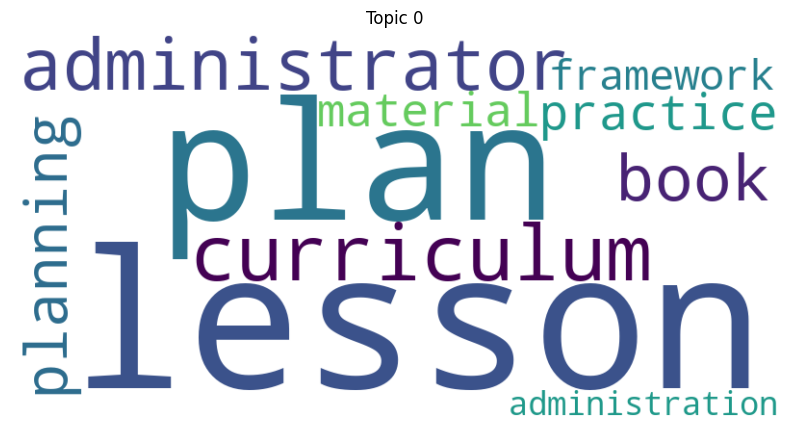

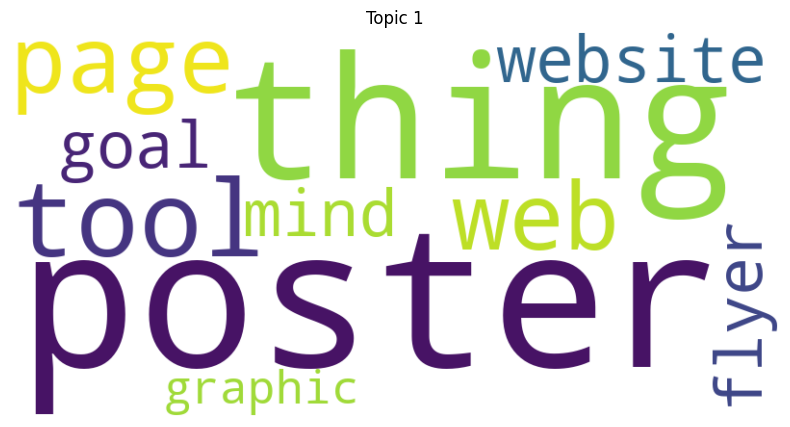

In [76]:
for topic_num, words in topic_model.get_topics().items():
    if topic_num == -1:
        continue  # skip outliers
    wc = WordCloud(width=800, height=400, background_color='white')
    wc.generate_from_frequencies(dict(words))
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {topic_num}")
    plt.show()


In [77]:
jr_usage = df_jr.iloc[:, 130].dropna().to_list()
print(f"There are {len(jr_usage)} responses from Junior High School librarians")

There are 56 responses from Junior High School librarians


In [78]:
hs_usage = df_hs.iloc[:, 130].dropna().to_list()
print(f"There are {len(hs_usage)} responses from High School librarians")

There are 91 responses from High School librarians


In [79]:
multi_usage = df_multi.iloc[:, 130].dropna().to_list()
print(f"There are {len(multi_usage)} responses from Multiple Buildings librarians")

There are 13 responses from Multiple Buildings librarians


In [80]:
filtered_df = df[df['jobRole'] == 'Educational library professionals']
usage = filtered_df.iloc[:, 130].dropna().to_list()
print(f"There are {len(usage)} responses from Educational library professionals")
usage

There are 2 responses from Educational library professionals


['Use the standards as talking points to see how we can better serve our individual community in positive ways to benefit all.',
 'none']

In [81]:
filtered_df = df[df['jobRole'] == 'School library student']
usage = filtered_df.iloc[:, 130].dropna().to_list()
print(f"There are {len(usage)} responses from school library student")
usage

There are 4 responses from school library student


['When discussing needs with the principal is my best use',
 'I use it in my school library classes and lesson planning',
 'I used it first to find gaps in my own performance and then as a way to think about the Librarian as school leader. Much of my job is chromebook repair, maintenance, and inventory, so I have also used it as a way to advocate for the other parts of my job.',
 'I utilize the materials in how I approach being a school librarian and also how I approach my learners. ']

In [82]:
filtered_df = df[df['jobRole'] == 'School library supervisor']
usage = filtered_df.iloc[:, 130].dropna().to_list()
print(f"There are {len(usage)} responses from School library supervisor")
usage

There are 11 responses from School library supervisor


["I don't.",
 'I use the admin sheet in annual meetings with principals, the community sheet with librarians.',
 "We don't use them to advocate for school libraries, we use our own standards and objectives for school libraries",
 'I use the free materials on the website as much as I can, but the cost of the standards resources/books have been a deterrent for my team. ',
 'Has been an effective tool for communicating with principals and upper level district leadership -- the learner framework makes sense to them and aligns well with other standards and district goals.',
 'We used them to write our own objectives which we felt like better served the needs of our students. We turned the standards into real usable objectives that an administrator could understand',
 'It was useful for evaluations and explaining to administrators how I evaluate the library ed techs.',
 'Clings are outside my office, standards are in lesson plans.',
 'Incorporate them into lessons.  ',
 "We don't.",
 'Becaus

In [83]:
filtered_df = df[df['jobRole'] == 'State/DOE employee']
usage = filtered_df.iloc[:, 130].dropna().to_list()
print(f"There are {len(usage)} responses from State/DOE employee")
usage

There are 2 responses from State/DOE employee


["I don't-- the Domains and Strands are confusing and it doesn't serve as a clear communication tool to advocate how school librarians serve students.",
 'As a state level person, I use the standards in professional development and tools for evaluation.']

Below are the analysis of the percentage of respondents's replies in a specific category. All these analysis will only be applied to licensed school librarians, because the other job roles doesn't have enough amount of responses to do this, and their mentioned categories have all included in the categories mentioned by school librarians. There are two layers of analysis:
- First layer: divide by the top layer of category tree structure, and assign a label to each response to see how much percentage of them are talking about each those topics. Then, we will compare the result among the four school grade groups.
- Second layer: for each school grade groups, divide by bottom layer of category tree structure and tell what's the most valued section each school grade cares about.

In [84]:
def clean_line(line):
    line = line.strip().strip('\'"')
    line = re.sub(r'[^a-zA-Z0-9)\]]+$', '', line)
    return line.strip()


def load_phrases(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return [clean_line(line) for line in f if clean_line(line)]


def depulicate_txt(input_file, output_file):
    with open(input_file, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    cleaned_lines = [clean_line(line) for line in lines if clean_line(line)]
    unique_lines = sorted(set(cleaned_lines))
    with open(output_file, 'w', encoding='utf-8') as f:
        for line in unique_lines:
            f.write(line + '\n')

In [ ]:
depulicate_txt('themes/useful_contents.txt', 'themes/useful_contents_cleaned.txt')
depulicate_txt('themes/credibility.txt', 'themes/credibility_cleaned.txt')

In [ ]:
useful_contents = load_phrases("themes/useful_contents_cleaned.txt")
credibility = load_phrases("themes/credibility_cleaned.txt")

In [87]:
label_map = {
    "Useful contents": useful_contents,
    "Credibility": credibility
}

def label_response(response):
    labels = []
    response_lower = str(response).lower()
    for label, phrases in label_map.items():
        for phrase in phrases:
            if phrase.lower() in response_lower:
                labels.append(label)
                break
    return labels if labels else ["Not useful response"]

In [88]:
df['utilization_labels'] = df.iloc[:, 130].apply(label_response)

In [89]:
df.loc[:, ['how do you use', 'utilization_labels']]

,how do you use,utilization_labels
0,I use it with other librarians to advocate for...,[Useful contents]
1,NaN,[Not useful response]
2,NaN,[Not useful response]
3,NaN,[Not useful response]
4,NaN,[Not useful response]
...,...,...
785,NaN,[Not useful response]
786,NaN,[Not useful response]
787,I use it each week to plan my lessons,[Useful contents]
788,I do not use it as much because it is hard to ...,[Not useful response]


In [90]:
filtered = df[df["utilization_labels"].apply(lambda x: len(x) > 0 and x != ["Not useful response"])]
filtered.loc[:, ['how do you use', 'utilization_labels']]

,how do you use,utilization_labels
0,I use it with other librarians to advocate for...,[Useful contents]
5,It is the main thrust of the department curric...,"[Useful contents, Credibility]"
9,"If I had to, I would use the standards to advo...",[Useful contents]
11,I refer to the fact that these standards exist...,[Credibility]
12,I just try to abide by them in my work.,[Useful contents]
...,...,...
767,When writing curriculum I use it to justify co...,[Useful contents]
769,I've used them as a way to promote that the sc...,[Credibility]
771,They are a part of my library plan that I pres...,"[Useful contents, Credibility]"
787,I use it each week to plan my lessons,[Useful contents]


In [91]:
filtered = df[df["utilization_labels"].apply(lambda x: len(x) > 0 and x == ["Not useful response"])]
filtered.loc[:, ['how do you use', 'utilization_labels']]

,how do you use,utilization_labels
1,NaN,[Not useful response]
2,NaN,[Not useful response]
3,NaN,[Not useful response]
4,NaN,[Not useful response]
6,NaN,[Not useful response]
...,...,...
783,NaN,[Not useful response]
784,NaN,[Not useful response]
785,NaN,[Not useful response]
786,NaN,[Not useful response]


On the whole, there is only 19.2% useful responses in this question.

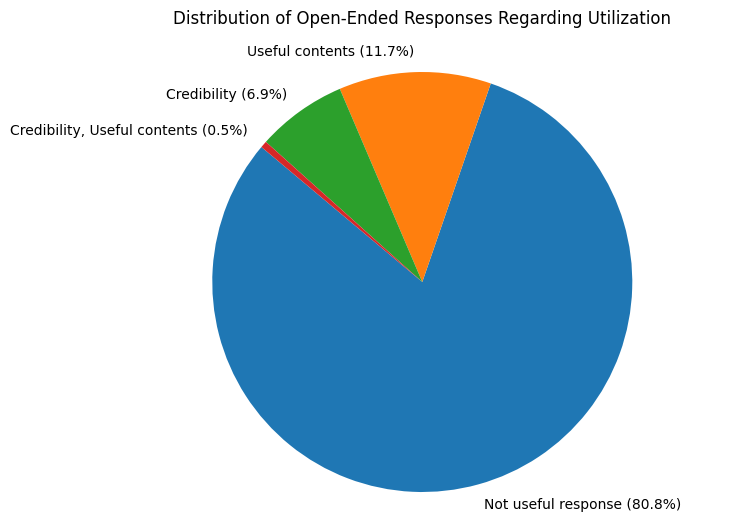

In [92]:
df["label_combo"] = df["utilization_labels"].apply(lambda labels: ", ".join(sorted(labels)))

# Count occurrences and compute percentages
label_counts = df["label_combo"].value_counts()
label_percentages = label_counts / label_counts.sum() * 100

# Plot the pie chart with labels and percentages
plt.figure(figsize=(8, 6))
plt.pie(
    label_percentages,
    labels=[f"{label} ({pct:.1f}%)" for label, pct in label_percentages.items()],
    startangle=140
)
plt.title("Distribution of Open-Ended Responses Regarding Utilization", pad=20)
plt.axis('equal')  # Keep chart as a circle
plt.show()


Then, we split by school grades.

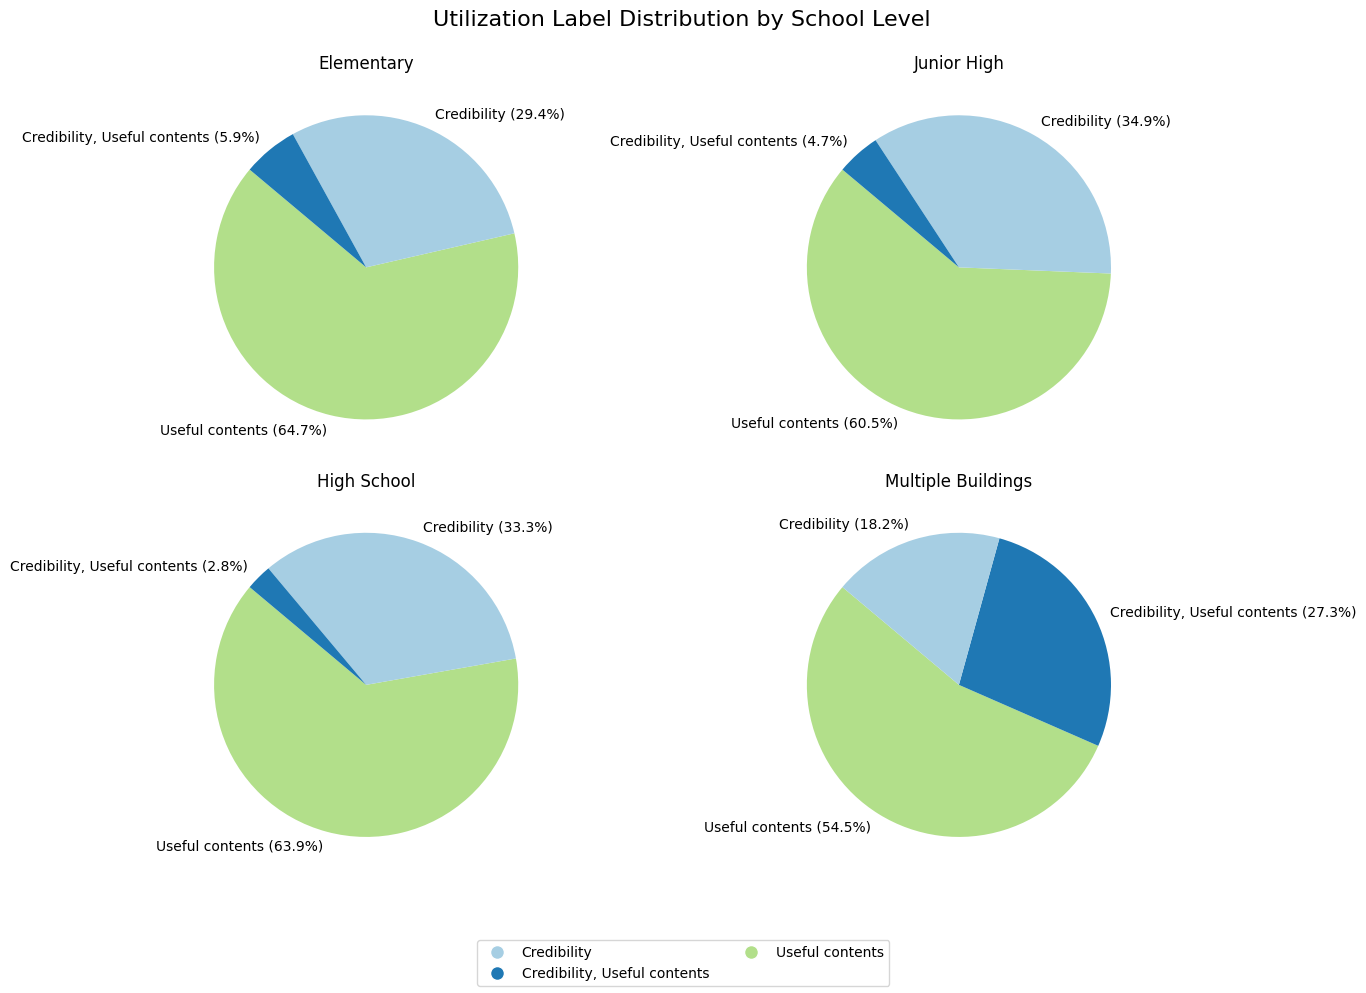

In [93]:
# Apply the above function to four school grades
df_elem.loc[:, 'utilization_labels'] = df_elem.iloc[:, 130].apply(label_response)
df_jr.loc[:, 'utilization_labels'] = df_jr.iloc[:, 130].apply(label_response)
df_hs.loc[:, 'utilization_labels'] = df_hs.iloc[:, 130].apply(label_response)
df_multi.loc[:, 'utilization_labels'] = df_multi.iloc[:, 130].apply(label_response)

elem_use_filtered = df_elem[df_elem["utilization_labels"].apply(lambda x: len(x) > 0 and x != ["Not useful response"])]
jr_use_filtered = df_jr[df_jr["utilization_labels"].apply(lambda x: len(x) > 0 and x != ["Not useful response"])]
hs_use_filtered = df_hs[df_hs["utilization_labels"].apply(lambda x: len(x) > 0 and x != ["Not useful response"])]
multi_use_filtered = df_multi[df_multi["utilization_labels"].apply(lambda x: len(x) > 0 and x != ["Not useful response"])]

elem_use_filtered["label_combo"] = elem_use_filtered["utilization_labels"].apply(lambda labels: ", ".join(sorted(labels)))
jr_use_filtered["label_combo"] = jr_use_filtered["utilization_labels"].apply(lambda labels: ", ".join(sorted(labels)))
hs_use_filtered["label_combo"] = hs_use_filtered["utilization_labels"].apply(lambda labels: ", ".join(sorted(labels)))
multi_use_filtered["label_combo"] = multi_use_filtered["utilization_labels"].apply(lambda labels: ", ".join(sorted(labels)))

data1 = elem_use_filtered['label_combo']
data2 = jr_use_filtered['label_combo']
data3 = hs_use_filtered['label_combo']
data4 = multi_use_filtered['label_combo']
datasets = [data1, data2, data3, data4]
titles = ['Elementary', 'Junior High', "High School", "Multiple Buildings"]
all_labels = sorted(set().union(*[set(data.unique()) for data in datasets]))

colors = plt.cm.Paired(range(len(all_labels)))
label_color_map = dict(zip(all_labels, colors))

# Compute label percentages and prepare pie charts
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, data in enumerate(datasets):
    counts = data.value_counts()
    percentages = counts / counts.sum() * 100
    labels = counts.index
    pie_colors = [label_color_map[label] for label in labels]

    axes[i].pie(
        percentages,
        labels=[f"{label} ({percentages[label]:.1f}%)" for label in labels],
        colors=pie_colors,
        startangle=140
    )
    axes[i].set_title(titles[i])

# Create a single shared legend
handles = [plt.Line2D([0], [0], marker='o', color='w',
                      markerfacecolor=label_color_map[label],
                      markersize=10, label=label) for label in all_labels]

fig.legend(handles=handles, loc='lower center', ncol=2, fontsize='medium')
plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.suptitle("Utilization Label Distribution by School Level", fontsize=16)
plt.show()

In [94]:
advocate = [
    "If I had to, I would use the standards to advocate for the library program",
    "I try to use infographics that incorporate what I am doing in the library with the AASL Standards as a way to advocate for the students and what we are doing in the library",
    "It's a wonderful tool to advocate",
    "I post flyers in the Media Center and add banners to web pages",
    "I use it with other librarians to advocate for supporting all literacies, incorporating maker education, and generally teaching more than databases and books",
    "I have used the career readiness to advocate for the importance of school librarians as well as advocating for the learners to have access to materials that will help them prepare for the workforce and college",
    "Advocacy for TLs in schools",
    "I have occasionally cited specific parts of them when advocating for information literacy, the inclusion of diverse texts, or the role of a librarian to stakeholders like our school board",
    "Last year my position was possibly going to be cut. I immediately referred to the standards to advocate for the work that I do. Most people in the community have no real idea of the work that I do in the school but the standards were very useful as I advocated for myself and my students",
    "I use this to advocate for the students. Having the school library standards helps me show what skills students should posses before they graduate, and allows me to implement lessons in my school! Alongside this, it also allows me to advocate for the importance of school libraries and librarians",
    "As a high school librarian with a flexible schedule, I don't necessarily use the NSLS on a daily basis; however, I use them in advocating for library resources, along with staffing, to support the instructional role played by the school librarian"
]
create_other_standards = [
    "It has been used to help write our essential grade level standards",
    "I used it to create our districts library media plan",
    "We are starting a new reading program.  The framework helps me align the library standards with the new program and allows for justification of programing I think we should add to support areas of collaboration",
    "We accessed them as we rewrote our collection policy including selection and deselection of books",
    "I plan to use it to revise our district library standards, and also to advocate for a specific evaluation of librarians roles vs. using the standard Marzano framework which doesn't capture much of the job description",
    "I am using them more as our district takes steps to implement 'deeper learning.'  They are an example of what we could be doing if we had more district support with time and resources",
    "To establish School district Library programing and Future ready plan",
    "We are using it to help us re-write our district library policy manual currently",
    "I use the standards when I am planning units of study with different departments throughout my school to advocate for information literacy instruction in all classrooms and to demonstrate the impact partnering with the library has on learning",
    "It is the basis for our end of year media report",
    "They are a part of my library plan that I present to the school board each year for approval",
    "In Indiana, we use the standards heavily because we no longer have state library standards. We intend to (hopefully) use the AASL Standards as a jumping off point to develop IN State standards in the future"
]
gen_jus_ideas = [
    "To get ideas",
    "Keep in mind when experimenting with new things and am preparing for others to question",
    "when justifying my program and the why's of my instruction to admin",
    "consult the materials that I have when shaping plans for semester",
    "The Standards from AASL can support any kind of learning the students do in the library",
    "I have a few posters and have looked things up online as needed to support my goals but I do not own the Standards",
    "I use the poster and your website for digging into topics as needed",
    "When these standards were first released, I tracked the lessons that I taught, so I could see the areas that I had strengths and where there were gaps in my instruction.  I used a Google Form for each lesson and this was somewhat helpful as a reflection piece",
    "I use the bare bones version of it. I don't have access to the book.",
    "It justifies our practice while also offering new ideas for school librarians to implement"
]
eval = [
    "I will be using this to help develop librarian evaluations with district personal. Exposure sometimes equals advocacy when conversations happen and a greater understanding of the role of librarians",
    "evaluate the library media program yearly",
    "It would help me to evaluate and improve my school library",
    "I use these in evaluation discussions with administration",
    "In the past I have integrated portions of the standards and supporting materials into my educator evaluation goals"
]
identify_gap = [
    "I have tried to point out where our school district falls short of meeting the standards for our school libraries. Until Massachusetts adopts library standards at the state level, this is a futile conversation",
    "I refer to this when asking for restoration of our aide hours (they were cut to 15 hours/week/building across the district a few years ago). It has also been useful in pointing out the inadequacies of the Danielson model when applied to evaluation of librarians. I also refer to this in outreach to teachers when seeking to collaborate - these are the places where our standards overlap and I can help your students achieve standards in your subject area"
]
plan_curr_les = [
    "It is the main thrust of the department curriculum and we refer to it often when demonstrating the role we play within the schools",
    "I just try to abide by them in my work",
    "I use them for developing lessons",
    "I use the standards to help plan my lessons",
    "Implement into lessons",
    "The AASL framework is incorporated with our state standards. I use the state standards in every lesson plan",
    "To create lessons",
    "I have to use the standards in my lesson planning",
    "I use it as guide when preparing my lessons, deal with administrators, board members, members of the community",
    "I consult the standards every time i write a lesson plan",
    "When our district's school librarians meet to plan curriculum, this text gets used as a reference. I have referred to it only sometimes when lesson planning. Even though students grades K-5 in our school attend library as a class period, there is no formal state assessment or even school based assessment for this class. If as a state or school district we were to move to a more formal assessment practice for school libraries, I'm sure this text would be more valuable to me. The fact that this text exists, makes me hopeful for the future of school libraries",
    "Guide lesson planning",
    "I put them in lessons I plan as well as adding them to informational products for administrators",
    "I use it in discussions with my admin and in curriculum development",
    "I use it each week to plan my lessons",
    "When writing curriculum I use it to justify courses and curriculum within the library",
    "I am able to fit a few of the standards to match what I am teaching, but most are beyond what my low level / primary readers are capable of",
    "We use them when designing curriculum, which is then approved by administration and when necessary the school board",
    "I use them weekly when I include them in my lesson plans; this helps communicate the skills and objectives I'm working towards with my students",
    "Wrote it into my 3 year plan and curriculum as references",
    "I include the standards in my lesson plans. I include the framework for school librarians and libraries in my professional growth plan",
    "Use the vocabulary and examples given to support lessons, etc",
    "To plan lessons, and to discuss priorities and plans with my school principal and district office",
    "I address the standards during my library lessons.  Since I collaborate frequently with teacher, they are exposed to the AASL standards through my teaching and practice.  I shared a copy of the standards with my admin and curriculum coordinators so they are aware of the national librarian standards",
    "In designing of lessons and integration of centers",
    "I use the Shared Foundations in my lessons plans",
    "crafting lessons",
    "I try to include them in my lessons",
    "I use them to inform my curriculum planning",
    "Our lessons and curriculum are aligned with the National School Library Standards. We use former President Audrey Church's School Librarians as Learning Leaders infographic as an advocacy tool with our district administration.",
    "I put them in lessons I plan",
    "I use the AASL standards when I have to write a formal lesson plan or write my unit overview",
    "to edit/revise our curriculum",
    "When writing curriculum, we look through the standards",
    "In the IB high school, I use them as a background for my knowledge as I collaborate with teachers based on what their curricular needs are",
    "I use them to develop lessons.  Otherwise not much",
    "I use it to fill in the standards portion of my lesson plans",
    "I use the framework for learners when designing lessons",
    "I use it for my in school lessons and have, at times, refered to it in my online curriculum for teacher PD",
    "when I am writing a lesson plan",
    "I use these in planning lessons, evaluation discussions with administration, with classroom teachers when collaborating",
    "to write curriculum and in lesson plans",
    "I utilize the standards when planning lessons, curriculum, and programs. It gives validation for my goals and provides a focus",
    "I try to match my lessons to the standards for students. I am in a new library this year so I am trying to apply all of the standards to my new context",
    "It helped me to write our curriculum",
    "Helpful in legitimizing work of librarian as the work of a teacher: curriculum writing and lesson plans, teacher-librarian evaluation, advocacy, etc"
]
self_growth = [
    "In developing my Professional Growth Plan",
    "I use them for me",
    "Keep in mind when experimenting with new things and am preparing for others to question",
    "It justifies our practice while also offering new ideas for school librarians to implement",
    "I make sure teachers, parents, and administration knows the goals we're trying to achieve",
    "Useful for planning.  Things tend to happen on the fly in my building. I don’t always have the time I need to consult the standards. I need to spend the time to memorize more of them",
    "We use them in conjunction with our state library media standards to help justify our roles as teachers to administration",
    "I refer to it when needed",
    "when choosing books for everyone to represent our diverse school system",
    "I use them to inform my understanding for conversations with stakeholders",
    "I use it as a reference for my programming and as I reflect on and promote my library program",
    "Share with others and refer to when needed",
    "Quotes, data, and wording"
]
add_weight_present = [
    "Put the standards on any presentation that I create",
    "I would add them as a resource at the bottom of a document, like our Library Plan or my essential standards doc"
]
support_collab = [
    "I use the NSLS and materials from AASL to create professional development for my colleagues to better support them in understanding the role of librarians & libraries in learning",
    "I use these with classroom teachers when collaborating",
    "To guide my instruction with my student library assistants in library science, to validate my collaboration with classroom teachers and their learners, and to validate the instructional role of the school librarian",
    "We use implementation and advocacy to facilitate conversations with teachers about collaboration",
    "I have brought it to meets with colleagues to show that I also have standards that I want to follow. I could do better at explicitly stating what the standards are within our collaborative lessons",
    "I’ve used the standards to create crosswalks with state content area standards as tools for collaboration",
    "I share a lot of appendix materials on school librarians with my admin regularly",
    "I create collaborative unit planners using the standards and share with the content-area teacher I'm working with - whether it's in the library or classroom. I share this information with administration, although the directing principal still insists I simply check out books. She used to teach math and doesn't like to read, so perhaps she never felt a connection to libraries",
    "I use the the standards and framework to help guide my collaboration with my classroom teachers to guide our planning and instruction",
    "I usually share them with staff a lot so they understand the work I do and how it supports their work.  I am sure to advertise and discuss the meanings of the framework and what it means when addressing collaboration or curation",
    "I have the standards poster up in our library space, and often refer to the crosswalk between subject standards and the AASL standards to reinforce to co-teachers our role in instruction"
]
talk_wz_admin = [
    "having a common national document to reference is helpful when talking to administrators",
    "Sharing with administrators and decision makers",
    "Working with School Division, District School Board and State Legislators",
    "increase school administrators' awareness of new library standards and current practices and the need to transition to a model of current elementary library expectations",
    "Making administrators and other educators aware that there are National School Library Standards helps show that there is more to the library than just checking out books!",
    "They are a part of my library plan that I present to the school board each year for approval",
    "We use them when designing curriculum, which is then approved by administration and when necessary the school board",
    "My administration just this year has acknowledged that I have them and should use them",
    "I have shown them to legislators and school committee members",
    "I use these to make any 'asks' to our school administration and to advise administrators on best practices in their school libraries",
    "Mostly for funding requests",
    "I give each teacher a copy of the learner standards. I refer to the standards for School Libraries when meeting with my administration",
    "In reports to school administration as well as our district",
    "I refer to them to support my decisions for why I do what I do in the library when discussing my plan for the library with administration",
    "I  add them to informational products for administrators",
    "Share the information with my administration",
    "By referring to the standards when communicating with administrators",
    "By sharing information from them when we meet with legislators and administrators",
    "I rarely use them because they are so cumbersome. I use them when I am writing goals for my annual evaluation and I use them when I speaking to the school board or community, but I never use them in my actual practice",
    "I have used them with my principal to demonstrate how interconnected the library standards are with the state standards and curriculum. I have used them with the library department to discuss what may be missing k-12",
    "When they first came out, I shared them with our administration and instructional council. I try to reference them when relevant",
    "I add them to informational products for administrators",
    "I use the crosswalk with the Future Ready Librarians standards to document my work throughout the year for evaluation by my principal. I use that information to educate my principal on the standards relating to librarians and libraries in KY schools"
]   
talk_wz_parents = [
    "I refer to them in my newsletters that get sent out to all parents, teachers, etc. in the district",
    "Include a statement in my annual newsletters to parents & teachers",
    "newsletter blurbs",
    "I use some of the posters and graphics in emails"
]
prof_recog = [
    "I refer to the fact that these standards exist. I tried very hard to use specific parts when it first came out, but it's just  TOO dense, too much, and needs to cut right to the point of how libraries increase student success. (Put all those stats front and center!)",
    "We have the standards posted on our Focus Wall",
    "It is nice to remind people that librarians have standards to cover",
    "I use it to show the wide areas of education libraries are involved in and how students should be learning",
    "I General, I do not need to use these standards, because my reputation as an expert librarian across the district stands for itself. However, it important to have them for many reasons as we all know.   I would like to have specific skills curriculum map for grades K-12 standardized for all school librarians across the United States",
    "To show others in the school how I am a critical piece in the education of students and not just used for teacher 'planning time'",
    "To illustrate the role the school library and a qualified librarian play in facilitating critical thinking and independent choice",
    "I use it to show the value of what we do in the school library and that library content is aligned with standards just like every other subject",
    "Show the value of school libraries, certified librarians, library classes",
    "I use the book to integrate our standards in collaborative lessons, the advocacy tool helps me find ways to promote the library program and showcase the strengths of the library to my community",
    "The fact that this text exists, makes me hopeful for the future of school libraries",
    "The publication provides the basis for all of our work. It backs up the priorities of a quality school library program",
    "we use the standards to show that the library program is a legitimate academic department, as opposed to an arm of the tech department or part of student services",
    "I use these items to show what all the librarian can do for our school",
    "crosswalks with ISTE in order to draw in more teacher users to understand the impact library standards have cross curricularly",
    "Being familiar with them and knowing they exist means I know I can refer to them if needed. But just being a certified librarian is what makes me able to advocate",
    "I've used them as a way to promote that the school library has national standards like other curricular areas.",
    "Use it to make sure that administration and other educators know what librarians can and should be doing",
    "I have used the career readiness to advocate for the importance of school librarians as well as advocating for the learners to have access to materials that will help them prepare for the workforce and college",
    "It is the main thrust of the department curriculum and we refer to it often when demonstrating the role we play within the schools",
    "To guide my instruction with my student library assistants in library science, to validate my collaboration with classroom teachers and their learners, and to validate the instructional role of the school librarian",
    "to advocate for a specific evaluation of librarians roles vs. using the standard Marzano framework which doesn't capture much of the job description."
]

label_map = {
    "Advocating for programs/students": advocate,
    "Creating other standards": create_other_standards,
    "Generating/Justifying ideas": gen_jus_ideas,
    "Evaluating librarian/program": eval,
    "Identifying practice gaps": identify_gap,
    "Planning curriculum and lessons": plan_curr_les,
    "Self-growth planning and other references": self_growth,
    "Adding weights to presentations/documents": add_weight_present,
    "Supporting collaboration and communication with co-workers": support_collab,
    "Talking with administrators/leaders": talk_wz_admin,
    "Talking with parents/co-workers": talk_wz_parents,
    "Professional recognition": prof_recog
}

In [95]:
# create a column to store the second level labels
df_elem.loc[:, 'utilization_labels_s'] = df_elem.iloc[:, 130].apply(label_response)
df_jr.loc[:, 'utilization_labels_s'] = df_jr.iloc[:, 130].apply(label_response)
df_hs.loc[:, 'utilization_labels_s'] = df_hs.iloc[:, 130].apply(label_response)
df_multi.loc[:, 'utilization_labels_s'] = df_multi.iloc[:, 130].apply(label_response)

In [96]:
elem_use_filtered_s = df_elem[df_elem["utilization_labels_s"].apply(lambda x: len(x) > 0 and x != ["Not useful response"])].copy()
jr_use_filtered_s = df_jr[df_jr["utilization_labels_s"].apply(lambda x: len(x) > 0 and x != ["Not useful response"])].copy()
hs_use_filtered_s = df_hs[df_hs["utilization_labels_s"].apply(lambda x: len(x) > 0 and x != ["Not useful response"])].copy()
multi_use_filtered_s = df_multi[df_multi["utilization_labels_s"].apply(lambda x: len(x) > 0 and x != ["Not useful response"])].copy()

elem_use_filtered_s.loc[:, "label_combo"] = elem_use_filtered_s["utilization_labels_s"].apply(lambda labels: ", ".join(sorted(labels)))
jr_use_filtered_s.loc[:, "label_combo"] = jr_use_filtered_s["utilization_labels_s"].apply(lambda labels: ", ".join(sorted(labels)))
hs_use_filtered_s.loc[:, "label_combo"] = hs_use_filtered_s["utilization_labels_s"].apply(lambda labels: ", ".join(sorted(labels)))
multi_use_filtered_s.loc[:, "label_combo"] = multi_use_filtered_s["utilization_labels_s"].apply(lambda labels: ", ".join(sorted(labels)))

final_labels = [
    "Advocating for programs/students",
    "Creating other standards",
    "Generating/Justifying ideas",
    "Evaluating librarian/program",
    "Identifying practice gaps",
    "Planning curriculum and lessons",
    "Self-growth planning and other references",
    "Adding weights to presentations/documents",
    "Supporting collaboration and communication with co-workers",
    "Talking with administrators/leaders",
    "Talking with parents/co-workers",
    "Professional recognition"
]

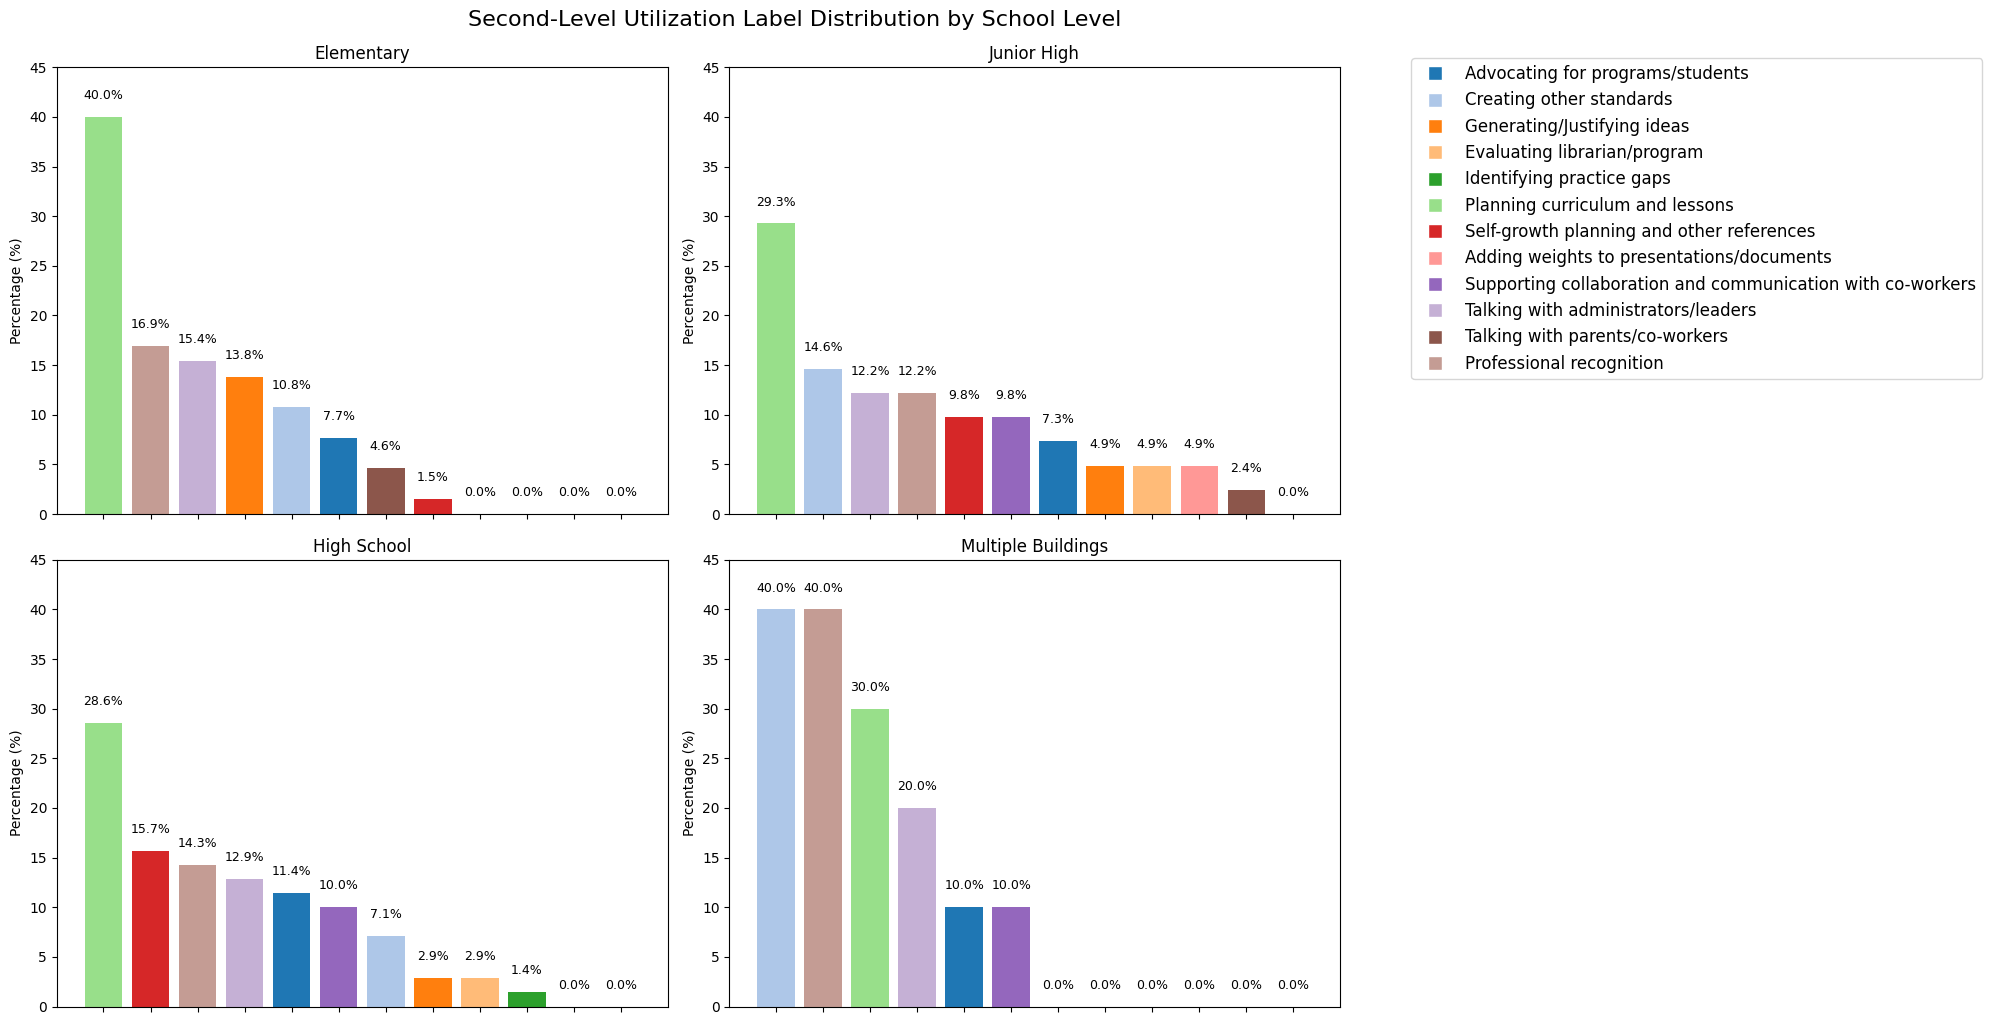

In [97]:
colors = plt.cm.tab20(range(len(final_labels)))
label_color_map = dict(zip(final_labels, colors))

# Function to calculate label percentages
def compute_label_percentages(df, final_labels):
    total_responses = len(df)
    counter = Counter()
    for entry in df["label_combo"]:
        if pd.notnull(entry):
            labels = [label.strip() for label in entry.split(",")]
            for label in labels:
                if label in final_labels:
                    counter[label] += 1
    percentages = {label: (counter[label] / total_responses) * 100 for label in final_labels}
    return percentages

# Apply to each school level
datasets = [
    ("Elementary", elem_use_filtered_s),
    ("Junior High", jr_use_filtered_s),
    ("High School", hs_use_filtered_s),
    ("Multiple Buildings", multi_use_filtered_s)
]

# Create the plot
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

max_ylim = 45

for i, (title, df_group) in enumerate(datasets):
    percent_dict = compute_label_percentages(df_group, final_labels)
    sorted_items = sorted(percent_dict.items(), key=lambda x: x[1], reverse=True)
    labels, values = zip(*sorted_items)
    bar_colors = [label_color_map[label] for label in labels]

    ax = axes[i]
    bars = ax.bar(range(len(values)), values, color=bar_colors)
    ax.set_title(title)
    ax.set_ylabel("Percentage (%)")
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels([''] * len(labels))  # Hide x-axis text
    ax.set_ylim(0, max_ylim)  # fixed y-axis range

    # Add percentage text above bars
    for j, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 1.5, f'{height:.1f}%',
                ha='center', va='bottom', fontsize=9)

# Shared legend
handles = [
    plt.Line2D([0], [0], marker='s', color='w',
               markerfacecolor=label_color_map[label], markersize=10, label=label)
    for label in final_labels
]

fig.legend(handles=handles, loc='upper left', bbox_to_anchor=(0.88, 0.98), fontsize='large')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.suptitle("Second-Level Utilization Label Distribution by School Level", fontsize=16, y=1.02)
plt.show()


#### Strength

- `q16`: Please rate how well you think each word or phrase describes the book publication. [both low scored and high scored ones]

The scale of this question is 0-6.

In [98]:
ratings = df_q16.iloc[:, 1:11]

# Sum each column
average = ratings.mean()
results = average.sort_values(ascending=False)

# Print results
print("How well each word or phrase describes the Standards?")
print(results)

How well each word or phrase describes the Standards?
book_relevant              3.561135
book_valuable              3.449782
book_nicely_designed       3.421397
book_well_written          3.393013
book_well_organized        3.393013
book_useful                3.386463
book_practical             3.312227
book_easy_to_use           3.218341
book_easy_to_understand    3.218341
book_ADA_accessible        3.170306
dtype: object


**`Easy to use` has the lowest score in most job roles. For School library supervisors, the Standards are `not easy to understand`, and `not ADA accessible`; For State/DOE employees, the Standards are `valuable` and `useful`, but are `very uneasy to use`, `not quite well-written`, and `not quite well designed`.**

In [99]:
grouped_avg = df_q16.groupby(df_q16.iloc[:, 0])[df_q16.columns[1:11]].mean()
grouped_avg

,book_valuable,book_relevant,book_practical,book_useful,book_easy_to_use,book_easy_to_understand,book_well_written,book_nicely_designed,book_well_organized,book_ADA_accessible
jobRole,,,,,,,,,,
Certified / licensed school librarian,3.444181,3.584323,3.313539,3.396675,3.261283,3.261283,3.422803,3.432304,3.413302,3.182898
Educational library professionals,3.0,3.0,3.2,3.0,2.8,3.0,2.8,3.6,3.0,3.2
School library student,3.166667,3.666667,3.333333,3.166667,3.0,2.333333,3.0,4.5,3.5,3.666667
School library supervisor,3.608696,3.173913,3.26087,3.217391,2.782609,2.608696,3.173913,3.043478,3.130435,2.782609
State/DOE employee,4.333333,4.0,3.666667,4.333333,1.666667,4.0,2.666667,2.333333,3.0,3.333333


- `q17`: What do you like about the Standards? [Open ended]

In [100]:
filtered_df = df[df['jobRole'] == 'Certified / licensed school librarian']
usage = filtered_df.iloc[:, 54].dropna().to_list()
print(f"There are {len(usage)} responses from licensed school librarians")

There are 261 responses from licensed school librarians


In [101]:
elem_like = df_elem.iloc[:, 54].dropna().to_list()
print(f"There are {len(elem_like)} responses from Elementary School librarians")

There are 122 responses from Elementary School librarians


**What Elementary School Librarians Like About the AASL Standards:**
- **Clear and Organized Structure**: Many respondents praised the organized layout, including charts, tables, color coding, and the way standards are grouped (e.g., learners, librarians, libraries).

- **Ease of Use and Accessibility**: Respondents appreciated that the standards are easy to reference, follow, and understand, especially with visual aids like matrices, posters, and flowcharts.

- **Helpful for Lesson Planning and Practice**: The standards help with instructional planning, lesson alignment, and are practical for day-to-day teaching.

- **Comprehensive and Profession-Specific**: Librarians liked that the standards are comprehensive, well thought out, and tailored to school library work, rather than being adapted from general education standards.

- **Alignment with Other Frameworks and Real-World Learning**: Several responses noted the alignment with other standards (like ISTE or Future Ready) and their focus on real-life learning and student exploration.

- **Professional Validation and Growth**: Some found that the standards provide validation of their professional role and opportunities for personal growth and program evaluation.

In [102]:
jr_like = df_jr.iloc[:, 54].dropna().to_list()
print(f"There are {len(jr_like)} responses from Junior High School librarians")

There are 81 responses from Junior High School librarians


**What Junior High School Librarians Like About the AASL Standards:**
- **Profession-specific and supportive**: Appreciate that the standards are made for school librarians and reflect their work.

- **Well-organized and easy to use**: Positive comments on layout, navigation, color-coding, and charts.

- **Helpful for planning and instruction**: Use the standards as a framework or foundation for lessons and programming.

- **Useful for advocacy**: Helps explain the librarian’s role to administrators and support professional recognition.

- **Comprehensive and detailed**: Liked the depth, explanations, and rubrics for different stakeholders (learners, librarians, libraries).

In [103]:
hs_like = df_hs.iloc[:, 54].dropna().to_list()
print(f"There are {len(hs_like)} responses from High School librarians")

There are 115 responses from High School librarians


**What High School Librarians Like About the AASL Standards:**
- **Organized and easy to navigate**: Positive mentions of layout, structure, visuals, color-coding, and charts.

- **Helpful for instruction and collaboration**: Librarians use the standards for lesson planning, collaboration, and aligning with Common Core or subject content.

- **Supports advocacy and professionalism**: Seen as a valuable tool to justify their role, communicate with administrators, and demonstrate the value of library programs.

- **Profession-specific and inclusive**: Appreciated for addressing learners, librarians, and libraries, and for being forward-thinking and flexible.

- **Practical and idea-generating**: Examples, best practices, appendices, and shared foundations help with implementation and inspiration.

In [104]:
multi_like = df_multi.iloc[:, 54].dropna().to_list()
print(f"There are {len(multi_like)} responses from Multiple Buildings librarians")

There are 19 responses from Multiple Buildings librarians


**What Multiple Building Librarians Like About the AASL Standards:**
- **Organized and all-in-one**: Appreciate that the standards are in one place, easy to reference, and visually clear (charts, structure, layout).

- **Comprehensive and descriptive**: Positive comments about the completeness and clarity of the content.

- **Helpful for program planning**: Some noted its value for generating programming ideas and guiding library instruction.

- **Recognition of value**: Like that the standards exist, define their work, and include “Best Practices” for guidance.

In [ ]:
depulicate_txt('themes/strength_contents.txt', 'themes/strength_contents_cleaned.txt')
depulicate_txt('themes/strength_structure.txt', 'themes/strength_structure_cleaned.txt')
depulicate_txt('themes/strength_intentionality.txt', 'themes/strength_intentionality_cleaned.txt')

In [ ]:
strength_contents = load_phrases("themes/strength_contents_cleaned.txt")
strength_structure = load_phrases("themes/strength_structure_cleaned.txt")
strength_intentionality = load_phrases("themes/strength_intentionality_cleaned.txt")

In [107]:
label_map = {
    "Contents": strength_contents,
    "Structure": strength_structure,
    "Intentionality": strength_intentionality
}

df['strength_labels'] = df.iloc[:, 54].apply(label_response)

In [108]:
df.loc[:, ['What you like about the book', 'strength_labels']]

,What you like about the book,strength_labels
0,NaN,[Not useful response]
1,NaN,[Not useful response]
2,NaN,[Not useful response]
3,NaN,[Not useful response]
4,They are ideal...but we are not working in ide...,[Not useful response]
...,...,...
785,Parallel language throughout all three sections.,[Not useful response]
786,NaN,[Not useful response]
787,The ease the standards. They are easy to find ...,[Not useful response]
788,NaN,[Not useful response]


In [109]:
filtered = df[df["strength_labels"].apply(lambda x: len(x) > 0 and x != ["Not useful response"])]
filtered.loc[:, ['What you like about the book', 'strength_labels']]

,What you like about the book,strength_labels
5,I like how each Shared Foundation is explained...,[Contents]
8,I like that the Standards accommodate learners...,[Contents]
9,That it has things that I can use for my perso...,[Contents]
11,"Tables/rubrics with the different domains; ""Be...",[Contents]
12,I really like the thought and effort behind th...,[Intentionality]
...,...,...
745,The amount of information available,[Contents]
765,I am glad we have standards because it validat...,[Intentionality]
767,They are relevant to what I do every day.,[Contents]
771,"I like the ""Best Practices"" after each standard.",[Contents]


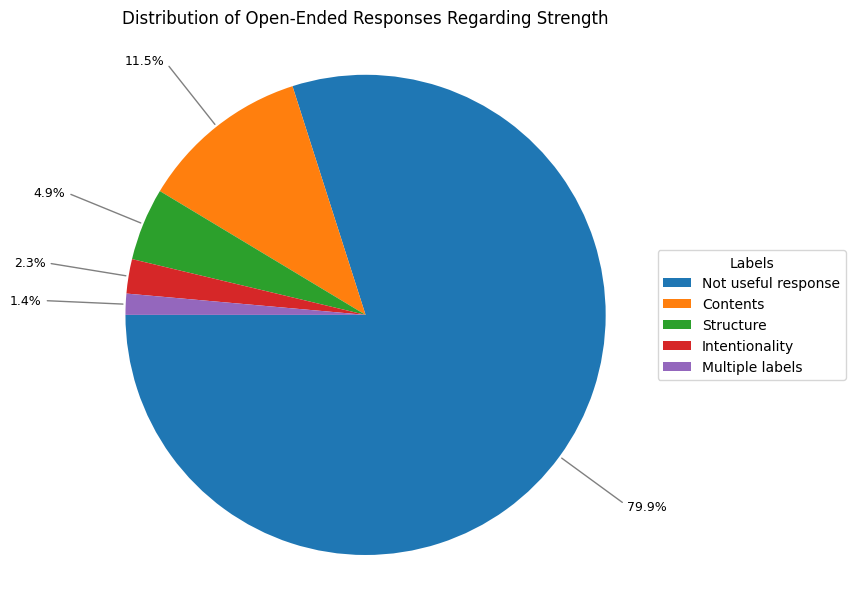

In [110]:
# Turn each label list into a sorted string
df["strength_label_combo"] = df["strength_labels"].apply(lambda labels: ", ".join(sorted(labels)))

# Count occurrences and compute percentages
label_counts = df["strength_label_combo"].value_counts()
label_percentages = label_counts / label_counts.sum() * 100

simple_percentages = {}
for label, pct in label_percentages.items():
    if "," in label:  # It's a multi-label combo
        simple_percentages["Multiple labels"] = simple_percentages.get("Multiple labels", 0) + pct
    else:
        simple_percentages[label] = pct

# Sort for clean visualization
sorted_items = sorted(simple_percentages.items(), key=lambda x: x[1], reverse=True)
labels, sizes = zip(*sorted_items)

# Plot with external percentages and leader lines
fig, ax = plt.subplots(figsize=(8, 6))
wedges, _ = ax.pie(sizes, startangle=180)

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))

    horizontal_alignment = 'left' if x > 0 else 'right'
    connectionstyle = f"angle,angleA=0,angleB={ang}"

    ax.annotate(
        f'{sizes[i]:.1f}%',
        xy=(x, y),
        xytext=(1.35 * x, 1.35 * y),
        ha=horizontal_alignment,
        va='center',
        textcoords='data',
        fontsize=9,
        arrowprops=dict(arrowstyle="-", connectionstyle=connectionstyle, color='gray')
    )

# Legend
ax.legend(wedges, labels, title="Labels", loc="center left", bbox_to_anchor=(1, 0.5))

ax.axis('equal')
plt.title("Distribution of Open-Ended Responses Regarding Strength", pad=20)
plt.tight_layout()
plt.show()


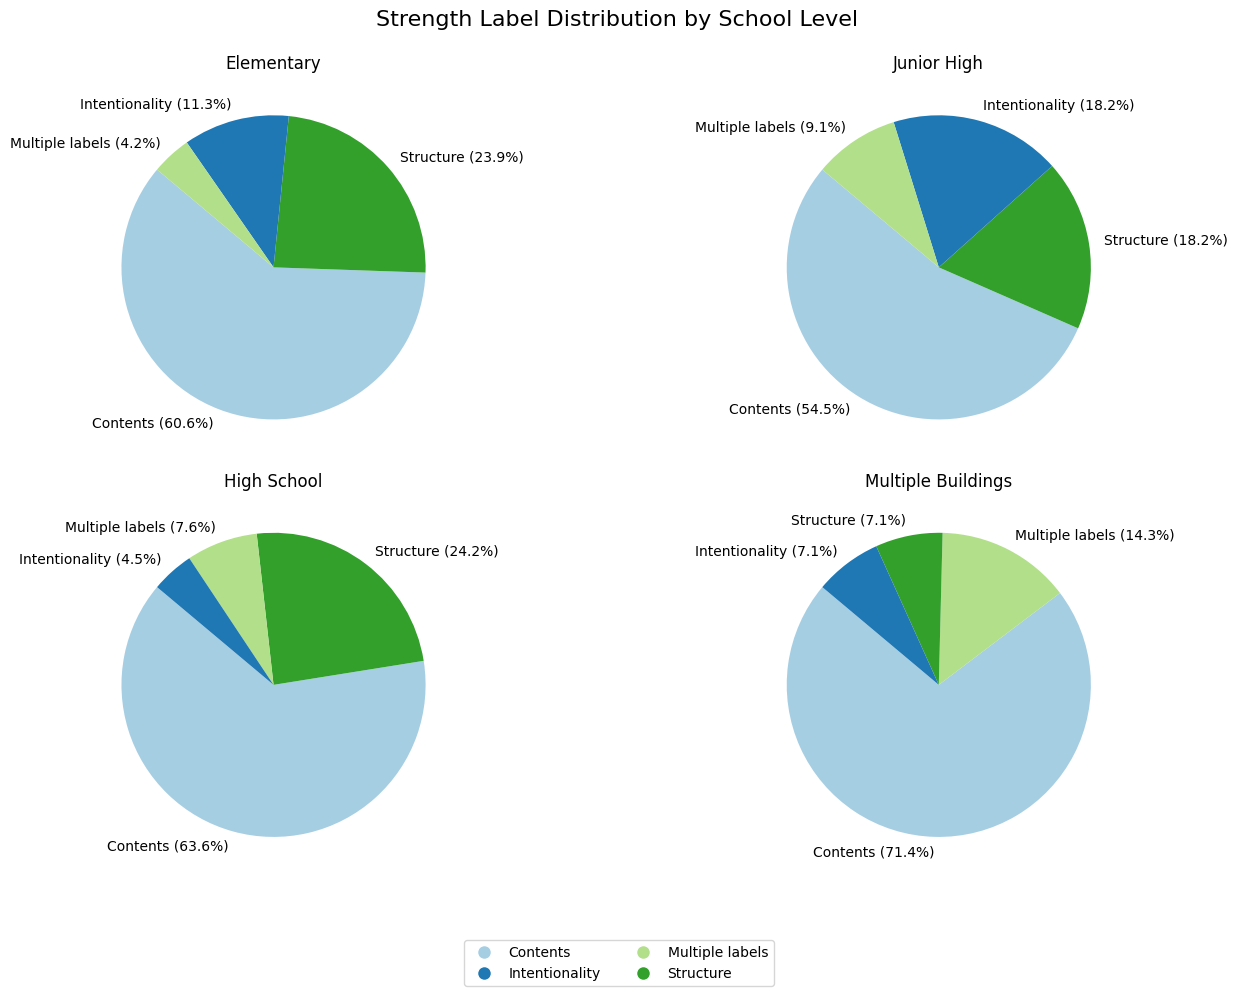

In [111]:
df_elem.loc[:, 'strength_labels'] = df_elem.iloc[:, 54].apply(label_response)
df_jr.loc[:, 'strength_labels'] = df_jr.iloc[:, 54].apply(label_response)
df_hs.loc[:, 'strength_labels'] = df_hs.iloc[:, 54].apply(label_response)
df_multi.loc[:, 'strength_labels'] = df_multi.iloc[:, 54].apply(label_response)

elem_strength_filtered = df_elem[df_elem["strength_labels"].apply(lambda x: len(x) > 0 and x != ["Not useful response"])]
jr_strength_filtered = df_jr[df_jr["strength_labels"].apply(lambda x: len(x) > 0 and x != ["Not useful response"])]
hs_strength_filtered = df_hs[df_hs["strength_labels"].apply(lambda x: len(x) > 0 and x != ["Not useful response"])]
multi_strength_filtered = df_multi[df_multi["strength_labels"].apply(lambda x: len(x) > 0 and x != ["Not useful response"])]

def simplify_labels(label_list):
    if len(label_list) == 1:
        return label_list[0]  # keep single label
    else:
        return "Multiple labels"  # collapse 2+ labels

elem_strength_filtered["label_combo"] = elem_strength_filtered["strength_labels"].apply(simplify_labels)
jr_strength_filtered["label_combo"] = jr_strength_filtered["strength_labels"].apply(simplify_labels)
hs_strength_filtered["label_combo"] = hs_strength_filtered["strength_labels"].apply(simplify_labels)
multi_strength_filtered["label_combo"] = multi_strength_filtered["strength_labels"].apply(simplify_labels)

data1 = elem_strength_filtered['label_combo']
data2 = jr_strength_filtered['label_combo']
data3 = hs_strength_filtered['label_combo']
data4 = multi_strength_filtered['label_combo']
datasets = [data1, data2, data3, data4]
titles = ['Elementary', 'Junior High', "High School", "Multiple Buildings"]
all_labels = sorted(set().union(*[set(data.unique()) for data in datasets]))

colors = plt.cm.Paired(range(len(all_labels)))
label_color_map = dict(zip(all_labels, colors))

# Compute label percentages and prepare pie charts
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()


for i, data in enumerate(datasets):
    counts = data.value_counts()
    percentages = counts / counts.sum() * 100
    labels = counts.index
    pie_colors = [label_color_map[label] for label in labels]


    axes[i].pie(
        percentages,
        labels=[f"{label} ({percentages[label]:.1f}%)" for label in labels],
        colors=pie_colors,
        startangle=140
    )
    axes[i].set_title(titles[i])

# Create a single shared legend
handles = [plt.Line2D([0], [0], marker='o', color='w',
                      markerfacecolor=label_color_map[label],
                      markersize=10, label=label) for label in all_labels]


fig.legend(handles=handles, loc='lower center', ncol=2, fontsize='medium')
plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.suptitle("Strength Label Distribution by School Level", fontsize=16)
plt.show()


In [112]:
alignment = [
    "I like how it overlaps with other standards and aligns with our responsibilities",
    "It was purchased by our school district for each librarian and we can use it in conjunction with our state standards",
    "I like to align it with other standards that are more narrow in focus depending upon what I am teaching in practice. The above publications are very broad",
    "I like that crosswalks were available for other types of standards",
    "crosswalks well with common core",
    "The standards crosswalks"
]
clear_breakdown = [
    "I love the beginning part of each standard section that breaks down the standards easily into sentences that can be put on lesson plans",
    "I appreciate the breakdown and explanations provided in the book.",
    "Breakdown",
    "I like to framework and how's its broken up into the different stakeholders so everyone can understand how the standards apply to their role.",
    "I like how it breaks it up for learner, librarians and libraries",
    "I like the way it is broken down into different themes",
    "That it delineates learner, Librarian and Library program standards",
    "I like that the Standards accommodate learners, librarians, and libraries",
    "I like that they describe the standards for learners, librarians, and libraries",
    "I appreciate the different rubrics- for learners, librarians, and libraries",
    "I do like that there is a focus on different stakeholders. However, I think all of that should be in a separate publication",
    "I like that it breaks out standards for both learners and educators"
]
comprehensive = [
    "Everything is in one place",
    "Very complete and descriptive",
    "There are a lot of areas to provide programing",
    "It's all in one spot and relatively easy to locate the standards that apply to my lesson",
    "All of the information is in one place and does not require the purchase of multiple publications to get this general information about the standards overall. I know there are separate books for each standard, but those have a different focus",
    "Very comprehensive",
    "It is comprehensive",
    "Convenient to have everything in one place",
    "I like that it includes the Common Beliefs",
    "Very thorough",
    "I like how comprehensive they are",
    "gives a GENERAL good platform for schools to use",
    "Comprehensive and indexed",
    "I like that the standards are exclusively for school libraries and school librarians. I also like that they are specific to libraries yet general enough to cover a wide variety of students' ages",
    "They can be applied across all content and curriculum",
    "I like having the complete picture for all levels together"
]
concise = [
    "concise"
]
diverse = [
    "I like the emphasis on learning from multiple, diverse perspectives",
    "All encompassing of various projects/collaboration"
]
examples = [
    "I love the examples and suggestions for each of the standards",
    "It does provide practical examples",
    "The examples of how the standards can be implemented",
    "Included grade-level examples",
    "I do like the examples given",
    "I LOVE the appendix in the back that gives concrete examples on providing evidence to supervisors",
    "Design and marketing materials",
    "great examples",
    "The example application and lessons provided for various age levels"
]
professional_relevance = [
    "The amount of information available",
    "The standards are listed",
    "They are relevant to what I do every day",
    "That it has things that I can use for my personal growth, as well as standards to share with other teachers or administration",
    "I like the standards in general. I think they are a good cornerstone for our work",
    "It defines the Standards we teach",
    "I havn't used it in years, but I remember liking it",
    "Although many state the standards are too vague, I feel that they give me options to be creative with my students and curriculum",
    "it's a valuable resource",
    "I like that I can always find something relevant to my work",
    "Easy to convey the standards to administrators that do not understand library science",
    "Flexible. I can easily apply them to any lesson I teach and vice versa",
    "I can easily refer to the standards and more information about them as needed",
    "I like that I can include specific library standards when lesson planning",
    "update is useful for broad topics or to show how the library program can benefit students",
    "High expections. I use it very often when creating lessons and writing reports",
    "A tool for advocacy ",
    "Useful tools for organization and application",
    "They focus on actions and provide language for library media specialist do and what we want students to do",
    "That it is specific to our profession, rather than having to adapt standards from other content areas (ex., NCTE)",
    "I like having professional standards that pertain to the specialized work of the library to help others understand the rigorous professional work we do and the rigorous professional standards we adhere to",
    "It's a good way to show admin what we do and why we're important to a school program",
    "good for advocating for job and work",
    "I like the fact that the book specifically addresses information and standards important to the job I do with students to ensure they have a foundation in information lit as well as media lit",
    "I use it as a framework... foundation"
]
skill_based = [
    "I like that the standards are skills-based, not content specific",
    "I like that the standards themselves are skill-based",
    "Thorough to incorporate technology with research skills for today's learners"
]
specificity = [
    "the specificity"
]
specific_topics = [
    "I like how each Shared Foundation is explained in detail",
    "Best Practice pages",
    "The matrix of domains & competencies",
    "The Index and Appendices",
    "I like the framework chart",
    "I like the areas where it talks about stakeholders and advocacy",
    "For me it is to much and to technical. I personally like using the poster better because it is quick and to the point and I appreciate a visual. I would REALLY like to see the poster be given free to every school library so my students could see it!",
    "I like the deep dive into the standards, and the program evaluation checklists that are provided",
    "I like the six foundations and the way the school librarian roles are defined (we do so much!)",
    "I have never seen the book, I only use the downloaded framework",
    "the best practices really helped in the integration of the standards",
    "end of chapter checklists",
    "I also find the position statements in Appendix C to be very helpful",
    "I love the 3 frameworks and the way they all fit together",
    "I LOVE the appendix in the back that gives concrete examples on providing evidence to supervisors",
    "Index because I don't read cover to cover, I use the index.",
    "I love the standard that says Learning is a social responsibility",
    "I like the Best Practices after each standard"
]
visuals = [
    "I like how the Domains are laid out in chart form so you can easily see how the shared foundations look for learners, librarians, and libraries.  The numerous charts assist in finding specific information about each foundation and each domain",
    "Visual clarity",
    'The available free charts.',
    "I like the visuals",
    "I like looking at the charts so I can quickly get information",
    "love the charts and tables",
    "Imagery and icons.  It helps me retain information",
    "I like the clarity and simplicity of the PDF chart",
    "Tables/rubrics with the different domains",
    "The tables"
]
color_codings = [
    "color coded",
    "Design features",
    "I appreciate the color-coding  and icons for the different focuses",
    "The cog logo is ok. I like the colors",
    "The graphic format, including checklists, flow charts, and color coded pages, of some very complex ideas make for easier reading",
    "It’s been so long since I cracked the book, I’m not really sure. All I remember is the color coding",
    "It's pretty",
    "It is colorful!"
]
easy_to_use = [
    "Easy to find information",
    "User friendly",
    "Easy to use and navigate",
    "Easy to understand",
    "It is easy to use",
    "It is easy to navigate and use in any of my lessons with teachers",
    "easy to use in planning",
    "It'd easy to read and understand.",
    "It provides clear language on the expectations for School Libraries"
]
organized_layout = [
    "Very organized.",
    "I like the information provided and the layout",
    "Organized",
    "I like the structure of the standards",
    "The layout is easily formatted overall",
    "Design layout",
    "It is well organized and designed",
    "I like how the Domains are laid out in chart form so you can easily see how the shared foundations look for learners, librarians, and libraries.  The numerous charts assist in finding specific information about each foundation and each domain",
    "Nicely designed",
    "The way it is organized is helpful to narrow down how to help students and other learners",
    "While I don't have access to the full book, I've used it in the past. I like the way it is organized",
    "It is well organized",
    "Nice design",
    "I really like the organization of the book. It's easy to follow",
    "It is organized",
    "Organized into sections, pull-outs are easy to find and useful",
    "I like the way it is set up, going over the standards first and then getting into other topics",
    "That they are written"
]
idealistic = [
    "The standards are ideal.  They were thoughtfully planned out and are exactly what librarians are and should be doing",
    "I think it's nice to be idealistic"
]
effort = [
    "I really like the thought and effort behind the standards",
    "I like that it exists and helps me find the standards I can use in my pracrice",
    "I love that the standards exist",
    "I feel like it gives value to our profession and shows others what librarians do daily in our work",
    "I like that effort was made to create standards directly related to library skills.  I simply find the current standards difficult to use",
    "I appreciate the Include standards",
    "well thought out",
    "It shows that there is a united group of standards and best practices that all states can use.",
    "I like that it exists and helps me find the standards I can use in my pracrice.",
    "I like that it exists and has lots of useful information",
    "Able to show to my principal/administrator",
    "I like that we have a framework we can follow",
    "I like that it was done to support us",
    "The fact that there are up to date standards for School Libraries, they are organized according to the pillars, and that school librarians are involved in the development of the standards",
    "I like having a place to refer administrators to for my library responsiblities; it helps explain the role",
    "I like the notion of having National Library Standards",
    "the ability to share the standards with other educators, the framework",
    "It's a good way to show admin what we do and why we're important to a school program",
    "We have standards",
    "Mainly--I like that we HAVE standards. It helps to be able to connect to other education professionals",
    "Although the text is very bloated, repetitive, and difficult to browse, I do think that the messaging in general covers the many roles of a librarian and is relevant to our practice",
    "It defines the Standards we teach",
    "I like the idea of having standards... it is a step in the right direction"
]

label_map = {
    "Alignment with other standards": alignment,
    "Clear breakdown": clear_breakdown,
    "Comprehensive": comprehensive,
    "Concise": concise,
    "Diverse perspectives": diverse,
    "Examples and suggestions": examples,
    "Professional relevance": professional_relevance,
    "Skill-based focus": skill_based,
    "Specificity": specificity,
    "Specifically useful topics/chapters": specific_topics, 
    "Visual aids": visuals,
    "Color coding and icons": color_codings,
    "Easy to use": easy_to_use,
    "Organized layout": organized_layout,
    "Idealistic": idealistic,
    "Value in effort": effort
}


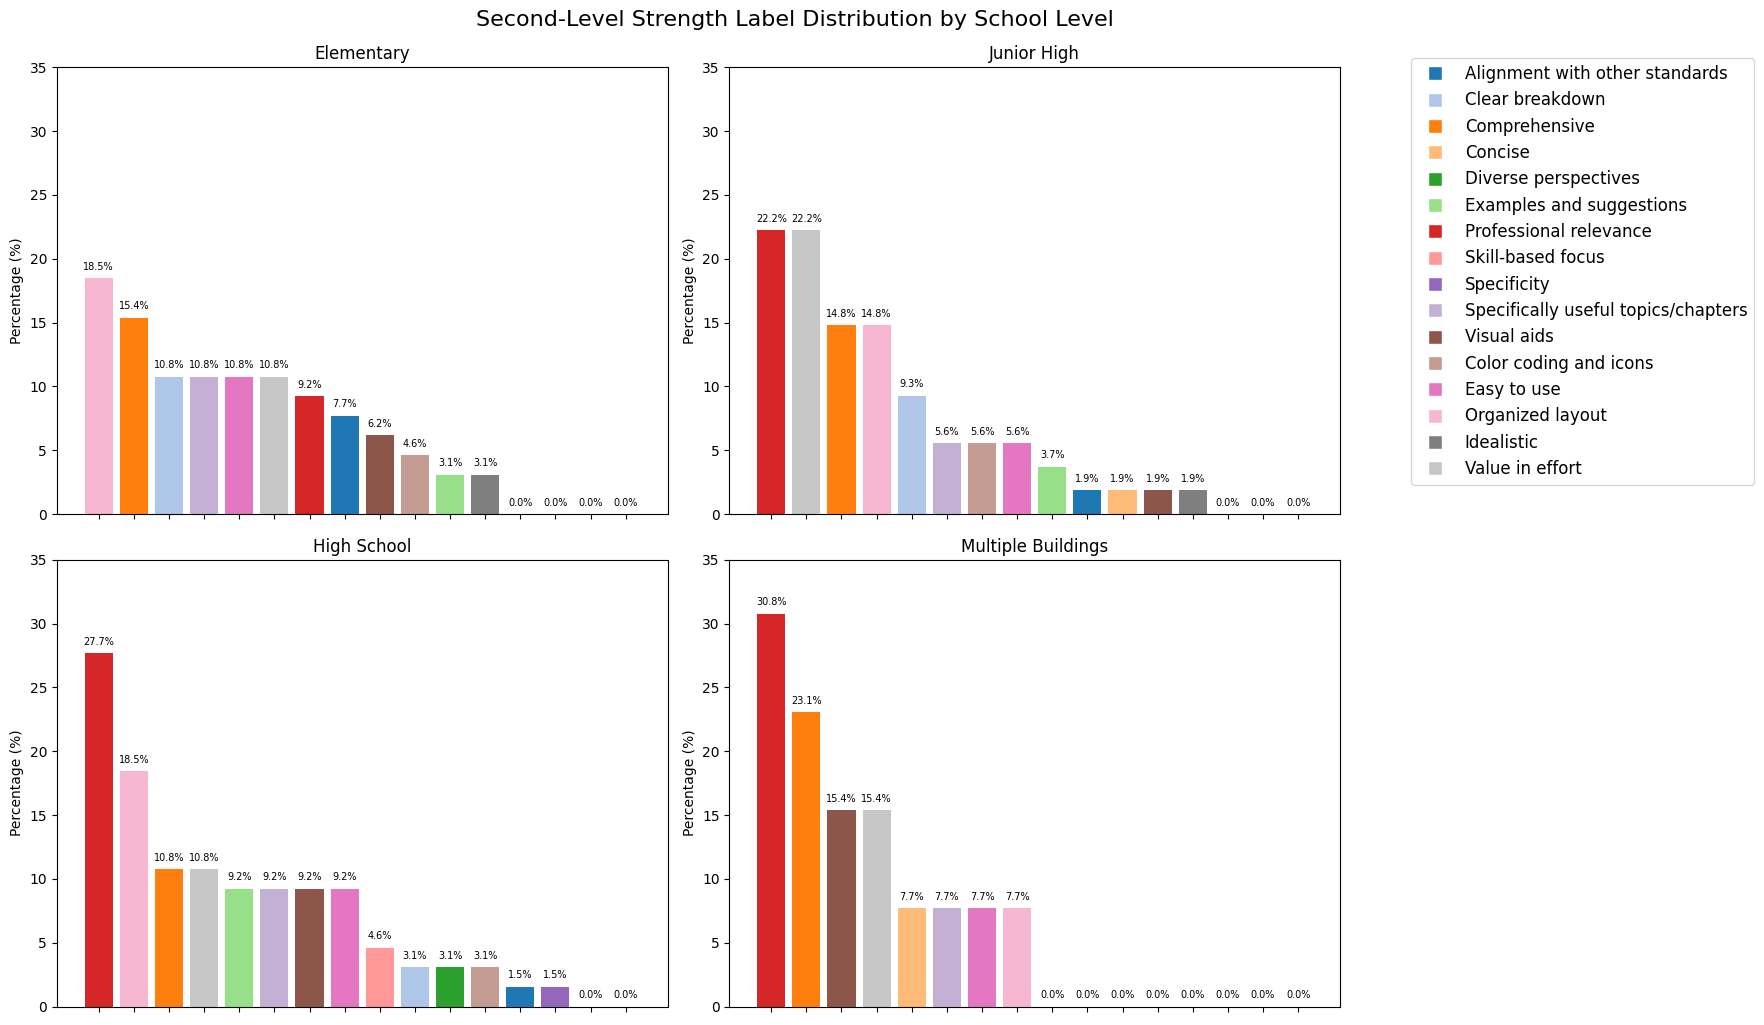

In [113]:
# create a column to store the second level labels
df_elem.loc[:, 'strength_labels_s'] = df_elem.iloc[:, 54].apply(label_response)
df_jr.loc[:, 'strength_labels_s'] = df_jr.iloc[:, 54].apply(label_response)
df_hs.loc[:, 'strength_labels_s'] = df_hs.iloc[:, 54].apply(label_response)
df_multi.loc[:, 'strength_labels_s'] = df_multi.iloc[:, 54].apply(label_response)

elem_strength_filtered_s = df_elem[df_elem["strength_labels_s"].apply(lambda x: len(x) > 0 and x != ["Not useful response"])].copy()
jr_strength_filtered_s = df_jr[df_jr["strength_labels_s"].apply(lambda x: len(x) > 0 and x != ["Not useful response"])].copy()
hs_strength_filtered_s = df_hs[df_hs["strength_labels_s"].apply(lambda x: len(x) > 0 and x != ["Not useful response"])].copy()
multi_strength_filtered_s = df_multi[df_multi["strength_labels_s"].apply(lambda x: len(x) > 0 and x != ["Not useful response"])].copy()

elem_strength_filtered_s.loc[:, "label_combo"] = elem_strength_filtered_s["strength_labels_s"].apply(lambda labels: ", ".join(sorted(labels)))
jr_strength_filtered_s.loc[:, "label_combo"] = jr_strength_filtered_s["strength_labels_s"].apply(lambda labels: ", ".join(sorted(labels)))
hs_strength_filtered_s.loc[:, "label_combo"] = hs_strength_filtered_s["strength_labels_s"].apply(lambda labels: ", ".join(sorted(labels)))
multi_strength_filtered_s.loc[:, "label_combo"] = multi_strength_filtered_s["strength_labels_s"].apply(lambda labels: ", ".join(sorted(labels)))


final_labels = [
    "Alignment with other standards",
    "Clear breakdown",
    "Comprehensive",
    "Concise",
    "Diverse perspectives",
    "Examples and suggestions",
    "Professional relevance",
    "Skill-based focus",
    "Specificity",
    "Specifically useful topics/chapters", 
    "Visual aids",
    "Color coding and icons",
    "Easy to use",
    "Organized layout",
    "Idealistic",
    "Value in effort"
]

colors = plt.cm.tab20(range(len(final_labels)))
label_color_map = dict(zip(final_labels, colors))


# Function to calculate label percentages
def compute_label_percentages(df, final_labels):
    total_responses = len(df)
    counter = Counter()
    for entry in df["label_combo"]:
        if pd.notnull(entry):
            labels = [label.strip() for label in entry.split(",")]
            for label in labels:
                if label in final_labels:
                    counter[label] += 1
    percentages = {label: (counter[label] / total_responses) * 100 for label in final_labels}
    return percentages


# Apply to each school level
datasets = [
    ("Elementary", elem_strength_filtered_s),
    ("Junior High", jr_strength_filtered_s),
    ("High School", hs_strength_filtered_s),
    ("Multiple Buildings", multi_strength_filtered_s)
]


# Create the plot
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()


max_ylim = 35


for i, (title, df_group) in enumerate(datasets):
    percent_dict = compute_label_percentages(df_group, final_labels)
    sorted_items = sorted(percent_dict.items(), key=lambda x: x[1], reverse=True)
    labels, values = zip(*sorted_items)
    bar_colors = [label_color_map[label] for label in labels]


    ax = axes[i]
    bars = ax.bar(range(len(values)), values, color=bar_colors)
    ax.set_title(title)
    ax.set_ylabel("Percentage (%)")
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels([''] * len(labels))  # Hide x-axis text
    ax.set_ylim(0, max_ylim)  # fixed y-axis range


    # Add percentage text above bars
    for j, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.5, f'{height:.1f}%',
                ha='center', va='bottom', fontsize=7)


# Shared legend
handles = [
    plt.Line2D([0], [0], marker='s', color='w',
               markerfacecolor=label_color_map[label], markersize=10, label=label)
    for label in final_labels
]

fig.legend(handles=handles, loc='upper left', bbox_to_anchor=(0.88, 0.98), fontsize='large')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.suptitle("Second-Level Strength Label Distribution by School Level", fontsize=16, y=1.02)
plt.show()


**Key Contrast Summary - Most Emphasized Value**

Elementary: Visual layout & instructional use

Junior High: Professional identity & stakeholder alignment

High School: Practical application, advocacy, and deeper resources

Multiple Building: Structural clarity, but limited depth of engagement

In [114]:
filtered_df = df[df['jobRole'] == 'Educational library professionals']
usage = filtered_df.iloc[:, 54].dropna().to_list()
print(f"There are {len(usage)} responses from Educational library professionals")
usage

There are 1 responses from Educational library professionals


['none']

In [115]:
filtered_df = df[df['jobRole'] == 'School library student']
usage = filtered_df.iloc[:, 54].dropna().to_list()
print(f"There are {len(usage)} responses from School library student")
usage

There are 5 responses from School library student


['Organization of the book/standards',
 'Diagrams and colors. Principles',
 'I only know a little about the standards. I am interested in learning more about them through reading the book.',
 'It provides valuable information that plays an important role in my library and how I run things. ',
 'The appendices and resources throughout the text']

In [116]:
filtered_df = df[df['jobRole'] == 'School library supervisor']
usage = filtered_df.iloc[:, 54].dropna().to_list()
print(f"There are {len(usage)} responses from School library supervisor")
usage

There are 18 responses from School library supervisor


["I don't have access to the book",
 'Common language to describe key instructional areas of the school library and librarian practice.',
 "It's comprehensive, and the information is in a single volume that can be accessed easily.",
 'I like that the three areas are identified (learners, School Librarians, School Libraries).',
 'I like how there are standards for students, librarians and library programs.  Design is good. I like the domains.',
 'the attempt to have such a document to guide/support school librarians, the overall organization, design and color coding, ',
 "To be honest, there's not much I like about it at all. When the standards came out, we studied them, but I haven't used them much since unless we are trying to add a standard to a lesson we have written",
 'I love seeing how the competencies change depending on who/what the standards are addressing.',
 'I like the inclusion of makerspace thinking',
 'I like that the standards incorporate every part of the research proc

In [117]:
filtered_df = df[df['jobRole'] == 'State/DOE employee']
usage = filtered_df.iloc[:, 54].dropna().to_list()
print(f"There are {len(usage)} responses from State/DOE employee")
usage

There are 1 responses from State/DOE employee


['Part II- I find the in depth discussion of the competencies to be very helpful in helping school librarians unpack the standards.']

#### Challenges

- `q18`: What do you dislike or find challenging about the Standards?

In [118]:
elem_dislike = df_elem.iloc[:, 55].dropna().to_list()
print(f"There are {len(elem_dislike)} responses from Elementary School librarians")

There are 125 responses from Elementary School librarians


In [119]:
jr_dislike = df_jr.iloc[:, 55].dropna().to_list()
print(f"There are {len(jr_dislike)} responses from Junior High School librarians")

There are 79 responses from Junior High School librarians


In [120]:
hs_dislike = df_hs.iloc[:, 55].dropna().to_list()
print(f"There are {len(hs_dislike)} responses from High School librarians")

There are 116 responses from High School librarians


In [121]:
multi_dislike = df_multi.iloc[:, 55].dropna().to_list()
print(f"There are {len(multi_dislike)} responses from Multiple Buildings librarians")

There are 23 responses from Multiple Buildings librarians


In [122]:
filtered_df = df[df['jobRole'] == 'Educational library professionals']
usage = filtered_df.iloc[:, 55].dropna().to_list()
print(f"There are {len(usage)} responses from Educational library professionals")
usage

There are 2 responses from Educational library professionals


["It's expensive", 'none']

In [123]:
filtered_df = df[df['jobRole'] == 'School library student']
usage = filtered_df.iloc[:, 55].dropna().to_list()
print(f"There are {len(usage)} responses from School library student")
usage

There are 4 responses from School library student


['Sometimes I mix up the 3 catagories; learners, librarians, libraries',
 'Looking up standards. Concrete example lessons and resources',
 "Wasn't made aware that there was a book until tonight.",
 'Having different standards for learners, librarians, and libraries--even though they overlap to form the cohesive standard, it is not practical to try to cover all of these bases--incorporating all into each standard would make more sense']

In [124]:
filtered_df = df[df['jobRole'] == 'School library supervisor']
usage = filtered_df.iloc[:, 55].dropna().to_list()
print(f"There are {len(usage)} responses from School library supervisor")
usage

There are 20 responses from School library supervisor


["I don't have access to the book",
 'The limited alignment to specific topics and subject matter and to grade level.',
 "The book is expensive, and it becomes difficult to break out pieces of it to do professional learning with our school librarians. We want to use it across stakeholder groups, and that's cost prohibitive in addition to the volume being dense and hard to navigate.",
 'Again, too cumbersome to use. I handed the book to my director and it was promptly returned.  Too much for anyone to wade through.  School libraries do not have standards.  They reflect the work of the people in the space.',
 "There isn't a category that encompasses literacy and supporting students as lifelong readers. We are always told it's embedded but it's not. Research also needs to be more present in the standards. Ethical use, especially with new AI tech, needs to be bolstered.",
 "It doesn't match what we do, clearly, in a way we can relate it to the teachers' work; makes it difficult to build re

In [125]:
filtered_df = df[df['jobRole'] == 'State/DOE employee']
usage = filtered_df.iloc[:, 55].dropna().to_list()
print(f"There are {len(usage)} responses from State/DOE employee")
usage

There are 2 responses from State/DOE employee


['It is confusing and too complex-- difficult to apply to lesson planning, difficult to use as an advocacy tool. ',
 'The integrated approach to the three sets of standards were confusing and tricky to explain to educators, especially administrators.']

In [ ]:
depulicate_txt('themes/challenges_contents.txt', 'themes/challenges_contents_cleaned.txt')
depulicate_txt('themes/challenges_application.txt', 'themes/challenges_application_cleaned.txt')
depulicate_txt('themes/challenges_structure.txt', 'themes/challenges_structure_cleaned.txt')
depulicate_txt('themes/challenges_accessibility.txt', 'themes/challenges_accessibility_cleaned.txt')

In [ ]:
challenges_contents = load_phrases("themes/challenges_contents_cleaned.txt")
challenges_application = load_phrases("themes/challenges_application_cleaned.txt")
challenges_structure = load_phrases("themes/challenges_structure_cleaned.txt")
challenges_accessibility = load_phrases("themes/challenges_accessibility_cleaned.txt")

label_map = {
    "Contents": challenges_contents,
    "Application": challenges_application,
    "Structure": challenges_structure,
    "Accessibility": challenges_accessibility
}

In [128]:
df['challenges_labels'] = df.iloc[:, 55].apply(label_response)
df.loc[:, ['What you dislike about the book', 'challenges_labels']]

,What you dislike about the book,challenges_labels
0,The separate standards for librarians and libr...,[Contents]
1,NaN,[Not useful response]
2,"It is way too complex, especially at an elemen...",[Contents]
3,NaN,[Not useful response]
4,"Outside of my library colleagues, no one knows...",[Application]
...,...,...
785,The Framework for Learners is difficult to ali...,[Not useful response]
786,NaN,[Not useful response]
787,I believe it would be helpful to have more exa...,[Not useful response]
788,NaN,[Not useful response]


In [129]:
filtered = df[df["challenges_labels"].apply(lambda x: len(x) > 0 and x != ["Not useful response"])]
filtered.loc[:, ['What you dislike about the book', 'challenges_labels']]

,What you dislike about the book,challenges_labels
0,The separate standards for librarians and libr...,[Contents]
2,"It is way too complex, especially at an elemen...",[Contents]
4,"Outside of my library colleagues, no one knows...",[Application]
5,There are so many parts that sometimes it's di...,[Contents]
8,I dislike the length.,[Contents]
...,...,...
718,THE COST.,[Accessibility]
731,The wording is too complicated and vague at th...,[Contents]
745,Would like it to be a little more reader frien...,[Contents]
767,Sometimes hard to apply in certain situations.,[Application]


In [130]:
filtered = df[df["challenges_labels"].apply(lambda x: len(x) > 0 and x == ["Not useful response"])]
filtered.loc[:, ['What you dislike about the book', 'challenges_labels']]

,What you dislike about the book,challenges_labels
1,NaN,[Not useful response]
3,NaN,[Not useful response]
6,NaN,[Not useful response]
7,NaN,[Not useful response]
14,NaN,[Not useful response]
...,...,...
785,The Framework for Learners is difficult to ali...,[Not useful response]
786,NaN,[Not useful response]
787,I believe it would be helpful to have more exa...,[Not useful response]
788,NaN,[Not useful response]


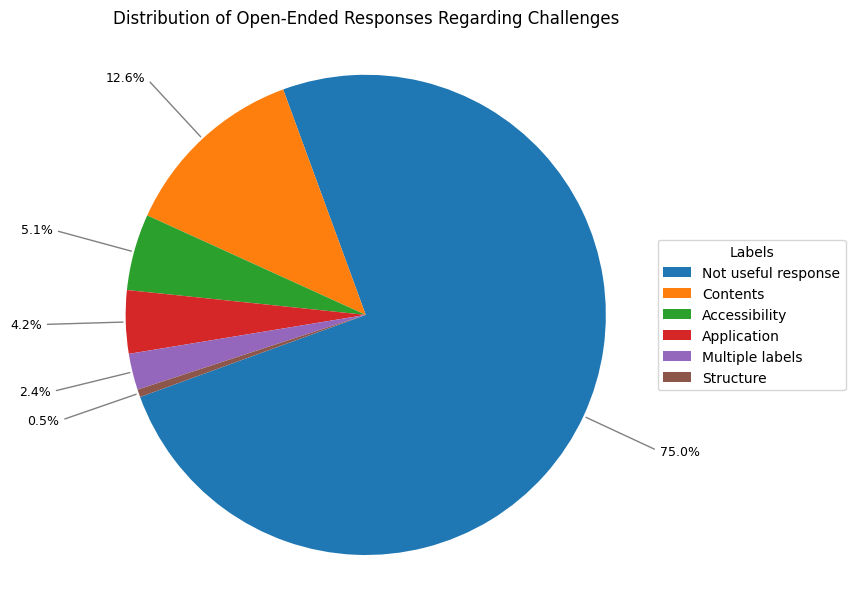

In [131]:
# Turn each label list into a sorted string (e.g., ["Credibility", "Useful Contents"] → "Credibility, Useful Contents")
df["challenges_label_combo"] = df["challenges_labels"].apply(lambda labels: ", ".join(sorted(labels)))

# Count occurrences and compute percentages
label_counts = df["challenges_label_combo"].value_counts()
label_percentages = label_counts / label_counts.sum() * 100

simple_percentages = {}
for label, pct in label_percentages.items():
    if "," in label:  # It's a multi-label combo
        simple_percentages["Multiple labels"] = simple_percentages.get("Multiple labels", 0) + pct
    else:
        simple_percentages[label] = pct

# Sort for clean visualization
sorted_items = sorted(simple_percentages.items(), key=lambda x: x[1], reverse=True)
labels, sizes = zip(*sorted_items)

# Plot with external percentages and leader lines
fig, ax = plt.subplots(figsize=(8, 6))
wedges, _ = ax.pie(sizes, startangle=200)

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))

    horizontal_alignment = 'left' if x > 0 else 'right'
    connectionstyle = f"angle,angleA=0,angleB={ang}"

    ax.annotate(
        f'{sizes[i]:.1f}%',
        xy=(x, y),
        xytext=(1.35 * x, 1.35 * y),
        ha=horizontal_alignment,
        va='center',
        textcoords='data',
        fontsize=9,
        arrowprops=dict(arrowstyle="-", connectionstyle=connectionstyle, color='gray')
    )

# Legend
ax.legend(wedges, labels, title="Labels", loc="center left", bbox_to_anchor=(1, 0.5))

ax.axis('equal')
plt.title("Distribution of Open-Ended Responses Regarding Challenges", pad=20)
plt.tight_layout()
plt.show()


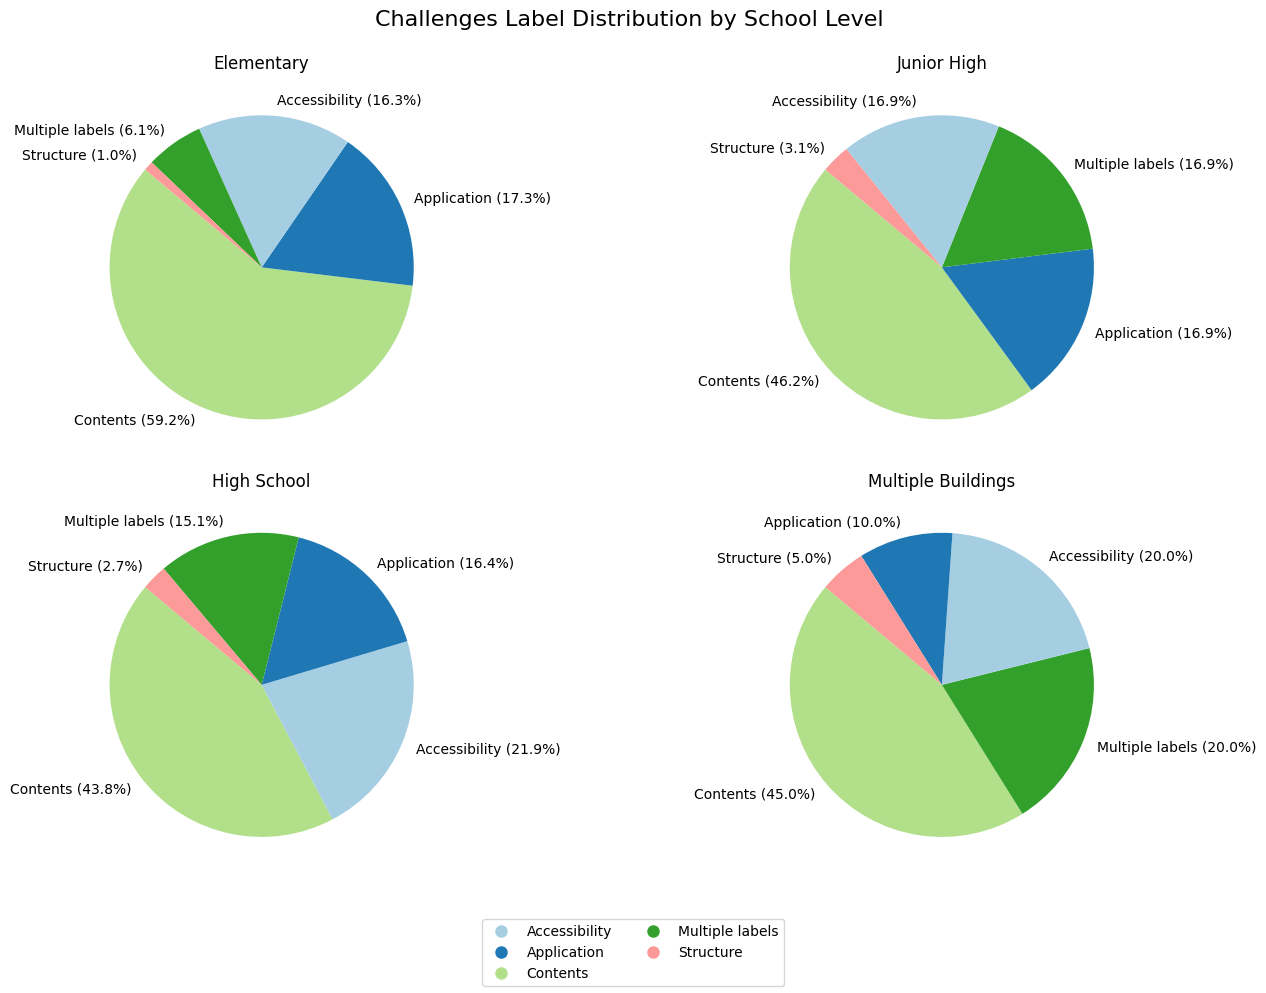

In [132]:
df_elem.loc[:, 'challenges_labels'] = df_elem.iloc[:, 55].apply(label_response)
df_jr.loc[:, 'challenges_labels'] = df_jr.iloc[:, 55].apply(label_response)
df_hs.loc[:, 'challenges_labels'] = df_hs.iloc[:, 55].apply(label_response)
df_multi.loc[:, 'challenges_labels'] = df_multi.iloc[:, 55].apply(label_response)

elem_challenges_filtered = df_elem[df_elem["challenges_labels"].apply(lambda x: len(x) > 0 and x != ["Not useful response"])]
jr_challenges_filtered = df_jr[df_jr["challenges_labels"].apply(lambda x: len(x) > 0 and x != ["Not useful response"])]
hs_challenges_filtered = df_hs[df_hs["challenges_labels"].apply(lambda x: len(x) > 0 and x != ["Not useful response"])]
multi_challenges_filtered = df_multi[df_multi["challenges_labels"].apply(lambda x: len(x) > 0 and x != ["Not useful response"])]

def simplify_labels(label_list):
    if len(label_list) == 1:
        return label_list[0]  # keep single label
    else:
        return "Multiple labels"  # collapse 2+ labels

elem_challenges_filtered["label_combo"] = elem_challenges_filtered["challenges_labels"].apply(simplify_labels)
jr_challenges_filtered["label_combo"] = jr_challenges_filtered["challenges_labels"].apply(simplify_labels)
hs_challenges_filtered["label_combo"] = hs_challenges_filtered["challenges_labels"].apply(simplify_labels)
multi_challenges_filtered["label_combo"] = multi_challenges_filtered["challenges_labels"].apply(simplify_labels)

data1 = elem_challenges_filtered['label_combo']
data2 = jr_challenges_filtered['label_combo']
data3 = hs_challenges_filtered['label_combo']
data4 = multi_challenges_filtered['label_combo']
datasets = [data1, data2, data3, data4]
titles = ['Elementary', 'Junior High', "High School", "Multiple Buildings"]
all_labels = sorted(set().union(*[set(data.unique()) for data in datasets]))

colors = plt.cm.Paired(range(len(all_labels)))
label_color_map = dict(zip(all_labels, colors))

# Compute label percentages and prepare pie charts
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()


for i, data in enumerate(datasets):
    counts = data.value_counts()
    percentages = counts / counts.sum() * 100
    labels = counts.index
    pie_colors = [label_color_map[label] for label in labels]


    axes[i].pie(
        percentages,
        labels=[f"{label} ({percentages[label]:.1f}%)" for label in labels],
        colors=pie_colors,
        startangle=140
    )
    axes[i].set_title(titles[i])

# Create a single shared legend
handles = [plt.Line2D([0], [0], marker='o', color='w',
                      markerfacecolor=label_color_map[label],
                      markersize=10, label=label) for label in all_labels]


fig.legend(handles=handles, loc='lower center', ncol=2, fontsize='medium')
plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.suptitle("Challenges Label Distribution by School Level", fontsize=16)
plt.show()


In [133]:
contents_gap = [
    "My only dislike is that there's only one or two standards that directly address literacy, reading choice, etc",
    "I find that the focus on these standards is primarily on the library and digital information and digital information literacy skills development. Last time I checked, we still live in a physical world with physical libraries and books. Students still need to learn how to find materials independently in these physical spaces and I feel as though these standards forget about that (along with many other sets of standards for school libraries). We need to teach students how to function in a physical library AND also teach them how to function in the digital realm of information retrieval. My students are lost after looking up a book in the digital catalog if I don't first teach them how to locate physical books on the library shelves",
    "I wish that the Future Ready Librarian standards were integrated into these. They came out at the same time and were confusing to be repeated",
    "I do not like that the standards haven't included reading. There is nothing in our standards about reading comprehension, appreciation & exposure to different types of literature or creating a love of reading. Our standards seem to heavily focus on the inquiry piece of our job",
    "I find it difficult to identify the specific standards which address social-emotional learning and other important skills like teamwork, cooperation, sharing, etc",
    "I would like more included about how to scale the standards from K-12",
    "Our school has a technology lab where all the STEM  and maker space lessons happen. I'm teaching literacy lessons to support the curriculum and teachers/students. Different libraries have different number and length of lessons so it is easier if lessons can be delivered in 15/30/45 minute timeframes",
    "There is little to show how a progression of skills/knowledge would take place - from K-2, 3-5, 6-8, 9-12",
    "There is no checklist. There is no applicability. It seems to be a catch all net for what you want it to be. I wanted curriculum. I wanted standards. I wanted grade band learning expectations. I do not feel that is what was given",
    "We are now including the Engineering Design Process and STEM in our curriculum. The standards should reflect this. These standards don't reflect most of what I do and teach",
    "Would like more practical examples",
    "Also wish that it was available as a crosswalk with ISTE,  or CCSS",
    "There is not enough about helping students to learn to love reading",
    "I'm not sure if my issue is with the publication or the Standards themselves, but there is no emphasis on reading for pleasure, or 'free choice' books. This makes it hard for me to advocate for libraries in a district that has 5 TLs for 15,000 students.",
    "With the growth of technology, they need to be updated for the AI era",
    "I do wish there was a little more spelled out about media literacy, everyday media and technology usage, personal relationships with technology and media. I find some of the standards mentioning collaborative work, discussions, and tinkering difficult to implement at my level, so in my district, we've been looking at addressing them at different levels K-12.",
    "Personally, I wish they were a little more skill & grade specific",
    "I expected benchmarks and skills by grade",
    "I would like to see more examples of lessons or units that address each standard group"
]
locate = [
    "I waste so much time searching the standards to find the ONE that applies to what I am doing with students. Empowering Learners, while not as detailed, was organized in a way that made it easier to find the relevant standards",
    "It is dense (which is good) and sometimes difficult to locate exactly what I'm going for",
    "Almost too much material. Not so easy to find what you are looking for",
    "It's too word heavy. I can never find what I'm looking for.",
    "They are difficult to locate standards",
    "Its a lot of information",
    "There are so many parts that sometimes it's difficult to find exactly what you are looking for (domains, shared foundations, key commitments, etc.)",
    "Too many scenarios - very confusing. I just want the infomration",
    "There's just so much!",
    "Nothing. It's bulky & too much",
    "There's too much and too many elements to the framework. I am relying on the Learning guides created by the AASL Emerging leaders teams. they are a practical supplement."
]
breakdown = [
    "It does not break the standards down for different age levels",
    "The standards are not broken down into what students should know at each developmental level. How do the standards build on one another year after year?",
    "Too much information-all the wordiness could be better used to break down the standard for each grade level",
    "It is too much to take in. I think it would be much more accessible if broken down into grade-range bands",
    "Confusing that the library itself has a set of standards",
    "It's TOO MUCH. It's overwhelming to read and use and this ultimately makes it useless in my opinion. I don't understand why school librarians and school libraries are two separate things -- just seems unnecessary. The learner competencies make sense to me.",
    "It seemed to make sense to be broken down by students, librarian and library. They are connected but different focuses",
    "not broken down by grade/grade band"
]
lengthy = [
    "Very long",
    "a little wordy",
    "The book seems a little long--therfore, daunting. I believe the information could be condensed",
    "The length. It feels a bit overwhelming",
    "They are incredibly bloated, wordy, complex, and long",
    "Getting to everything I need, not really a read-all-at-once book",
    "It's very detail. While I appreciate all the information provided, I have not read the entire book. Some of the information is not pertinent. I tend to skim the book and go to different sections.",
    "Too large of book",
    "Hard to easily access the entire framework at a simple glance",
    "Length can be a barrier for others. The key is to make it clear this is a reference book",
    "Frankly, once we're out of our training programs, there is no time to read a whole book, nor is there always money for professional books-- books for students come first.",
    "I dislike the length",
    "There's just so much!",
    "They are wordy.",
    "They're just too much.",
    "It is very word-y and long",
    "I sometimes wish the framework/standards were a little less wordy and involved",
    "so. much. content (in a good way)",
    "too wordy",
    "wording",
    "Too long, too wordy. Standards are dense",
    "very wordy",
    "Overwhelming in volume",
]
examples = [
    "I would like to see more examples of the standards being used in an elementary school setting",
    "Needs more hard core examples and real world ideas in there. To me it is very much pie in the sky. Sentences sound good. But how do schools get from point A to point B. THAT is what is missing. Written like people who wrote it have not ever been in a classroom or dealt with how far behind these kids are in reality. Need more success stories in real life",
]
reader = [
    "Some are hard to understand",
    "For me it is somewhat difficult to synthesize the content. I probably need more time in the book",
    "I wish the language was more student-friendly or had a student-friendly option",
    "more user friendly and relevant",
    "The standards are out of touch of Title I schools that have elementary students who are still learning to read. Most of my students have never been to a library or even been read to before starting school",
    "The standards are incredibly complicated to understand and use in general. This is a way to understand them and I feel the standards themselves should not be so complicated",
    "it is a bit confusing and takes time to circle back around to everything. Many ideas and districts are still stuck in the early 21st century and many would take years to get to these standards. It has been an uphill battle with some old time librarians to introduce the standards",
    "Not the most user-friendly for a quick look at standards for non-librarian district PD",
    "Language is not user friendly--to nebulous",
    "Sometimes the set up of the standards and how they are interpreted can be challenging.  For example, knowing how to read the map to say you are in curating and you are sharing, etc",
    "It is a bit confusing and convoluted in presentation, could be a more streamlined and easy to use",
    "Would like it to be a little more reader friendly"
]
outdated = [
    "Some of the specific data points regarding collection development seem outdated",
]
overwhelming = [
    "I find it all too overwhelming and my principal certainly doesn’t care to read and understand them",
    "It is way too complex, especially at an elementary level",
    "I find the book well done.  Sometimes it can be daunting in what don't/should I be doing",
    "it's overwhelming and  would be impossible to implement ALL standards for all learners",
    "It can be overwhelming and confusing",
    "I understand the reasoning for how the material is compiled, it is simply overwhelming in scope",
    "sorry but it's too complicated, not subject specific compared to State Standards",
    "It can be overwhelming to someone who is new or changing professions to grasp",
    "All the letters and numbers for the standards",
    "The learning standards are too much as a whole and are not clear the way they are presented",
    "The framework is not friendly and is overwhelming",
    "Because it has 2 sets of standards it is dense and hard to use",
    "It is overwhelming without some samples of how each standard could be met at different grade levels",
    "The book, like the standards, is overly complicated. I would prefer a simplified version of the standards and for the book to include lesson plans for each standard",
    "The book is so cumbersome and the standards themselves are overly complicated. 4 domains for each of 6 foundations for 3 different audiences is way too much",
    "It's overly complicated",
    "The standards themselves were too complicated to communicate effectively or use as a scope and sequence",
    "Dividing it into 3 categories.  Keep it simple",
    "It's complicated"
]
repeat = [
    "There are so many strands and tables that seem to repeat themselves, it's hard to always know which one to choose. ",
    "everything seems to be repeatitive",
    "The Curate Standard Think and Create start to overlap. Determining the need, identifying possible sources of information, making critical choices, seeking a variety of sources  etc... (This is all done in the Research Process with the Super 3 and Big 6). Why are we taking something simple with 3-6 steps and making it so complicated across the board.",
    "The separate standards for librarians and libraries are difficult to differentiate and seem redundant",
    "It is repetitive, disorganized and hard to follow."
]
idealistic = [
    "It operates in an idealistic setting, which I've yet to experience in more than 20 years of being a School Librarian",
    "I find that somethings are unrealistic or too idealistic for school librarians to achieve. It's just too much responsibility for one position.",
]
vague = [
    "Too vague.  I would like some more concrete examples of ways to teach the standards",
    "sometimes they can be very vague or general",
    "they aren't clear, too ambiguous",
    "I think these standards are too broad.  I think they lack clarity and need to be narrowed down",
    "I would like more concrete examples",
    "It is too vague",
    "The standards themselves are very board and hard to crosswalk with other standards (ie state)",
    "Difficult format to use.  Language is not user friendly--to nebulous",
    "Organization (in my opinion) is poor and is not easy to follow.  The standards are too vague and broad",
    "I like to align it with other standards that are more narrow in focus depending upon what I am teaching in practice. The above publications are very broad",
    "everything is vague",
    "Vague and broad...not specific enough so consistent teaching from school to school and district to district",
    "I find they lack specificity",
    "Sometimes vague...how to break down the standards into lessons can be a challenge sometimes",
    "I don't see the distinctions between standards",
    "The standards are too vague and broad",
    "broad for K-12 education, not expectations for specific grades or grade bands",
    "They are very broad. I would like more guidance on library programing",
    "sometimes too general to measure effectiveness in classroom",
    "Very broad/generic",
]
buyin = [
    "Standards are hard to assess, so while they are valuable, it makes them hard to advocate to administrators who want deliverables and data",
    "School administrators are not familiar with these standards or this book",
    "sometimes it's difficult to explain the framework and shared foundations",
    "Administrators, for the most part, do not care about library standards. We should be looking at all disciplines’ research standards and deciding what those look like in libraryland.   Teaching dispositions, at least for me, is unrealistic",
    "One of the hardest things to get administrators to understand is that we do teach a specific content--research & information literacy. I would like to see that specific content made more explicit in the standards. I think they could do a little more to show how we support reading in the school as well--both aesthetic & efferent reading (for pleasure & for information)",
    "Outside of my library colleagues, no one knows or cares about them",
    "That my state dept of ed doesn't recognize it so my administrators don't think it needs to be followed.",
    "Administrators do not always value the national standards vs the state standards",
    "It's also more incomprehensible to explain to administrators and fellow educators.",
    "Also, there needs to be marketing to schools that this is the way our libraries are run.  Too many believe we are just babysitters who read books.  Good work can be done, but I don't think anyone outside the library world knows or cares about these standards.  Schools who embrace them will have high achieving students",
    "Elementary School libraries in my district are still perceived/  thought of like that of the elementary school libraries 25-30+ years ago.  Technology has changed the school librarian's role and standards, however administrators do not 'see' or recognize this important change and transition of current elementary libraries function as standards require.  So, new standards are often difficult to address when administrators do not understand the current role of elementary school libraries.  So, my concern is that the new national standards of school libraries, such as technology standards, are often out of reach for the elementary school librarian"
]
practical = [
    "understanding how it fits to my schedule and curriculum",
    "Same as above because it is alot to include on lesson plans.  I feel like I am missing them",
    "I guess I need training on how to implement it while meeting the challenges of the needs of students in a Title I school",
    "I've found them challenging to apply to my daily work.",
    "It is extremely wordy and not easily translated to elementary library skills.  My administration doesn't understand how AASL standards relate to our state standards.",
    "It can be difficult to apply them to certain library lessons",
    "I wish that there were more concrete examples by grade level.  Some of the standards sound nice, but it can be hard to imagine how to apply them, especially with K-2 students",
    "Some of the standards feel extremely pedagogical but not necessarily practical for practicing librarians.  I am not sure how much input actual school librarians had in creating it and how much cultural and economic diversity was taken into consideration",
    "I often have difficulty in placing some of the standards into my lesson plans for primary students",
    "It is a lot but also necessary.  I love them but find them hard to implement in my environment. In the elementary level on a fixed rotation schedule it is a dream that belies the possibility of implementation due to parameters that are beyond my control",
    "I had high hopes for it but I found it confusing and not practical. I have tried to incorporate these standards but they are too broad, difficult to measure and can apply to anything. They aren't useful",
    "It is difficult to put into practice and be useful at times. I would like some examples of how to incorporate the standards because not all of them are easy to incorporate into my library classes",
    "They are ideal...but we are not working in ideal situations. We have to work in situations that other people get to determine such as schedule, budget,planning time or lack of it",
    "not very easy to align with current state requirements",
    "It would be great to have a 'how to use' page to help new librarians use the standards",
    "It is difficult to put into practice and be useful at times. I would like some examples of how to incorporate the standards because not all of them are easy to incorporate into my library classes",
    "Not as practicle for middle school and high school libraries as elementary",
    "It is not practical for helping me shape the day to day operations of my library",
    "It's too broad and hard to take parts from the standards that work alone and can be integrated into lessons or units. It hasn't explained and clarified our role. Has it contributed to less being learned about us? More confusion?",
    "The framework is by definition, murky. In an effort to be applicable to the wide variety of student ages and the different aspects of a librarian's work, it falls short of practically meeting needs.",
    "I find the standards wordy and hard to use in real life. I still use the old AASL standards for designing research rubrics for students because they are more clear and easy to understand",
    "Not practical or actionable",
    "lacks ease in practical application imho",
    "I wouldn't say that I dislike any element of it, I just wish there were more sample lesson plans. Or more examples in terms of goal-setting for teacher evaluation",
    "It is difficult to put into practice and be useful at times. I would like some examples of how to incorporate the standards because not all of them are easy to incorporate into my library classes",
    "I find it challenging as a school librarian in an alternative high school to follow guidelines set for grade level when we do not have grade levels",
    "They are not easy to apply. It can be difficult to match them to other discipline standards and at the high school level most often lessons are collaborative for me",
    "There are a lot of standards within the learner standards that do not connect with my state content standards and that don’t seem to fit within the instructional piece but rather the program piece. It feels like we jammed a lot of standards in the instructional piece that could be more streamlined to fit into critical thinking as well as effective and ethical use of information",
    "Would like more practical examples",
    "Sometimes hard to apply in certain situations",
    "It is difficult to map the standards out from the ground level",
]
time_constraints = [
    "There are alot of standards to follow. However, we do not have reasonable time or staffing to fully follow said standards",
    "having the actual planning or administrative time to design lessons and research the standards",
]
color_codings = [
    "I think a different color scheme and dyslexic type face may help.",
    "The color is attractive and distinctive, but it would be helpful to have different colors for the different standard areas: learners, librarians, and libraries. Sometimes it takes me a minute or two to realize I'm looking at the wrong section since they use similar language",
]
layout = [
    "The organization of the standards is most difficult. I would prefer them to be organized by developmental appropriateness and more concrete skills",
    "It is so hard to read! The print is so tiny. Portrait orientation does not work, wish it was landscape and font was bigger",
    "wish it was a spiral notebook and had space for notes in the margins",
    "Organization (in my opinion) is poor and is not easy to follow",
    "Difficult format to use",
    "I sometimes find the organization a bit challenging",
]
format = [
    "I have to type the standards into my lesson plan.  An online version would be more helpful to copy and paste",
    "I don't always have a copy on me, but I can always look them up easily online. That's not really a dislike",
    "I also think info on the foundations should be available free online for librarians.  If it is important to have standards, which it is, we need to have access to them and they should be easy to understand and use",
    "difficult to create one's own crosswalk bc it does not exist in  csv format",
    "Print copy can be useful and more cost friendly",
    "I also feel like it does not encompass helping students choose and read books in a variety of formats enough",
]
pricy = [
    "The online version is not the most intuitive to download/access.",
    "price prohibitive",
    "The book is much too expensive",
    "Expense",
    "too expensive",
    "I do not have access to the book, as the price point is prohibitively expensive for me personally. I have worked in two districts since the new standards were released and neither provides funding for professional development books. I would have had to use my budget allocated towards student books in order to purchase it for my use and that did not sit comfortably with me",
    "Only glanced over- wish it was free",
    "Getting a copy of it on a limited school budget",
    "The cost.  If I had not been given a discount through my university program, I would not have been able to afford to purchase the book",
    "The cost of the book is prohibitive",
    "The cost of it, which is more than 10% of my annual budget in one of my schools",
    "The materials are prohibitively expensive",
    "It's inaccessible usually behind a paywall. Way too expensive & way too wordy. That’s why I prefer the ISTE standards. They’re straight to the point",
    "They are expensive for school librarians who don't have a budget that allows them to purchase them, and not accessible online.",
    "I don't like that AASL members still had to pay for it.",
    "THE BOOK IS SO EXPENSIVE. it needs to be moreaccessible like the tx library standards are",
    "The price is cost prohibitive",
    "If the standards are to be used, they should be accessible to all librarians. It is difficult for me to purchase a book to understand the standards",
    "Cost, therefore accessibility",
    "I do not have access to the book, as the price point is prohibitively expensive for me personally. I have worked in two districts since the new standards were released and neither provides funding for professional development books. I would have had to use my budget allocated towards student books in order to purchase it for my use and that did not sit comfortably with me",
    "I think they book is way too costly for students and Librarians, who do not typically have a lot of money to spare. I also think the standards are useless",
    "Not a dislike, but I bought the book with district funds, but doubt I would do that again. I want to be able to Ctrl+F information quickly, so I won't buy book in the future if re-written.",
    "The book is also VERY expensive",
    "I am also frustrated by the cost. Many librarians do not get support from their administration or school districts to pay for professional organization membership, conferences, or publications. Choosing whether to buy materials for my students or to pay for the standards I need to advocate for my program is difficult",
    "The cost",
    "the cost",
    "The price. The price. The price",
    "Cost",
    "It is incredibly expensive for the average school librarian",
    "That they are not freely accessible. Someone who can not purchase the book does not have full access. Our profession is about equity and access and yet we are excluding some",
    "I dislike that I have $200 for a book about National Standards in my proffession. I think the general standards should be available to all but then a REASONABLY priced book about the standards ($30 or less). It really upsets me that ACCESS to the standards is so expensive. Shaking My Head",
    "The cost is too high. I was able to get a copy paid by my school but now I'm not allowed to order with ALA because my bookkeeper doesn't pay things in a timely manner and won't pay if things don't ship from ALA in a specific amount of time. It's just a huge hassle to order and to find funds. In the future, if there's an update, i won't be able to order it from ALA so I'm hoping it's purchasable from Follett or Barnes & Noble or other vendor so I don't have to pay for it out of pocket.",
]

label_map = {
    "Contents gaps in specific areas": contents_gap,
    "Difficulty locating information": locate,
    "Ineffective breakdown": breakdown,
    "Lengthy/wordy": lengthy,
    "Not enough examples": examples,
    "Not reader-friendly": reader,
    "Outdated contents": outdated,
    "Overwhelming": overwhelming,
    "Repetitive contents": repeat,
    "Too idealistic": idealistic,
    "Vague and broad": vague,
    "Administrator buy-in issues": buyin,
    "Not practical": practical,
    "Time constraints for implementation": time_constraints,
    "Confusing color coding": color_codings,
    "Unclear organization": layout,
    "Limited format choices": format,
    "Pricy": pricy
}


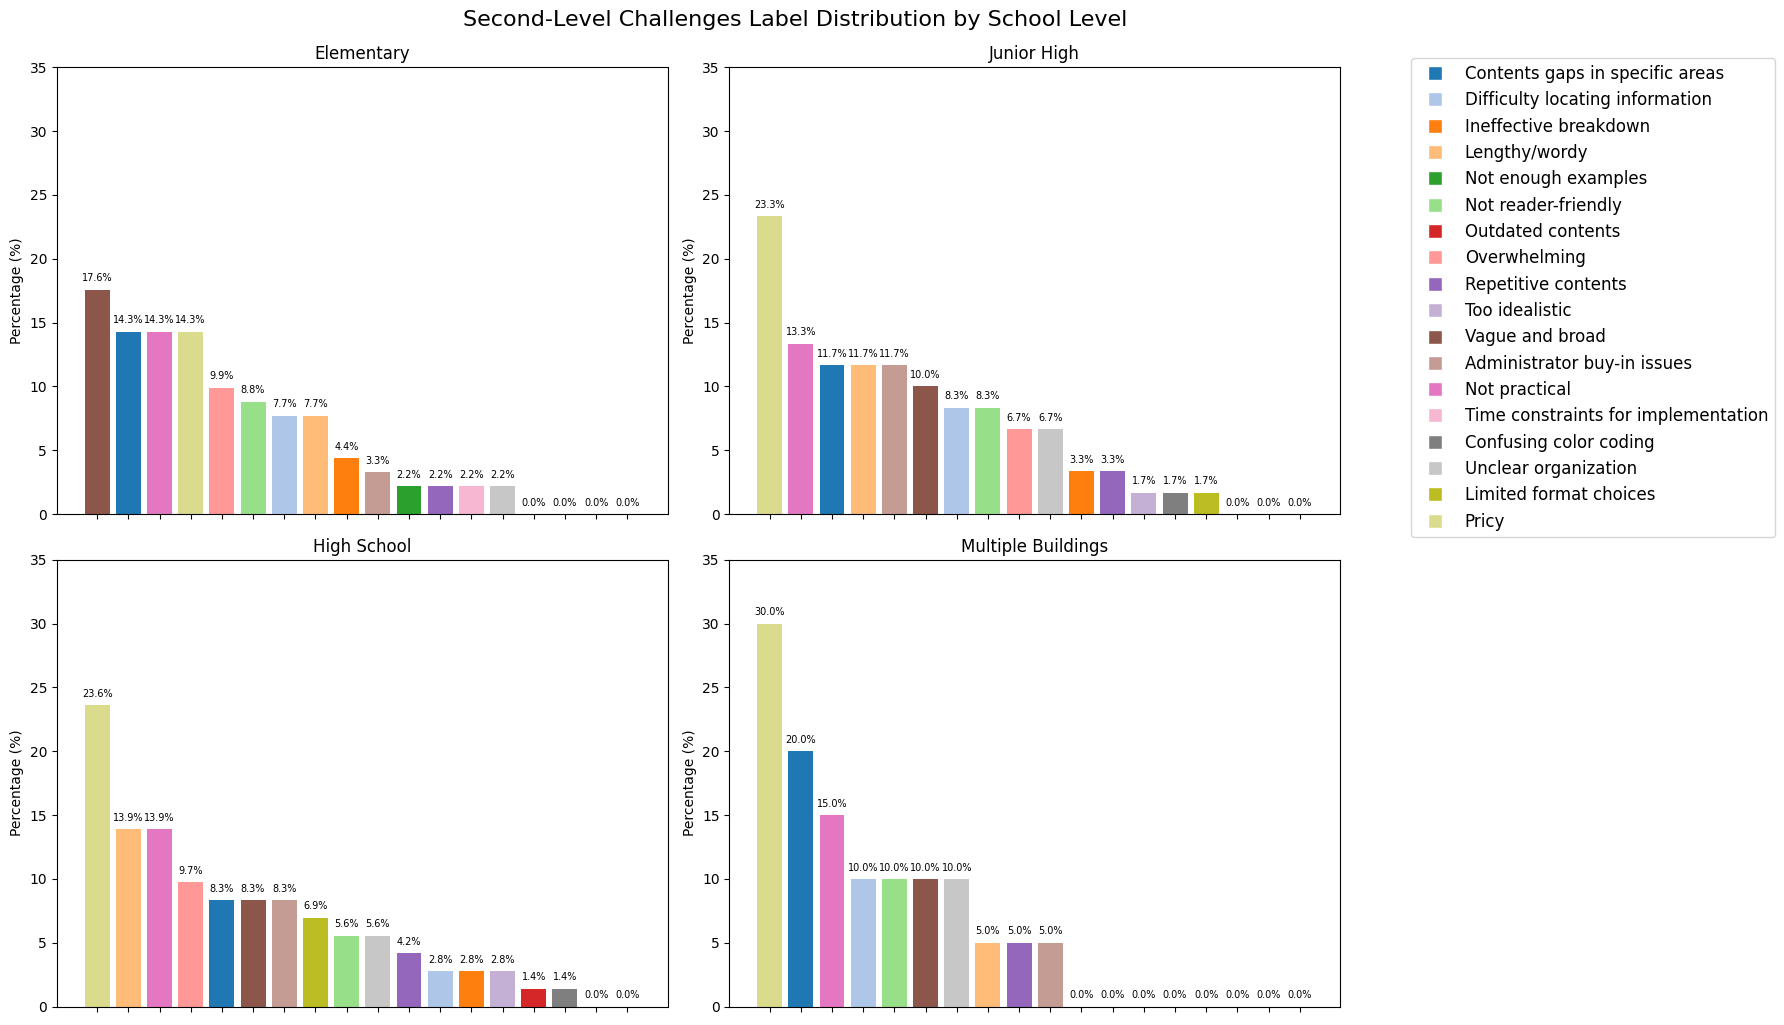

In [134]:
# create a column to store the second level labels
df_elem.loc[:, 'challenges_labels_s'] = df_elem.iloc[:, 55].apply(label_response)
df_jr.loc[:, 'challenges_labels_s'] = df_jr.iloc[:, 55].apply(label_response)
df_hs.loc[:, 'challenges_labels_s'] = df_hs.iloc[:, 55].apply(label_response)
df_multi.loc[:, 'challenges_labels_s'] = df_multi.iloc[:, 55].apply(label_response)

elem_challenges_filtered_s = df_elem[df_elem["challenges_labels_s"].apply(lambda x: len(x) > 0 and x != ["Not useful response"])].copy()
jr_challenges_filtered_s = df_jr[df_jr["challenges_labels_s"].apply(lambda x: len(x) > 0 and x != ["Not useful response"])].copy()
hs_challenges_filtered_s = df_hs[df_hs["challenges_labels_s"].apply(lambda x: len(x) > 0 and x != ["Not useful response"])].copy()
multi_challenges_filtered_s = df_multi[df_multi["challenges_labels_s"].apply(lambda x: len(x) > 0 and x != ["Not useful response"])].copy()

elem_challenges_filtered_s.loc[:, "label_combo"] = elem_challenges_filtered_s["challenges_labels_s"].apply(lambda labels: ", ".join(sorted(labels)))
jr_challenges_filtered_s.loc[:, "label_combo"] = jr_challenges_filtered_s["challenges_labels_s"].apply(lambda labels: ", ".join(sorted(labels)))
hs_challenges_filtered_s.loc[:, "label_combo"] = hs_challenges_filtered_s["challenges_labels_s"].apply(lambda labels: ", ".join(sorted(labels)))
multi_challenges_filtered_s.loc[:, "label_combo"] = multi_challenges_filtered_s["challenges_labels_s"].apply(lambda labels: ", ".join(sorted(labels)))


final_labels = [
    "Contents gaps in specific areas",
    "Difficulty locating information",
    "Ineffective breakdown",
    "Lengthy/wordy",
    "Not enough examples",
    "Not reader-friendly",
    "Outdated contents",
    "Overwhelming",
    "Repetitive contents",
    "Too idealistic",
    "Vague and broad",
    "Administrator buy-in issues",
    "Not practical",
    "Time constraints for implementation",
    "Confusing color coding",
    "Unclear organization",
    "Limited format choices",
    "Pricy"
]

colors = plt.cm.tab20(range(len(final_labels)))
label_color_map = dict(zip(final_labels, colors))


# Function to calculate label percentages
def compute_label_percentages(df, final_labels):
    total_responses = len(df)
    counter = Counter()
    for entry in df["label_combo"]:
        if pd.notnull(entry):
            labels = [label.strip() for label in entry.split(",")]
            for label in labels:
                if label in final_labels:
                    counter[label] += 1
    percentages = {label: (counter[label] / total_responses) * 100 for label in final_labels}
    return percentages


# Apply to each school level
datasets = [
    ("Elementary", elem_challenges_filtered_s),
    ("Junior High", jr_challenges_filtered_s),
    ("High School", hs_challenges_filtered_s),
    ("Multiple Buildings", multi_challenges_filtered_s)
]


# Step 5: Create the plot
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()


max_ylim = 35


for i, (title, df_group) in enumerate(datasets):
    percent_dict = compute_label_percentages(df_group, final_labels)
    sorted_items = sorted(percent_dict.items(), key=lambda x: x[1], reverse=True)
    labels, values = zip(*sorted_items)
    bar_colors = [label_color_map[label] for label in labels]


    ax = axes[i]
    bars = ax.bar(range(len(values)), values, color=bar_colors)
    ax.set_title(title)
    ax.set_ylabel("Percentage (%)")
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels([''] * len(labels))  # Hide x-axis text
    ax.set_ylim(0, max_ylim)  # fixed y-axis range


    # Add percentage text above bars
    for j, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.5, f'{height:.1f}%',
                ha='center', va='bottom', fontsize=7)


# Shared legend
handles = [
    plt.Line2D([0], [0], marker='s', color='w',
               markerfacecolor=label_color_map[label], markersize=10, label=label)
    for label in final_labels
]

fig.legend(handles=handles, loc='upper left', bbox_to_anchor=(0.88, 0.98), fontsize='large')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.suptitle("Second-Level Challenges Label Distribution by School Level", fontsize=16, y=1.02)
plt.show()


#### Suggestions

- `q29`: Is there anything new that could be included within the Standards?

In [135]:
filtered_df = df[df['jobRole'] == 'Certified / licensed school librarian']
usage = filtered_df.iloc[:, 129].dropna().to_list()
print(f"There are {len(usage)} responses from licensed school librarians")

There are 159 responses from licensed school librarians


In [136]:
filtered_df = df[df['jobRole'] == 'Educational library professionals']
usage = filtered_df.iloc[:, 129].dropna().to_list()
print(f"There are {len(usage)} responses from Educational library professionals")
usage

There are 1 responses from Educational library professionals


['none']

School library student: **"More guidance on grade level curriculum"**

In [137]:
filtered_df = df[df['jobRole'] == 'School library student']
usage = filtered_df.iloc[:, 129].dropna().to_list()
print(f"There are {len(usage)} responses from School library student")
usage

There are 3 responses from School library student


['Nothing I can think of',
 'not sure',
 'More guidance on grade level curriculum, developmentally appropriate goals for the standards per grade (much like core content areas build each year--guidance on topics, how to expand each year)']

School library supervisor
- shorter in length
- easier to use
- printable rubrics
- Technological advances in AI
- Lessons learned from others in a different area across grade level
- Support for reading

In [138]:
filtered_df = df[df['jobRole'] == 'School library supervisor']
usage = filtered_df.iloc[:, 129].dropna().to_list()
print(f"There are {len(usage)} responses from School library supervisor")
usage

There are 10 responses from School library supervisor


['They need to be shorter and easier to use.  ',
 'Rubrics in each area need to accessible and printable. Reading needs to be more prevalent in the standards, especially for advocacy. ',
 'The standards may want to address, technological advances in the area of artificial intelligence.',
 'I think it should sound like it was written by humans who are in diverse schools and places. I think it should focus more on skills and less on lofty goals.',
 'More practical examples of applying the standards in the library with students.',
 'Each school library is different, not just because of the different ages we serve, but because of our locations, etc. There are times it would be nice to see what others have done for lessons in different areas across grade level. Not included in the book, but perhaps references I could direct my ed techs to.',
 'More support for reading.',
 'Separation of Secondary and Elementary.',
 'Librarians coaching teachers through collaboration and coaching students th

State/DOE employee:
- AI literacy
- Specific examples in "Information Power II and the 2007 Standards in Action"

In [139]:
filtered_df = df[df['jobRole'] == 'State/DOE employee']
usage = filtered_df.iloc[:, 129].dropna().to_list()
print(f"There are {len(usage)} responses from State/DOE employee")
usage

There are 2 responses from State/DOE employee


['AI literacy',
 'One thing that I really appreciated in Information Power II and the 2007 Standards in Action were the specific examples of what the standards looked like.']

In [ ]:
with open("themes/suggestions.txt", "r", encoding="utf-8") as f:
    lines = [line.strip() for line in f if line.strip()]  # removes empty lines

# Build the DataFrame with one column
df_suggestions = pd.DataFrame(lines, columns=["response"])

# Optionally add empty label columns
df_suggestions["first_level"] = ""
df_suggestions["second_level"] = ""

# Load reference .txt files into dictionaries
def load_phrases(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        return set(line.strip() for line in f if line.strip())

first_level_map = {
    "Existing Contents": load_phrases("themes/existing_contents.txt"),
    "New Topics": load_phrases("themes/new_topics.txt"),
    "Delivery and Impact": load_phrases("themes/delivery_and_impact.txt")
}

second_level_map = {
    "Technology and Media Integration": load_phrases("themes/tech.txt"),
    "Revise Existing Contents": load_phrases("themes/revise_existing_contents.txt"),
    "Role and Identity of Librarians": load_phrases("themes/role_identity.txt"),
    "Literacy and Reading": load_phrases("themes/literacy.txt"),
    "Alternative and Emerging Educational Context": load_phrases("themes/alternative.txt"),
    "Student Development and Well-being": load_phrases("themes/student_development.txt"),
    "Specific Lesson-Related Topics": load_phrases("themes/specific.txt"),
    "Affordability": load_phrases("themes/affordability.txt"),
    "Alignment and Relevance": load_phrases("themes/alignment.txt"),
    "Format and presentation": load_phrases("themes/format_and_presentation.txt"),
    "Audience-Specific Versions": load_phrases("themes/audience_specific.txt")
}

# Assign first_level based on matches
def match_first_level(response):
    for label, phrases in first_level_map.items():
        if any(phrase in response for phrase in phrases):
            return label
    return ""  # or "Uncategorized"

def match_second_level(response):
    for label, phrases in second_level_map.items():
        if any(phrase in response for phrase in phrases):
            return label
    return ""  # or "Uncategorized"   

# Apply to the DataFrame
df_suggestions["first_level"] = df_suggestions["response"].apply(match_first_level)
df_suggestions["second_level"] = df_suggestions["response"].apply(match_second_level)

df_suggestions

,response,first_level,second_level
0,"'Not at this time.',",Existing Contents,Revise Existing Contents
1,"'Ditch the ""Foundations"" and ""Domains."" ',",Existing Contents,Revise Existing Contents
2,'We need to be able to have concrete standards...,Existing Contents,Revise Existing Contents
3,"""I'm not sure what to ask for, I guess I just ...",Existing Contents,Revise Existing Contents
4,"'CTE connections',",New Topics,Technology and Media Integration
...,...,...,...
88,"'The standards may want to address, technologi...",New Topics,Technology and Media Integration
89,"'More skills-based, with scope and sequences b...",Delivery and Impact,Format and presentation
90,"""Again, I'd like to see some specific skills r...",Delivery and Impact,Format and presentation
91,'Either acknowledgement that some standards ar...,Delivery and Impact,Format and presentation


In [141]:
df_suggestions[df_suggestions["second_level"] == ""]

,response,first_level,second_level


In [142]:
df_suggestions[df_suggestions["first_level"] == ""]

,response,first_level,second_level


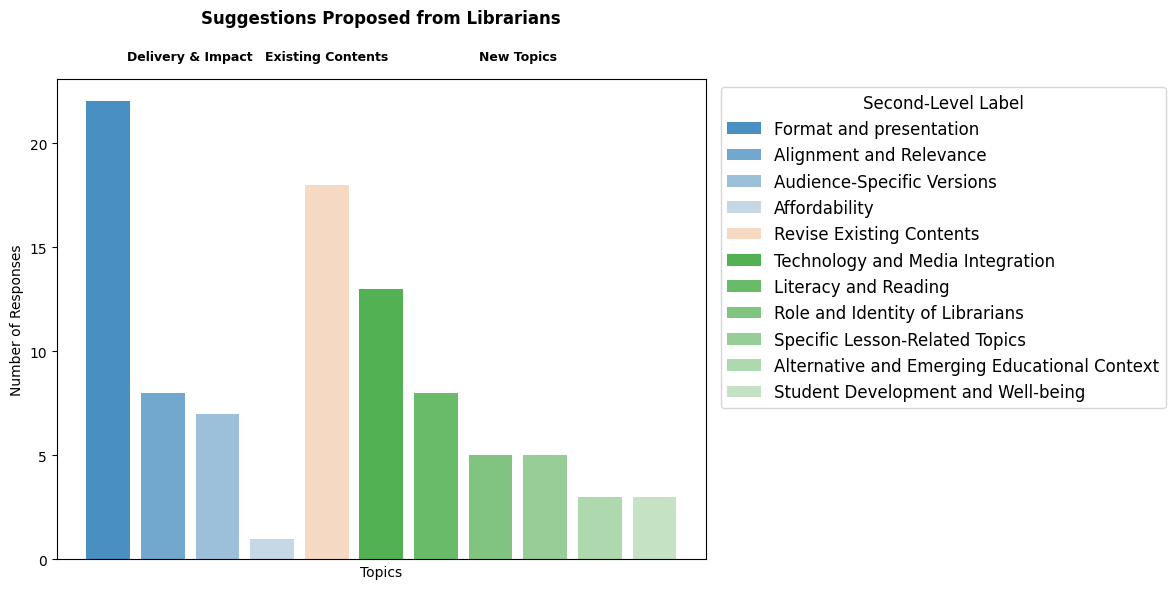

In [143]:
# Group and count
counts = df_suggestions.groupby(["first_level", "second_level"]).size().reset_index(name="count")
counts = counts.sort_values(by=["first_level", "count"], ascending=[True, False])

# Step 2: Define one base color per first-level group using tab20
tab20 = plt.cm.tab20.colors
base_color_map = {
    "Delivery and Impact": tab20[0],     # blue-ish
    "Existing Contents": tab20[2],     # orange-ish
    "New Topics": tab20[4]             # green-ish
}

def generate_shades(base_rgb, n):
    cmap = sns.light_palette(base_rgb, input="rgb", as_cmap=True)
    # Sample n values between 0.2 and 0.8 instead of 0 → 1
    return [to_hex(cmap(x)) for x in np.linspace(0.2, 0.8, n)][::-1]

# Assign color shades to second-level labels
color_lookup = {}

for flabel in counts["first_level"].unique():
    base_rgb = base_color_map[flabel]
    subset = counts[counts["first_level"] == flabel].copy()
    subset = subset.sort_values("count", ascending=False).reset_index(drop=True)
    shades = generate_shades(base_rgb, len(subset))  # darkest to lightest
    for i, slabel in enumerate(subset["second_level"]):
        color_lookup[slabel] = shades[i]

# Plot
plt.figure(figsize=(14, 6))
bars = plt.bar(
    x=counts["second_level"],
    height=counts["count"],
    color=[color_lookup[sl] for sl in counts["second_level"]]
)

# Legend
legend_elements = [Patch(facecolor=color_lookup[sl], label=sl) for sl in counts["second_level"]]
plt.legend(handles=legend_elements, title="Second-Level Label", bbox_to_anchor=(1.01, 1), loc="upper left", fontsize='large', title_fontsize='large')

# Title, labels, etc.
plt.title("Suggestions Proposed from Librarians", pad=40, fontweight='bold')
plt.xlabel("Topics")
plt.ylabel("Number of Responses")
plt.xticks([], [])
plt.tight_layout(rect=[0, 0, 0.85, 1])

# Group labels above bars
group_names = {
    "New Topics": [
        "Technology and Media Integration", "Literacy and Reading", "Role and Identity of Librarians",
        "Specific Lesson-Related Topics", "Alternative and Emerging Educational Context",
        "Student Development and Well-being"
    ],
    "Delivery & Impact": [
        "Format and presentation", "Alignment and Relevance", "Audience-Specific Versions", "Affordability"
    ],
    "Existing Contents": ["Revise Existing Contents"]
}

group_positions = {}
for name, slabels in group_names.items():
    indices = [i for i, label in enumerate(counts["second_level"]) if label in slabels]
    if indices:
        x_center = sum(indices) / len(indices)
        group_positions[name] = x_center

for name, xpos in group_positions.items():
    plt.text(xpos, max(counts["count"]) + 2, name, ha="center", fontsize=9, fontweight="bold")

plt.show()


------------------------------------------